

##**Student Name:** Muhammad Khubaib Akram
##**Student ID#** 23098929
------
##**Student Name:** Adeeb Naiyer
##**Student ID#** 23136316

-------

## Working on Yolov1

### Reference of paper: https://pjreddie.com/media/files/papers/yolo.pdf
### Reference of Code: https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/object_detection/YOLO


###In this code we have tried to work on Yolov1 implementation done by Aladdin Persson he added Batch Normalization which was not part of original paper.

###We have also tried working without Batch Normalization in this code as well.



In [65]:
DEVICE = "cpu"

In [7]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q kaggle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab import files
files.upload()  # Upload the kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download -d aladdinpersson/pascalvoc-yolo


100% 4.30G/4.31G [02:28<00:00, 32.9MB/s]
100% 4.31G/4.31G [02:28<00:00, 31.1MB/s]


In [6]:
!unzip -q pascalvoc-yolo.zip

##Data code

In [30]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold


import os
import pandas as pd
from PIL import Image


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter


from tqdm import tqdm


In [9]:
class VOCDataset(torch.utils.data.Dataset):
  """
  Creates a Pytorch dataset to load the Pascal VOC dataset
  """
  def __init__(
      self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None,
  ):
    """
    Initializes the dataset object.

    Args:
        csv_file (string): Path to the CSV file containing annotations.
        img_dir (string): Directory containing all the images.
        label_dir (string): Directory containing all the label files.
        transform (callable, optional): Optional transform to be applied on a sample (image and its bounding boxes).
    """
    # Load annotations from the CSV file into a pandas DataFrame.
    self.annotations = pd.read_csv(csv_file)

    # Store the directory paths for images and labels.
    self.img_dir = img_dir
    self.label_dir = label_dir

    # Store the transform function.
    self.transform = transform

    self.S = S
    self.B = B
    self.C = C

  def __len__(self):
    # Return the total number of items in the dataset.
    return len(self.annotations)

  def __getitem__(self, index):

    # Construct the path to the label file for the corresponding image and read
    # the bounding box data. The label file contains lines where each line
    # represents a bounding box described by [class_label, x_center, y_center, width, height].

    label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
    # List to store bounding boxes for the current image.
    boxes = []
    with open(label_path) as f:
      for label in f.readlines():
        # Split each line to get the bounding box attributes, convert them
        # to float, and add to the list of boxes.
        class_label, x, y, width, height = [
            float(x) if float(x) != int(float(x)) else int(x)
            for x in label.replace("\n", "").split()
        ]

        boxes.append([class_label, x, y, width, height])


    img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])

    image = Image.open(img_path)

    # Convert the list of boxes into a torch tensor for PyTorch compatibility.
    boxes = torch.tensor(boxes)

    # If a transform function is provided then apply it to the image and its bounding boxes.
    if self.transform:
      image, boxes = self.transform(image, boxes)

    # Convert To Cells
    label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
    for box in boxes:
      class_label, x, y, width, height = box.tolist()
      class_label = int(class_label)

      # i,j represents the cell row and cell column
      i, j = int(self.S * y), int(self.S * x)
      x_cell, y_cell = self.S * x - j, self.S * y - i

      """
      Calculating the width and height of cell of bounding box,
      relative to the cell is done by the following, with
      width as the example:

      width_pixels = (width*self.image_width)
      cell_pixels = (self.image_width)

      Then to find the width relative to the cell is simply:
      width_pixels/cell_pixels, simplification leads to the
      formulas below.
      """
      width_cell, height_cell = (
          width * self.S,
          height * self.S,
      )

      # If no object already found for specific cell i,j
      # Note: This means we restrict to ONE object
      # per cell!
      if label_matrix[i, j, 20] == 0:
        # Set that there exists an object
        label_matrix[i, j, 20] = 1

        # Box coordinates
        box_coordinates = torch.tensor(
            [x_cell, y_cell, width_cell, height_cell]
        )

        label_matrix[i, j, 21:25] = box_coordinates

        # Set one hot encoding for class_label
        label_matrix[i, j, class_label] = 1

    return image, label_matrix

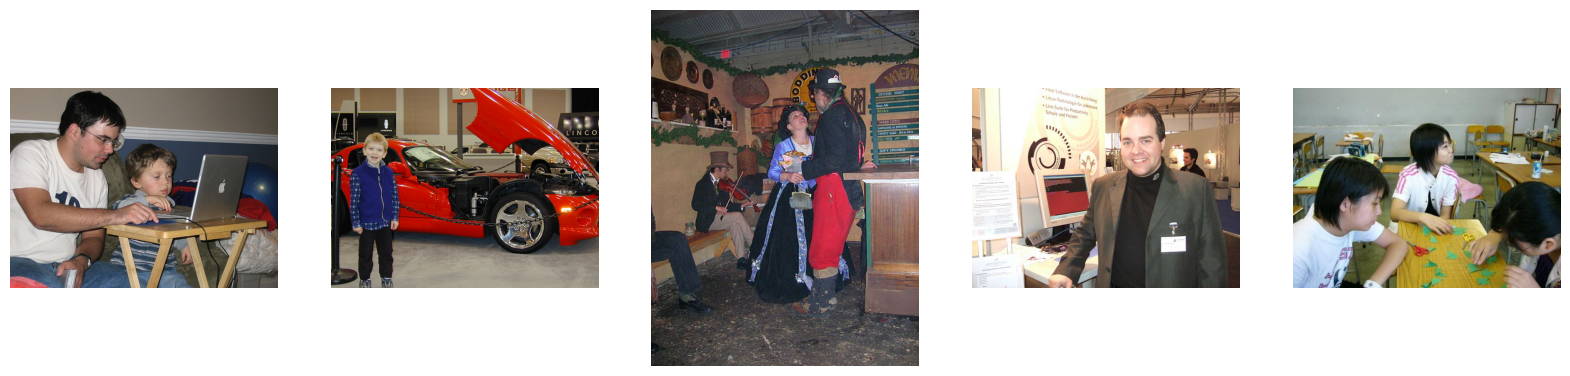

In [58]:
image_dir = "/content/images"

sample_images = os.listdir(image_dir)[:5]  # This will give us the first 5 images

# Display sample images
plt.figure(figsize=(20, 10))

for idx, image_name in enumerate(sample_images):
    image_path = os.path.join(image_dir, image_name)
    image = Image.open(image_path)
    plt.subplot(1, len(sample_images), idx+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

# Utilis file


Intersection over Union (IoU) is a metric used to evaluate the accuracy of an object detector on a particular dataset. It measures the overlap between two bounding boxes: the predicted bounding box and the ground truth bounding box. IoU is calculated by dividing the area of the overlap between the two bounding boxes by the area of the union of the two bounding boxes. The IoU metric ranges from 0 to 1, where 1 indicates a perfect match between the predicted bounding box and the ground truth.

In [10]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
  """
  Calculates intersection over union

  Parameters:
      boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
      boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
      box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

  Returns:
      tensor: Intersection over union for all examples
  """
  # If the boxes are in midpoint format (x_center, y_center, width, height)

  if box_format == "midpoint":
    # Calculate the coordinates of the top left corner of the predicted and ground truth boxes
    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2

    # Calculate the coordinates of the bottom right corner of the predicted and ground truth boxes
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

  # If the boxes are in corner format (x_min, y_min, x_max, y_max)
  if box_format == "corners":
    box1_x1 = boxes_preds[..., 0:1]
    box1_y1 = boxes_preds[..., 1:2]
    box1_x2 = boxes_preds[..., 2:3]
    box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
    box2_x1 = boxes_labels[..., 0:1]
    box2_y1 = boxes_labels[..., 1:2]
    box2_x2 = boxes_labels[..., 2:3]
    box2_y2 = boxes_labels[..., 3:4]

  # Calculate the coordinates of the intersection rectangle
  x1 = torch.max(box1_x1, box2_x1)
  y1 = torch.max(box1_y1, box2_y1)
  x2 = torch.min(box1_x2, box2_x2)
  y2 = torch.min(box1_y2, box2_y2)

  # .clamp(0) is for the case when they do not intersect
  intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0) # Calculate the area of the intersection rectangle

  # Calculate the area of both the predicted and ground truth boxes
  box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
  box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

  # Calculate the union area by adding both areas and subtracting the intersection area (union = box1_area + box2_area - intersection)
  # Compute the IoU by dividing the intersection area by the union area
  return intersection / (box1_area + box2_area - intersection + 1e-6) #Adding a small epsilon to avoid division by zero

**Non-Maximum Suppression (NMS)** is a technique used in object detection to select the best bounding box when several overlapping bounding boxes are detected for the same object. This process helps reduce the number of redundant bounding boxes, keeping only the one with the highest confidence score while ensuring that different objects are not suppressed.

In [11]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list # Ensure the input bboxes is a list

    # Filter out bounding boxes with a confidence score below the threshold
    bboxes = [box for box in bboxes if box[1] > threshold]

    # Sort the bounding boxes by the confidence score in descending order
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []   # List to store bounding boxes after NMS

    while bboxes:
      # Pop the bounding box with the highest confidence score
      chosen_box = bboxes.pop(0)

      # Keep the chosen_box and remove all other boxes that have a high IOU with it
      bboxes = [
        box
        for box in bboxes
        if box[0] != chosen_box[0]    # Check if they are of different classes
        or intersection_over_union(
            torch.tensor(chosen_box[2:]),
            torch.tensor(box[2:]),
            box_format=box_format,
        )
        < iou_threshold               # Check if IOU is below the threshold
      ]

      # Add the chosen box to the list of boxes after NMS
      bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

**Non_Max_Suppression function works as follows:**

**Input Filtering:** Initially, it filters out all bounding boxes whose confidence scores are below a certain threshold. This step reduces the number of boxes to process and focuses on more likely candidates.

**Sorting:** The remaining bounding boxes are sorted in descending order based on their confidence scores. This ensures that the box with the highest confidence is processed first.

**Selection and Suppression:** The function iteratively selects the box with the highest confidence score (removing it from the list of candidates) and suppresses (removes) all other boxes that have a significant overlap (above iou_threshold) with the selected box. This process is repeated until no boxes are left to process.

**Class-specific Processing:** The function also checks if the remaining and the selected boxes belong to the same class before calculating IoU, ensuring that boxes of different objects are not suppressed.

**Output:** The final list contains only the selected boxes after applying NMS, significantly reducing redundancy while retaining the most confident predictions.


NMS is a crucial step in object detection workflows, improving the precision of the detection by eliminating excessive box predictions.








In [12]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
  """
  Calculates mean average precision

  Parameters:
      pred_boxes (list): list of lists containing all bboxes with each bboxes
      specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
      true_boxes (list): Similar as pred_boxes except all the correct ones
      iou_threshold (float): threshold where predicted bboxes is correct
      box_format (str): "midpoint" or "corners" used to specify bboxes
      num_classes (int): number of classes

  Returns:
      float: mAP value across all classes given a specific IoU threshold
  """

  # list storing all AP for respective classes
  average_precisions = []

  # used for numerical stability later on
  epsilon = 1e-6

  for c in range(num_classes):
    detections = []
    ground_truths = []

    # Go through all predictions and targets,
    # and only add the ones that belong to the
    # current class c
    for detection in pred_boxes:
      if detection[1] == c:
        detections.append(detection)

    for true_box in true_boxes:
      if true_box[1] == c:
        ground_truths.append(true_box)

    # find the amount of bboxes for each training example
    # Counter here finds how many ground truth bboxes we get
    # for each training example, so let's say img 0 has 3,
    # img 1 has 5 then we will obtain a dictionary with:
    # amount_bboxes = {0:3, 1:5}
    amount_bboxes = Counter([gt[0] for gt in ground_truths])

    # We then go through each key, val in this dictionary
    # and convert to the following (w.r.t same example):
    # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
    for key, val in amount_bboxes.items():
      amount_bboxes[key] = torch.zeros(val)

    # sort by box probabilities which is index 2
    detections.sort(key=lambda x: x[2], reverse=True)
    TP = torch.zeros((len(detections)))
    FP = torch.zeros((len(detections)))
    total_true_bboxes = len(ground_truths)

    # If none exists for this class then we can safely skip
    if total_true_bboxes == 0:
      continue

    # Calculate TP and FP for the current clas
    for detection_idx, detection in enumerate(detections):
      # Only take out the ground_truths that have the same
      # training idx as detection
      ground_truth_img = [
        bbox for bbox in ground_truths if bbox[0] == detection[0]
      ]

      num_gts = len(ground_truth_img)
      best_iou = 0

      for idx, gt in enumerate(ground_truth_img):
        iou = intersection_over_union(
          torch.tensor(detection[3:]),
          torch.tensor(gt[3:]),
          box_format=box_format,
        )

        if iou > best_iou:
          best_iou = iou
          best_gt_idx = idx

      if best_iou > iou_threshold:
        # only detect ground truth detection once
        if amount_bboxes[detection[0]][best_gt_idx] == 0: # True Positive
          # true positive and add this bounding box to seen
          TP[detection_idx] = 1
          amount_bboxes[detection[0]][best_gt_idx] = 1  # Mark as detected
        else:
          FP[detection_idx] = 1  # False Positive

      # if IOU is lower then the detection is a false positive
      else:
        FP[detection_idx] = 1

    # Calculate precision and recall
    TP_cumsum = torch.cumsum(TP, dim=0)
    FP_cumsum = torch.cumsum(FP, dim=0)
    recalls = TP_cumsum / (total_true_bboxes + epsilon)
    precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
    precisions = torch.cat((torch.tensor([1]), precisions))
    recalls = torch.cat((torch.tensor([0]), recalls))

    #  Calculate Average Precision (AP) using the trapz method for numerical integration
    average_precisions.append(torch.trapz(precisions, recalls))

  return sum(average_precisions) / len(average_precisions) ## Calculate mAP by taking the mean of the APs across all classes

This function computes the mAP by:

Class-wise Separation: Separating predictions and ground truths by class to evaluate each class independently.
Sorting Predictions: Sorting predicted boxes by their confidence scores to process high-confidence predictions first.
Calculating True/False Positives: For each prediction, it determines whether the prediction is a true positive (TP) or a false positive (FP) based on the IoU with ground truth boxes

In [13]:
def plot_image(image, boxes):
  """Plots predicted bounding boxes on the image"""
  im = np.array(image)
  height, width, _ = im.shape

  # Create figure and axes
  fig, ax = plt.subplots(1)
  # Display the image
  ax.imshow(im)

  # box[0] is x midpoint, box[2] is width
  # box[1] is y midpoint, box[3] is height

  for box in boxes:

    # Remove the class label and confidence score, keeping only the box coordinates.
    box = box[2:]

    # Ensure the box has exactly four values (x_midpoint, y_midpoint, width, height).
    assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"

    # Calculate the upper left x and y coordinates of the box from its midpoint and dimensions.
    upper_left_x = box[0] - box[2] / 2
    upper_left_y = box[1] - box[3] / 2

    # Create a Rectangle patch object with the calculated coordinates and dimensions.
    # The coordinates are scaled by the image's width and height to fit the image size.
    rect = patches.Rectangle(
      (upper_left_x * width, upper_left_y * height), # Position of the rectangle's upper left corner
      box[2] * width,     # Rectangle width
      box[3] * height,    # Rectangle height
      linewidth=1,        # Border line width
      edgecolor="r",      # Border color set to red
      facecolor="none",   # No fill color
    )
    # Add the patch to the Axes
    ax.add_patch(rect)

  plt.show()

This function takes an image and a list of bounding boxes as inputs. Each bounding box is defined by its midpoint (x_midpoint, y_midpoint), width, and height, along with the class label and confidence score, which this function ignores. It visualizes each bounding box by converting these midpoints and dimensions into the upper-left corner coordinates required by matplotlib.patches.Rectangle to draw the rectangle. The function assumes the boxes' dimensions are normalized relative to the image size and scales them to pixel dimensions using the image's width and height. Each bounding box is drawn with a red edge and no fill color, overlaying the original image to visually represent the model's predictions.

In [14]:

def get_bboxes(
  loader,  # DataLoader for the dataset
  model,  # The trained object detection model
  iou_threshold,  # IOU threshold for Non-Maximum Suppression (NMS)
  threshold,  # Confidence score threshold for predictions to keep
  pred_format="cells",  # Expected format of the predictions
  box_format="midpoint",  # Format of the bounding boxes (midpoint or corners)
  DECIVCE="cuda"  # Device to run the model on ("cpu" or "cuda")
):
  all_pred_boxes = []  # store all the predicted bounding boxes
  all_true_boxes = []  # store all the ground truth bounding boxes

  # make sure model is in eval before get bboxes
  model.eval()
  train_idx = 0

  # Iterate over the dataset using the DataLoader
  for batch_idx, (x, labels) in enumerate(loader):
    x = x.to(DECIVCE)            # Move the input images to the specified device
    labels = labels.to(DECIVCE)  # Move the labels to the specified device

    # Disable gradient calculation to save memory and computations
    with torch.no_grad():
      predictions = model(x)     # Get model predictions for the current batch

    batch_size = x.shape[0]                     # Number of images in the current batch
    true_bboxes = cellboxes_to_boxes(labels)    # Convert cell-based true boxes to bounding boxes
    bboxes = cellboxes_to_boxes(predictions)    # Convert cell-based predictions to bounding boxes

    # Iterate over each image in the batch
    for idx in range(batch_size):
      # Apply Non-Maximum Suppression to filter the predictions
      nms_boxes = non_max_suppression(
        bboxes[idx],
        iou_threshold=iou_threshold,
        threshold=threshold,
        box_format=box_format,
      )


      for nms_box in nms_boxes:
        all_pred_boxes.append([train_idx] + nms_box)  # Store the filtered predictions

      for box in true_bboxes[idx]:
        # many will get converted to 0 pred
        if box[1] > threshold:                        # Check the confidence score
          all_true_boxes.append([train_idx] + box)    # Store the true boxes, applying the threshold

      train_idx += 1      # Move to the next image index

  model.train()
  return all_pred_boxes, all_true_boxes

The get_bboxes function extracts the predicted and true bounding boxes for all images in a dataset using a trained model, applying Non-Maximum Suppression (NMS) to filter the predictions. This function is crucial for evaluating object detection models, allowing for the calculation of metrics such as mAP (mean Average Precision).




In [15]:
def convert_cellboxes(predictions, S=7):
  """
  Converts bounding boxes output from Yolo with
  an image split size of S into entire image ratios
  rather than relative to cell ratios. Tried to do this
  vectorized, but this resulted in quite difficult to read
  code... Use as a black box? Or implement a more intuitive,
  using 2 for loops iterating range(S) and convert them one
  by one, resulting in a slower but more readable implementation.
  """

  predictions = predictions.to("cpu")   # Ensure predictions are on the CPU for processing
  batch_size = predictions.shape[0]     # Get the batch size from the predictions tensor
  predictions = predictions.reshape(batch_size, 7, 7, 30)   # Reshape predictions to separate out the bounding box components

  # Extract the bounding box coordinates for the two predicted bounding boxes
  bboxes1 = predictions[..., 21:25]
  bboxes2 = predictions[..., 26:30]
  # Concatenate the confidence scores for both sets of boxes to find the best ones
  scores = torch.cat(
      (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
  )
  # Determine which of the two bounding boxes has the higher confidence score
  best_box = scores.argmax(0).unsqueeze(-1)

  # Select the coordinates of the bounding boxes with the highest confidence
  best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2

  # Generate indices for each cell in the grid
  cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)

  # Calculate the x and y coordinates relative to the whole image
  x = 1 / S * (best_boxes[..., :1] + cell_indices)
  y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))

  # Width and height remain the same since they are already relative to the image size
  w_y = 1 / S * best_boxes[..., 2:4]

  # Combine the coordinates and dimensions back into a single tensor
  converted_bboxes = torch.cat((x, y, w_y), dim=-1)

  # Determine the predicted class for each bounding box
  predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)

  # Extract the confidence score for the best bounding box
  best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
      -1
  )

  # Combine the class, confidence, and bounding box information
  converted_preds = torch.cat(
      (predicted_class, best_confidence, converted_bboxes), dim=-1
  )

  return converted_preds

The convert_cellboxes function transforms the bounding box predictions made by a YOLO model from cell-relative coordinates to image-relative coordinates. YOLO divides an image into an SxS grid and predicts bounding boxes relative to each grid cell. This function converts those relative predictions into coordinates relative to the whole image, making them easier to work with for further processing or evaluation.

In [16]:
def cellboxes_to_boxes(out, S=7):
  """
    Transforms the output of the YOLO model to a list of bounding boxes for each image in the batch.

    Parameters:
        out (tensor): The output tensor from the YOLO model, containing the predictions for each cell.
        S (int): The size of the grid (SxS) that the image is divided into by the YOLO model.

    Returns:
        list: A list containing bounding boxes for each image in the batch.
    """
  # Convert the cell-relative bounding box predictions to image-relative predictions
  converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)

  # Convert the predicted class indices to long type for compatibility with certain PyTorch functions
  converted_pred[..., 0] = converted_pred[..., 0].long()

  all_bboxes = []

  for ex_idx in range(out.shape[0]): # Iterate over each image in the batch
    bboxes = []

    for bbox_idx in range(S * S): # Iterate over each cell in the grid
        # Extract the bounding box prediction for the current cell and convert tensor values to python scalars
        bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
    all_bboxes.append(bboxes) ## Add the list of bounding boxes for the current image to the list of all bounding boxes

  return all_bboxes

In [18]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state, filename)

In [19]:
def load_checkpoint(checkpoint, model, optimizer):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer"])

##YOlo LOSS

In [17]:
"""
Implementation of Yolo Loss Function from the original yolo paper

"""

class YoloLoss(nn.Module):
  """
  Calculate the loss for yolo (v1) model
  """

  def __init__(self, S=7, B=2, C=20):
    super(YoloLoss, self).__init__()
    self.mse = nn.MSELoss(reduction="sum")

    """
    S is split size of image (in paper 7),
    B is number of boxes (in paper 2),
    C is number of classes (in paper and VOC dataset is 20),
    """
    self.S = S
    self.B = B
    self.C = C

    # These are from Yolo paper, signifying how much we should
    # pay loss for no object (noobj) and the box coordinates (coord)
    self.lambda_noobj = 0.5
    self.lambda_coord = 5

  def forward(self, predictions, target):
    # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
    predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

    # Calculate IoU for the two predicted bounding boxes with target bbox
    iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
    iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
    ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

    # Take the box with highest IoU out of the two prediction
    # Note that bestbox will be indices of 0, 1 for which bbox was best
    iou_maxes, bestbox = torch.max(ious, dim=0)
    exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

    # ======================== #
    #   FOR BOX COORDINATES    #
    # ======================== #
    #Box Coordinate Loss (𝜆_coord term in the equation): This term penalizes the model for inaccuracies in the predicted locations of the bounding box coordinates (both center coordinates x and y).

    # Set boxes with no object in them to 0. We only take out one of the two
    # predictions, which is the one with highest Iou calculated previously.
    box_predictions = exists_box * (
      (
        bestbox * predictions[..., 26:30]
        + (1 - bestbox) * predictions[..., 21:25]
      )
    )

    box_targets = exists_box * target[..., 21:25]

    # Take sqrt of width, height of boxes to ensure that
    box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
      torch.abs(box_predictions[..., 2:4] + 1e-6)
    )
    box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

    box_loss = self.mse(
      torch.flatten(box_predictions, end_dim=-2),
      torch.flatten(box_targets, end_dim=-2),
    )

    # ==================== #
    #   FOR OBJECT LOSS    #
    # ==================== #

    # pred_box is the confidence score for the bbox with highest IoU
    pred_box = (
      bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
    )

    object_loss = self.mse(
      torch.flatten(exists_box * pred_box),
      torch.flatten(exists_box * target[..., 20:21]),
    )

    # ======================= #
    #   FOR NO OBJECT LOSS    #
    # ======================= #

    #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
    #no_object_loss = self.mse(
    #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
    #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
    #)

    no_object_loss = self.mse(
      torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
      torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
    )

    no_object_loss += self.mse(
      torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
      torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
    )

    # ================== #
    #   FOR CLASS LOSS   #
    # ================== #

    class_loss = self.mse(
      torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
      torch.flatten(exists_box * target[..., :20], end_dim=-2,),
    )

    loss = (
      self.lambda_coord * box_loss  # first two rows in paper - # Box coordinate and size losses
      + object_loss  # third row in paper -  Object confidence loss
      + self.lambda_noobj * no_object_loss  # forth row - No object confidence loss
      + class_loss  # fifth row - Class Prediction Loss
    )

    return loss

YOLO LOSS
------------------------
\begin{align*}
\lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{\text{obj}} \left[ (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 \right] & \\
+ \lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{\text{obj}} \left[ (\sqrt{w_i} - \sqrt{\hat{w}_i})^2 + (\sqrt{h_i} - \sqrt{\hat{h}_i})^2 \right] & \\
+ \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{\text{obj}} (C_i - \hat{C}_i)^2 & \\
+ \lambda_{\text{noobj}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{\text{noobj}} (C_i - \hat{C}_i)^2 & \\
+ \sum_{i=0}^{S^2} \mathbb{1}_{i}^{\text{obj}} \sum_{c \in \text{classes}} (p_i(c) - \hat{p}_i(c))^2 &
\end{align*}


--------------------
**Box Coordinate Loss (①):**
\begin{align*}
\lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{\text{obj}} \left[ (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 \right]
\end{align*}

This term minimizes the squared error between the predicted (x_i, y_i) and the ground truth (x̂_i, ŷ_i) center coordinates of the bounding box for each cell i that contains an object. It is scaled by a factor λ_coord to give it more weight relative to other components of the loss.

**Box Dimension Loss (②):**
\begin{align*}
\lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{\text{obj}} \left[ (\sqrt{w_i} - \sqrt{\hat{w}_i})^2 + (\sqrt{h_i} - \sqrt{\hat{h}_i})^2 \right]
\end{align*}


This term minimizes the squared error of the square root of the predicted bounding box width (w_i) and height (h_i) relative to the ground truth (ŵ_i, ĥ_i). This is done to reduce the impact of large boxes' deviations on the loss, and it is also scaled by λ_coord.

**Object Confidence Loss (③):**
\begin{align*}
\sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{\text{obj}} (C_i - \hat{C}_i)^2
\end{align*}

This loss penalizes the model for the difference between the predicted object confidence (C_i) for each bounding box and the ground truth, which is 1 for boxes with objects. It is calculated only for the box with the highest IoU with the ground truth among the predictions for each cell.

**No Object Confidence Loss (④):**
\begin{align*}
\lambda_{\text{noobj}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{\text{noobj}} (C_i - \hat{C}_i)^2
\end{align*}

This term minimizes the error between the predicted object confidence (C_i) for each bounding box and the ground truth, which is 0 for boxes without objects. It is scaled by λ_noobj because this prediction is typically less informative.

**Class Prediction Loss (⑤):**

\begin{align*}
\sum_{i=0}^{S^2} \mathbb{1}_{i}^{\text{obj}} \sum_{c \in \text{classes}} (p_i(c) - \hat{p}_i(c))^2
\end{align*}

This part of the loss function calculates the squared error of the predicted class probabilities (p_i(c)) for each cell relative to the one-hot encoded ground truth class probabilities (p̂_i(c)). This term only contributes to the loss for cells containing an object.

Overall, the YOLO loss function is a sum of these five terms, ensuring that the model is trained to accurately predict bounding box coordinates, dimensions, object confidence, and class probabilities.

## Model file

In [18]:
"""
Information about architecture config:
Tuple is structured by (kernel_size, filters, stride, padding)
"M" is simply maxpooling with stride 2x2 and kernel 2x2
List is structured by tuples and lastly int with number of repeats
"""

architecture_config = [
  (7, 64, 2, 3),
  "M",
  (3, 192, 1, 1),
  "M",
  (1, 128, 1, 0),
  (3, 256, 1, 1),
  (1, 256, 1, 0),
  (3, 512, 1, 1),
  "M",
  [(1, 256, 1, 0), (3, 512, 1, 1), 4],
  (1, 512, 1, 0),
  (3, 1024, 1, 1),
  "M",
  [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
  (3, 1024, 1, 1),
  (3, 1024, 2, 1),
  (3, 1024, 1, 1),
  (3, 1024, 1, 1),
]

**Architecture explanation:**

Each tuple or string in the list corresponds to a layer or a block of layers in the neural network, and their sequence represents the order in which they are applied in the model. Here's what each element means:

A tuple (kernel_size, filters, stride, padding) represents a convolutional layer with the following parameters:

**Kernel_size:** The size of the window to take a dot product with, usually a square (so a kernel size of 7 means a 7x7 window).

**Filters:** The number of filters (or kernels) to use, which is also the number of output channels this layer will produce.

**Stride:** The number of pixels to move the filter across the image; a stride of 2 means the filter jumps 2 pixels at a time as it slides across.

**Padding: **The number of pixels added to the outside of the input image to allow the kernel to slide across edge pixels.

A string "M" denotes a max-pooling layer, which typically halves the width and height of the input it processes. The common configuration for max-pooling in many CNNs is a 2x2 window with stride 2.

A list [(kernel_size, filters, stride, padding), ... , n] represents a series of layers repeated n times. This is a convenient way to specify that a certain pattern of layers should be stacked together multiple times.

Breaking down the architecture_config:

(7, 64, 2, 3): A convolutional layer with 64 filters of size 7x7, stride 2, and padding 3.
"M": A max-pooling layer.

(3, 192, 1, 1): A convolutional layer with 192 filters of size 3x3, stride 1, and padding 1.
"M": Another max-pooling layer.

(1, 128, 1, 0): A convolutional layer with 128 filters of size 1x1 (often used for dimension reduction), stride 1, and no padding.

(3, 256, 1, 1) followed by (1, 256, 1, 0) and (3, 512, 1, 1): A series of convolutional layers increasing in filter count.
"M": Another max-pooling layer.

[(1, 256, 1, 0), (3, 512, 1, 1), 4]: A pattern of a 1x1 convolutional layer followed by a 3x3 convolutional layer, repeated 4 times.

(1, 512, 1, 0) and (3, 1024, 1, 1): Additional convolutional layers increasing the depth further.
"M": Another max-pooling layer.

[(1, 512, 1, 0), (3, 1024, 1, 1), 2]: Similar to the previous pattern but repeated 2 times.

Finally, four 3x3 convolutional layers with a stride of 1 and padding of 1, all with 1024 filters. This series of layers presumably forms the backbone of the network, providing a rich feature representation of the input.

In [19]:
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(CNNBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)
    self.leakyrelu = nn.LeakyReLU(0.1)

  def forward(self, x):
    return self.leakyrelu(self.batchnorm(self.conv(x)))

In [20]:
"""
Implementation of Yolo (v1) architecture
with slight modification with added BatchNorm.
"""

class Yolov1(nn.Module):

  def __init__(self, in_channels=3, **kwargs):
    super(Yolov1, self).__init__()
    self.architecture = architecture_config
    self.in_channels = in_channels # Store the number of input channels (e.g., 3 for RGB images).
    self.darknet = self._create_conv_layers(self.architecture) #Create the convolutional layers based on the architecture

    self.fcs = self._create_fcs(**kwargs) # Create the fully connected layers using another private method

  def forward(self, x):
    x = self.darknet(x)     # Pass the input 'x' through the convolutional layers (darknet part of YOLO).
    return self.fcs(torch.flatten(x, start_dim=1))    # Flatten the output of the convolutional layers and pass it through the fully connected layers.

  def _create_conv_layers(self, architecture):
    layers = []
    in_channels = self.in_channels # Start with the initial number of input channels

    for x in architecture:
      if type(x) == tuple: # If the element is a tuple, it defines a convolutional layer's parameters.
        layers += [
          CNNBlock(
              in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
          )
        ]
        in_channels = x[1]

      elif type(x) == str: # If the element is a Str, it defines a Max pooling layer's parameters.
        layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

      elif type(x) == list: # If the element is a list, it defines a series of convolutional layer's parameters.
        conv1 = x[0]        # The first element in the list specifies the parameters for one convolutional layer
        conv2 = x[1]        # The second element specifies the parameters for another convolutional layer
        num_repeats = x[2]  # The third element is the number of times this block will repeat

        for _ in range(num_repeats):
          layers += [
            CNNBlock(
              in_channels,  # Number of input channels
              conv1[1],  # Number of output channels for the first layer
              kernel_size=conv1[0],  # Kernel size for the first layer
              stride=conv1[2],  # Stride for the first layer
              padding=conv1[3],  # Padding for the first layer
            )
          ]
          layers += [
            CNNBlock(
              conv1[1],  # Number of input channels for the second layer is the output channels of the first
              conv2[1],  # Number of output channels for the second layer
              kernel_size=conv2[0],  # Kernel size for the second layer
              stride=conv2[2],  # Stride for the second layer
              padding=conv2[3],  # Padding for the second layer
            )
          ]
          in_channels = conv2[1]  # Update the number of input channels for the next layer


    return nn.Sequential(*layers)

  def _create_fcs(self, split_size, num_boxes, num_classes):
    S, B, C = split_size, num_boxes, num_classes

    # In original paper this should be
    # nn.Linear(1024*S*S, 4096),
    # nn.LeakyReLU(0.1),
    # nn.Linear(4096, S*S*(B*5+C))

    return nn.Sequential(
      nn.Flatten(),
      nn.Linear(1024 * S * S, 496),
      nn.Dropout(0.0),
      nn.LeakyReLU(0.1),
      nn.Linear(496, S * S * (C + B * 5)),
    )


The YOLOv1 (You Only Look Once, version 1) architecture is an innovative approach for object detection that was introduced by Joseph Redmon et al. Unlike previous object detection systems which often use a two-step process (first generating potential bounding boxes, then classifying the contents of the boxes), YOLOv1 applies a single neural network to the full image, which directly predicts bounding boxes and class probabilities in one evaluation. Here is an in-depth explanation of its architecture:

Overall Architecture
YOLOv1 uses a convolutional neural network (CNN) that divides the input image into an S x S grid. Each grid cell is responsible for predicting B bounding boxes and confidence scores for those boxes. Each bounding box consists of 5 predictions: x, y, w, h, and a confidence score. Alongside this, each grid cell also predicts C conditional class probabilities. Therefore, the network output is a tensor of shape (S, S, B*5 + C).

Network Design
The architecture uses a sequence of layers consisting of convolutional layers followed by pooling layers, interspersed with occasional fully connected layers towards the end. Here's a closer look:

Convolutional Layers: These layers, typically arranged in increasing order of depth (number of filters), extract a hierarchy of features from the input image. They use various kernel sizes (like 7x7, 3x3, or 1x1) to capture different aspects of the input data. The 1x1 convolutional layers, in particular, help in dimensionality reduction and feature recombination.

Pooling Layers: Max pooling layers follow some of the convolutional layers to reduce spatial dimensions, thus gradually decreasing the height and width of the feature maps while retaining important information.

Batch Normalization: Though not originally included in the first YOLO paper, batch normalization can be applied after convolutional layers and before activation functions to help in stabilizing training and improving convergence.

Leaky ReLU Activation: Instead of using the traditional ReLU activation function, YOLOv1 applies the Leaky ReLU, which allows for a small gradient when the unit is not active

##train.py file

In [46]:
"""
Main file for training Yolo model on Pascal VOC dataset

"""


seed = 123
torch.manual_seed(seed)

# Hyperparameters etc.
LEARNING_RATE = 2e-5
#DEVICE = "cuda" if torch.cuda.is_available else "cpu" #"cpu"#
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0.001
EPOCHS = 30 #1000
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "images"
LABEL_DIR = "labels"

In [22]:
class Compose(object):
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, img, bboxes):
    for t in self.transforms:
        img, bboxes = t(img), bboxes

    return img, bboxes

In [23]:
transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn):
  loop = tqdm(train_loader, leave=True)
  mean_loss = []

  for batch_idx, (x, y) in enumerate(loop):
    x, y = x.to(DEVICE), y.to(DEVICE)
    out = model(x)
    loss = loss_fn(out, y)
    mean_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # update progress bar
    loop.set_postfix(loss=loss.item())

  print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

WITHOUT K-fold Cross validation

In [49]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)


optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss()

if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

train_dataset = VOCDataset(
    "100examples.csv",
    transform=transform,
    img_dir=IMG_DIR,
    label_dir=LABEL_DIR,
)

test_dataset = VOCDataset(
    "test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)


train_mAPs = []

for epoch in range(EPOCHS):

  pred_boxes, target_boxes = get_bboxes(
      train_loader, model, iou_threshold=0.5, threshold=0.4
  )

  mean_avg_prec = mean_average_precision(
      pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
  )


  print(f"Epoch: {epoch} - Train mAP: {mean_avg_prec}\n")

  train_mAPs.append(mean_avg_prec)



  train_fn(train_loader, model, optimizer, loss_fn)
  print("---------------------------------------------------------------------")


Epoch: 0 - Train mAP: 0.0



100%|██████████| 6/6 [00:01<00:00,  3.87it/s, loss=653]

Mean loss was 984.9434407552084
---------------------------------------------------------------------


Epoch: 1 - Train mAP: 0.0



100%|██████████| 6/6 [00:01<00:00,  3.41it/s, loss=638]

Mean loss was 587.464833577474
---------------------------------------------------------------------


Epoch: 2 - Train mAP: 0.0



100%|██████████| 6/6 [00:02<00:00,  2.15it/s, loss=358]

Mean loss was 482.8036142985026
---------------------------------------------------------------------


Epoch: 3 - Train mAP: 0.0



100%|██████████| 6/6 [00:03<00:00,  1.56it/s, loss=429]

Mean loss was 394.9436442057292
---------------------------------------------------------------------


Epoch: 4 - Train mAP: 0.0



100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=300]

Mean loss was 329.7801208496094
---------------------------------------------------------------------


Epoch: 5 - Train mAP: 0.0



100%|██████████| 6/6 [00:01<00:00,  3.87it/s, loss=168]

Mean loss was 283.7480723063151
---------------------------------------------------------------------


Epoch: 6 - Train mAP: 0.0



100%|██████████| 6/6 [00:02<00:00,  2.97it/s, loss=164]

Mean loss was 260.56555938720703
---------------------------------------------------------------------


Epoch: 7 - Train mAP: 0.0



100%|██████████| 6/6 [00:01<00:00,  5.06it/s, loss=302]

Mean loss was 222.3245849609375
---------------------------------------------------------------------


Epoch: 8 - Train mAP: 5.87268050367129e-06



100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=224]

Mean loss was 194.26663080851236
---------------------------------------------------------------------


Epoch: 9 - Train mAP: 0.0



100%|██████████| 6/6 [00:01<00:00,  4.35it/s, loss=171]

Mean loss was 179.1902847290039
---------------------------------------------------------------------


Epoch: 10 - Train mAP: 0.0016000373288989067



100%|██████████| 6/6 [00:01<00:00,  3.32it/s, loss=142]

Mean loss was 167.58460489908853
---------------------------------------------------------------------


Epoch: 11 - Train mAP: 0.11132608354091644



100%|██████████| 6/6 [00:01<00:00,  5.32it/s, loss=192]

Mean loss was 155.7704289754232
---------------------------------------------------------------------


Epoch: 12 - Train mAP: 0.1742531806230545



100%|██████████| 6/6 [00:01<00:00,  4.16it/s, loss=125]

Mean loss was 131.9026311238607
---------------------------------------------------------------------


Epoch: 13 - Train mAP: 0.31698331236839294



100%|██████████| 6/6 [00:01<00:00,  3.26it/s, loss=103]

Mean loss was 131.23408889770508
---------------------------------------------------------------------


Epoch: 14 - Train mAP: 0.3705722987651825



100%|██████████| 6/6 [00:01<00:00,  3.25it/s, loss=139]

Mean loss was 117.38872400919597
---------------------------------------------------------------------


Epoch: 15 - Train mAP: 0.4436364769935608



100%|██████████| 6/6 [00:01<00:00,  3.37it/s, loss=71.7]

Mean loss was 112.69059880574544
---------------------------------------------------------------------


Epoch: 16 - Train mAP: 0.5895976424217224



100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=125]

Mean loss was 115.35122299194336
---------------------------------------------------------------------


Epoch: 17 - Train mAP: 0.6012758016586304



100%|██████████| 6/6 [00:01<00:00,  3.15it/s, loss=91.5]

Mean loss was 108.32310740152995
---------------------------------------------------------------------


Epoch: 18 - Train mAP: 0.654833972454071



100%|██████████| 6/6 [00:01<00:00,  3.40it/s, loss=96.2]

Mean loss was 96.45740127563477
---------------------------------------------------------------------


Epoch: 19 - Train mAP: 0.6458331346511841



100%|██████████| 6/6 [00:01<00:00,  3.37it/s, loss=99]

Mean loss was 91.74353281656902
---------------------------------------------------------------------


Epoch: 20 - Train mAP: 0.6712056398391724



100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=86]

Mean loss was 81.07998784383138
---------------------------------------------------------------------


Epoch: 21 - Train mAP: 0.7488152980804443



100%|██████████| 6/6 [00:02<00:00,  2.14it/s, loss=76.9]

Mean loss was 73.8234151204427
---------------------------------------------------------------------


Epoch: 22 - Train mAP: 0.7276278734207153



100%|██████████| 6/6 [00:01<00:00,  3.36it/s, loss=72.5]

Mean loss was 80.0203291575114
---------------------------------------------------------------------


Epoch: 23 - Train mAP: 0.7347019910812378



100%|██████████| 6/6 [00:01<00:00,  5.28it/s, loss=67.2]

Mean loss was 75.523193359375
---------------------------------------------------------------------


Epoch: 24 - Train mAP: 0.8284302949905396



100%|██████████| 6/6 [00:01<00:00,  5.33it/s, loss=66.2]

Mean loss was 71.46217854817708
---------------------------------------------------------------------


Epoch: 25 - Train mAP: 0.7961577773094177



100%|██████████| 6/6 [00:01<00:00,  5.30it/s, loss=62.7]

Mean loss was 70.55138333638509
---------------------------------------------------------------------


Epoch: 26 - Train mAP: 0.7921544313430786



100%|██████████| 6/6 [00:01<00:00,  5.28it/s, loss=51.3]

Mean loss was 60.64989980061849
---------------------------------------------------------------------


Epoch: 27 - Train mAP: 0.869415283203125



100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=36]

Mean loss was 64.11623954772949
---------------------------------------------------------------------


Epoch: 28 - Train mAP: 0.8565746545791626



100%|██████████| 6/6 [00:01<00:00,  4.30it/s, loss=53.3]

Mean loss was 62.40210215250651
---------------------------------------------------------------------


Epoch: 29 - Train mAP: 0.8551651835441589



100%|██████████| 6/6 [00:01<00:00,  5.36it/s, loss=71.1]

Mean loss was 55.14146169026693
---------------------------------------------------------------------


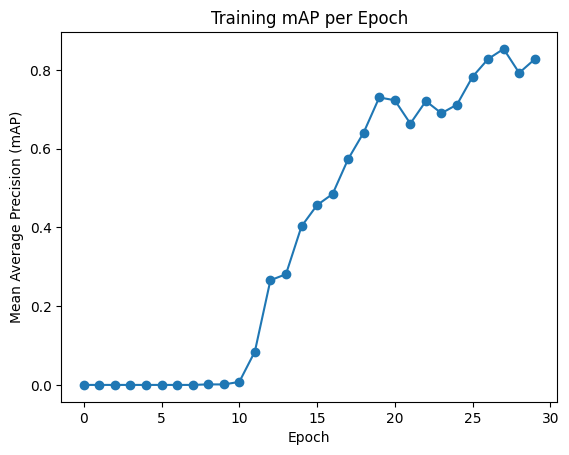

In [26]:
plt.plot(range(EPOCHS), train_mAPs, marker='o')
plt.title('Training mAP per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Average Precision (mAP)')
plt.show()

In [59]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size set to 1 for simplicity
model.eval()



Yolov1(
  (darknet): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
  

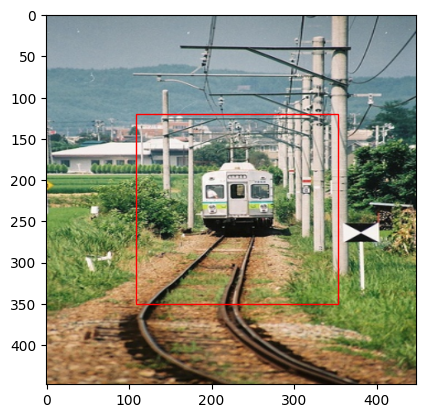

In [57]:
test_images, test_labels = next(iter(test_loader))
test_images = test_images.to(DEVICE)

with torch.no_grad():
    predictions = model(test_images)
    bboxes = cellboxes_to_boxes(predictions)  # Convert predictions to bounding box format
    bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")  # Apply NMS

# Assuming the `plot_image` function works similarly to your previous code
# Convert the image tensor format from (C, H, W) to (H, W, C) for plotting
image_to_plot = test_images[0].permute(1, 2, 0).cpu().numpy()
plot_image(image_to_plot, bboxes)  # Plot image with bounding boxes

In [54]:
!pip install torchsummary
from torchsummary import summary

In [28]:
summary(model.cuda(), (3, 448, 448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
         LeakyReLU-3         [-1, 64, 224, 224]               0
          CNNBlock-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 192, 112, 112]         110,592
       BatchNorm2d-7        [-1, 192, 112, 112]             384
         LeakyReLU-8        [-1, 192, 112, 112]               0
          CNNBlock-9        [-1, 192, 112, 112]               0
        MaxPool2d-10          [-1, 192, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]          24,576
      BatchNorm2d-12          [-1, 128, 56, 56]             256
        LeakyReLU-13          [-1, 128, 56, 56]               0
         CNNBlock-14          [-1, 128,

###Optimizer RMSE Prop

FOLD 0
--------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.68it/s, loss=141]

Mean loss was 1270.0919698079426


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.24it/s, loss=142]

Mean loss was 507.80122629801434


Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.56it/s, loss=14.8]

Mean loss was 382.6281795501709


Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.48it/s, loss=20.5]

Mean loss was 277.44308916727704


Validation mAP for epoch 3: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.79it/s, loss=29.5]

Mean loss was 222.7629248301188


Validation mAP for epoch 4: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.35it/s, loss=42.5]

Mean loss was 194.47847048441568


Validation mAP for epoch 5: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.97it/s, loss=9.2]

Mean loss was 184.29306920369467


Validation mAP for epoch 6: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.62it/s, loss=22]

Mean loss was 149.34672164916992


Validation mAP for epoch 7: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=13.4]

Mean loss was 130.64324601491293


Validation mAP for epoch 8: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.49it/s, loss=23.8]

Mean loss was 125.58028030395508


Validation mAP for epoch 9: 0.07706541940569878


100%|██████████| 6/6 [00:01<00:00,  5.78it/s, loss=24.3]

Mean loss was 151.3174203236898


Validation mAP for epoch 10: 0.019230742007493973


100%|██████████| 6/6 [00:01<00:00,  5.87it/s, loss=12.8]

Mean loss was 123.67520395914714


Validation mAP for epoch 11: 0.07706541940569878


100%|██████████| 6/6 [00:01<00:00,  5.79it/s, loss=30.8]

Mean loss was 107.33715597788493


Validation mAP for epoch 12: 0.0866665467619896


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=33.2]

Mean loss was 96.24174245198567


Validation mAP for epoch 13: 0.07707281783223152


100%|██████████| 6/6 [00:01<00:00,  3.36it/s, loss=12.5]

Mean loss was 94.87187163035075


Validation mAP for epoch 14: 0.07766273990273476


100%|██████████| 6/6 [00:01<00:00,  3.59it/s, loss=21.1]

Mean loss was 87.45022328694661


Validation mAP for epoch 15: 0.07731978967785835


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=17.9]

Mean loss was 78.86363220214844


Validation mAP for epoch 16: 0.07745715230703354


100%|██████████| 6/6 [00:01<00:00,  3.25it/s, loss=20.3]

Mean loss was 81.3728494644165


Validation mAP for epoch 17: 0.0774998888373375


100%|██████████| 6/6 [00:01<00:00,  5.83it/s, loss=31.2]

Mean loss was 83.50504684448242


Validation mAP for epoch 18: 0.077266376465559


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=16.1]

Mean loss was 104.17933050791423


Validation mAP for epoch 19: 0.08766013756394386


100%|██████████| 6/6 [00:01<00:00,  3.50it/s, loss=29.5]

Mean loss was 73.2656675974528


Validation mAP for epoch 20: 0.08269219473004341


100%|██████████| 6/6 [00:01<00:00,  5.77it/s, loss=13.4]

Mean loss was 66.76264429092407


Validation mAP for epoch 21: 0.08568364381790161


100%|██████████| 6/6 [00:01<00:00,  5.62it/s, loss=9.59]

Mean loss was 63.150401751200356


Validation mAP for epoch 22: 0.12051267176866531


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=8.36]

Mean loss was 86.57226832707723


Validation mAP for epoch 23: 0.13012804090976715


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=18.6]

Mean loss was 68.42859840393066


Validation mAP for epoch 24: 0.12051267176866531


100%|██████████| 6/6 [00:01<00:00,  3.15it/s, loss=7.38]

Mean loss was 66.53137811024983


Validation mAP for epoch 25: 0.14935880154371262


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=40.6]

Mean loss was 68.69042269388835


Validation mAP for epoch 26: 0.07564094662666321


100%|██████████| 6/6 [00:01<00:00,  3.32it/s, loss=9.77]

Mean loss was 71.42457246780396


Validation mAP for epoch 27: 0.08974348939955235


100%|██████████| 6/6 [00:00<00:00,  6.17it/s, loss=5.81]

Mean loss was 65.27757120132446


Validation mAP for epoch 28: 0.1271900162100792


100%|██████████| 6/6 [00:01<00:00,  5.73it/s, loss=11.7]

Mean loss was 62.10226853688558


Validation mAP for epoch 29: 0.0847221128642559


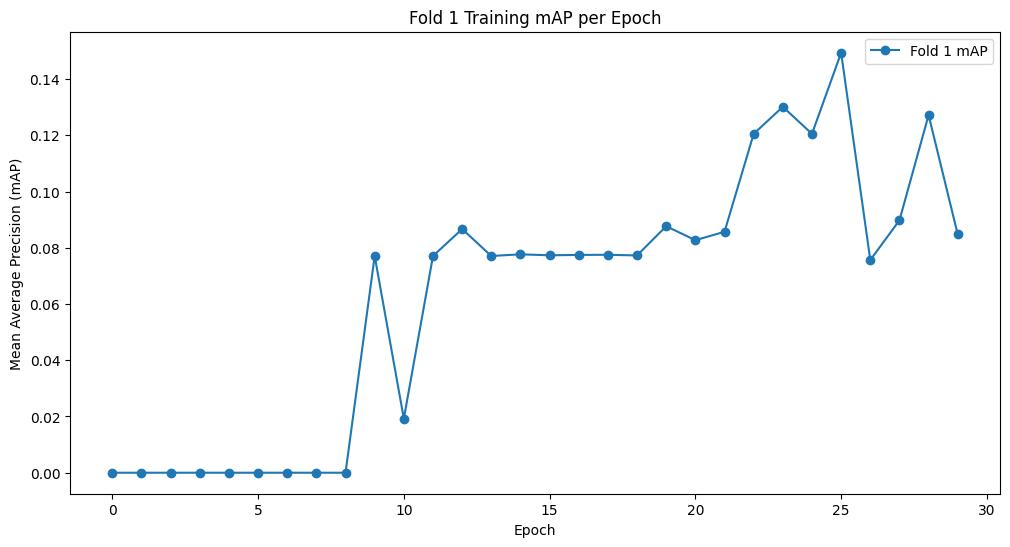

FOLD 1
--------------------------------


100%|██████████| 6/6 [00:01<00:00,  5.45it/s, loss=59]

Mean loss was 892.2322794596354


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.77it/s, loss=28.1]

Mean loss was 453.67560895284015


Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.56it/s, loss=38.5]

Mean loss was 319.49503326416016


Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=68.4]

Mean loss was 250.42322794596353


Validation mAP for epoch 3: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.76it/s, loss=30.9]

Mean loss was 203.60281976064047


Validation mAP for epoch 4: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.45it/s, loss=14.8]

Mean loss was 185.7901849746704


Validation mAP for epoch 5: 0.0


100%|██████████| 6/6 [00:01<00:00,  4.93it/s, loss=26.9]

Mean loss was 165.83881505330405


Validation mAP for epoch 6: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.62it/s, loss=17.9]


Mean loss was 152.6342887878418
Validation mAP for epoch 7: 0.010416659526526928


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=16.1]

Mean loss was 121.41309483846028


Validation mAP for epoch 8: 0.035394239239394665


100%|██████████| 6/6 [00:01<00:00,  5.81it/s, loss=15]

Mean loss was 111.60406716664632


Validation mAP for epoch 9: 0.030051500536501408


100%|██████████| 6/6 [00:01<00:00,  5.74it/s, loss=11.3]

Mean loss was 136.42428620656332


Validation mAP for epoch 10: 0.028711829334497452


100%|██████████| 6/6 [00:00<00:00,  6.17it/s, loss=21.9]

Mean loss was 106.37323252360027


Validation mAP for epoch 11: 0.0777117945253849


100%|██████████| 6/6 [00:01<00:00,  5.59it/s, loss=15.5]

Mean loss was 100.370987256368


Validation mAP for epoch 12: 0.1225932128727436


100%|██████████| 6/6 [00:01<00:00,  5.70it/s, loss=10.5]

Mean loss was 86.03103415171306


Validation mAP for epoch 13: 0.0629794504493475


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=8.16]

Mean loss was 82.56441593170166


Validation mAP for epoch 14: 0.0922819972038269


100%|██████████| 6/6 [00:01<00:00,  3.48it/s, loss=8.7]

Mean loss was 93.13686752319336


Validation mAP for epoch 15: 0.11782654747366905


100%|██████████| 6/6 [00:00<00:00,  6.35it/s, loss=21.3]

Mean loss was 79.2807108561198


Validation mAP for epoch 16: 0.08173556812107563


100%|██████████| 6/6 [00:01<00:00,  5.67it/s, loss=10.8]

Mean loss was 81.04791307449341


Validation mAP for epoch 17: 0.09840383380651474


100%|██████████| 6/6 [00:01<00:00,  5.90it/s, loss=18.7]

Mean loss was 68.9138552347819


Validation mAP for epoch 18: 0.11136867851018906


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=10.2]


Mean loss was 66.25584443410237
Validation mAP for epoch 19: 0.11030789092183113


100%|██████████| 6/6 [00:01<00:00,  3.85it/s, loss=8.5]

Mean loss was 65.5468996365865


Validation mAP for epoch 20: 0.08684248477220535


100%|██████████| 6/6 [00:01<00:00,  3.45it/s, loss=10.4]

Mean loss was 75.36149883270264


Validation mAP for epoch 21: 0.05998433195054531


100%|██████████| 6/6 [00:01<00:00,  5.59it/s, loss=33.1]

Mean loss was 110.67599995930989


Validation mAP for epoch 22: 0.05914799124002457


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=30.6]

Mean loss was 73.43628438313802


Validation mAP for epoch 23: 0.11026677116751671


100%|██████████| 6/6 [00:01<00:00,  3.36it/s, loss=10.3]

Mean loss was 65.0500431060791


Validation mAP for epoch 24: 0.15446948260068893


100%|██████████| 6/6 [00:01<00:00,  3.46it/s, loss=5.25]

Mean loss was 49.43471415837606


Validation mAP for epoch 25: 0.10868765041232109


100%|██████████| 6/6 [00:01<00:00,  5.67it/s, loss=6.66]

Mean loss was 50.52876297632853


Validation mAP for epoch 26: 0.06555455178022385


100%|██████████| 6/6 [00:01<00:00,  5.83it/s, loss=20.1]

Mean loss was 57.546383221944176


Validation mAP for epoch 27: 0.0798628143966198


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=11.8]

Mean loss was 57.686559200286865


Validation mAP for epoch 28: 0.12420505657792091


100%|██████████| 6/6 [00:01<00:00,  5.76it/s, loss=30]

Mean loss was 53.4521214167277


Validation mAP for epoch 29: 0.12420571967959404


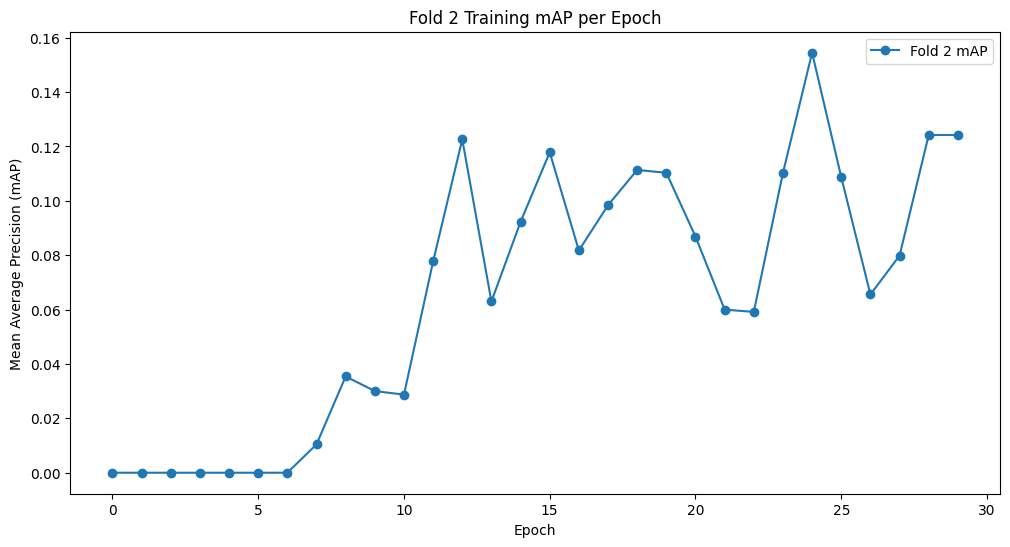

FOLD 2
--------------------------------


100%|██████████| 6/6 [00:01<00:00,  5.45it/s, loss=85.8]

Mean loss was 1233.8190854390461


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.63it/s, loss=64.3]


Mean loss was 453.2472674051921
Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.81it/s, loss=37.1]

Mean loss was 330.77956136067706


Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.74it/s, loss=73.7]

Mean loss was 263.6978225708008


Validation mAP for epoch 3: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.30it/s, loss=16.4]

Mean loss was 219.56392447153726


Validation mAP for epoch 4: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.49it/s, loss=25.3]

Mean loss was 189.0840244293213


Validation mAP for epoch 5: 0.007211532210931182


100%|██████████| 6/6 [00:01<00:00,  5.70it/s, loss=45.1]

Mean loss was 170.64381408691406


Validation mAP for epoch 6: 0.005917156580835581


100%|██████████| 6/6 [00:01<00:00,  5.74it/s, loss=9.13]

Mean loss was 168.75895388921103


Validation mAP for epoch 7: 0.00801281351596117


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=24.3]

Mean loss was 148.04262193044028


Validation mAP for epoch 8: 0.004684415878728032


100%|██████████| 6/6 [00:01<00:00,  5.70it/s, loss=43.6]

Mean loss was 160.9372762044271


Validation mAP for epoch 9: 0.0029585782904177904


100%|██████████| 6/6 [00:01<00:00,  3.10it/s, loss=31.6]

Mean loss was 139.7813959121704


Validation mAP for epoch 10: 0.11809654533863068


100%|██████████| 6/6 [00:03<00:00,  1.66it/s, loss=23.8]

Mean loss was 113.41941324869792


Validation mAP for epoch 11: 0.05617774836719036


100%|██████████| 6/6 [00:01<00:00,  5.68it/s, loss=8.08]

Mean loss was 113.42460600535075


Validation mAP for epoch 12: 0.037327385507524014


100%|██████████| 6/6 [00:01<00:00,  5.73it/s, loss=16.2]

Mean loss was 122.95607312520345


Validation mAP for epoch 13: 0.06464491039514542


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=34.7]

Mean loss was 116.8240286509196


Validation mAP for epoch 14: 0.04835928976535797


100%|██████████| 6/6 [00:01<00:00,  5.69it/s, loss=16.7]


Mean loss was 109.92640495300293
Validation mAP for epoch 15: 0.12820501625537872


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=12.2]

Mean loss was 97.27915445963542


Validation mAP for epoch 16: 0.13412216305732727


100%|██████████| 6/6 [00:01<00:00,  3.34it/s, loss=23.3]

Mean loss was 83.43675359090169


Validation mAP for epoch 17: 0.13831348717212677


100%|██████████| 6/6 [00:01<00:00,  5.86it/s, loss=12.3]

Mean loss was 76.75814151763916


Validation mAP for epoch 18: 0.12450679019093513


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=13.3]

Mean loss was 71.9185603459676


Validation mAP for epoch 19: 0.08349761739373207


100%|██████████| 6/6 [00:01<00:00,  5.67it/s, loss=7.02]

Mean loss was 68.49412822723389


Validation mAP for epoch 20: 0.1138230450451374


100%|██████████| 6/6 [00:01<00:00,  5.80it/s, loss=12.8]

Mean loss was 78.22670427958171


Validation mAP for epoch 21: 0.13946405053138733


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=5.56]

Mean loss was 65.16629020373027


Validation mAP for epoch 22: 0.13634932786226273


100%|██████████| 6/6 [00:01<00:00,  3.17it/s, loss=25.7]

Mean loss was 63.831250508626304


Validation mAP for epoch 23: 0.1383378729224205


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=23.7]

Mean loss was 63.52077007293701


Validation mAP for epoch 24: 0.15335293114185333


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=27.7]

Mean loss was 67.17113049825032


Validation mAP for epoch 25: 0.1485041379928589


100%|██████████| 6/6 [00:02<00:00,  2.22it/s, loss=12.2]

Mean loss was 61.92050758997599


Validation mAP for epoch 26: 0.1358480080962181


100%|██████████| 6/6 [00:01<00:00,  3.24it/s, loss=15.6]

Mean loss was 65.30681784947713


Validation mAP for epoch 27: 0.08700933307409286


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=10.7]

Mean loss was 89.85625902811687


Validation mAP for epoch 28: 0.13412216305732727


100%|██████████| 6/6 [00:01<00:00,  3.22it/s, loss=25.9]

Mean loss was 94.43197886149089


Validation mAP for epoch 29: 0.11220582574605942


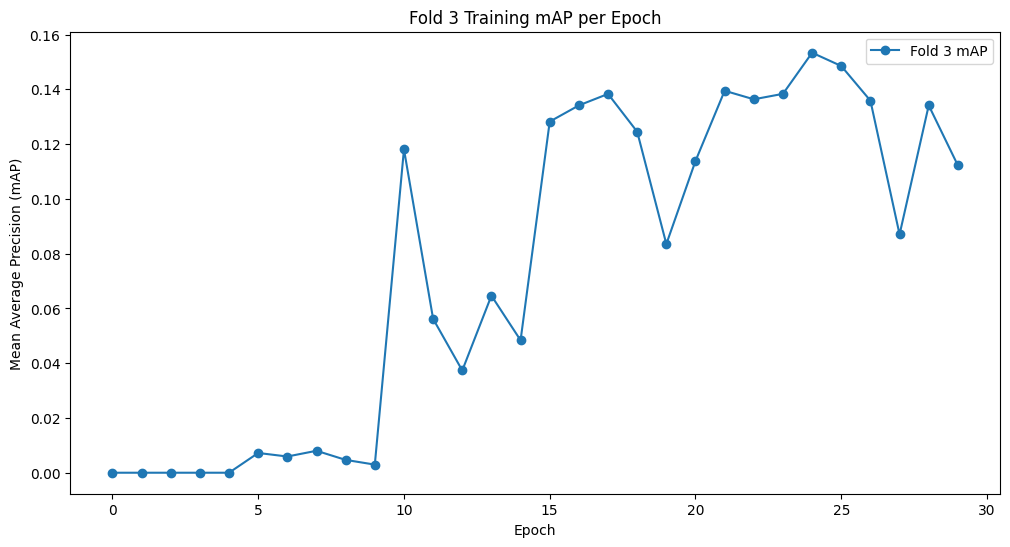

FOLD 3
--------------------------------


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=91.3]

Mean loss was 1051.5042241414387


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.80it/s, loss=29.7]

Mean loss was 576.1695709228516


Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.61it/s, loss=42.7]

Mean loss was 301.94266001383465


Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.29it/s, loss=60.5]

Mean loss was 241.5382391611735


Validation mAP for epoch 3: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.57it/s, loss=30]

Mean loss was 196.0301030476888


Validation mAP for epoch 4: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.95it/s, loss=24.9]

Mean loss was 166.5605494181315


Validation mAP for epoch 5: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.55it/s, loss=35.7]

Mean loss was 144.9105428059896


Validation mAP for epoch 6: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.31it/s, loss=27.6]

Mean loss was 124.31846491495769


Validation mAP for epoch 7: 0.017361087258905172


100%|██████████| 6/6 [00:01<00:00,  3.82it/s, loss=19.2]

Mean loss was 125.68684228261311


Validation mAP for epoch 8: 0.0011574068776099011


100%|██████████| 6/6 [00:01<00:00,  5.83it/s, loss=23.3]

Mean loss was 116.50012683868408


Validation mAP for epoch 9: 0.043518454709555954


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=17.1]

Mean loss was 107.441419283549


Validation mAP for epoch 10: 0.012268503138329834


100%|██████████| 6/6 [00:02<00:00,  2.99it/s, loss=32.5]

Mean loss was 95.08230082194011


Validation mAP for epoch 11: 0.0001322751195402816


100%|██████████| 6/6 [00:01<00:00,  3.56it/s, loss=16.3]


Mean loss was 95.67671712239583
Validation mAP for epoch 12: 0.015084860380738974


100%|██████████| 6/6 [00:01<00:00,  5.69it/s, loss=35.9]

Mean loss was 93.65410868326823


Validation mAP for epoch 13: 0.011111096478998661


100%|██████████| 6/6 [00:02<00:00,  2.94it/s, loss=19.1]

Mean loss was 82.75078614552815


Validation mAP for epoch 14: 0.020042127929627895


100%|██████████| 6/6 [00:01<00:00,  5.69it/s, loss=16.5]

Mean loss was 88.64510313669841


Validation mAP for epoch 15: 0.10239815711975098


100%|██████████| 6/6 [00:00<00:00,  6.37it/s, loss=16.9]

Mean loss was 88.25916894276936


Validation mAP for epoch 16: 0.03280149772763252


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=38.8]

Mean loss was 86.29211107889812


Validation mAP for epoch 17: 0.014413567259907722


100%|██████████| 6/6 [00:01<00:00,  3.76it/s, loss=36]

Mean loss was 78.50504366556804


Validation mAP for epoch 18: 0.042671557515859604


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=15.8]

Mean loss was 71.8592300415039


Validation mAP for epoch 19: 0.08772203885018826


100%|██████████| 6/6 [00:01<00:00,  3.03it/s, loss=27.4]


Mean loss was 65.62463124593098
Validation mAP for epoch 20: 0.05930560082197189


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=26.4]

Mean loss was 62.10173988342285


Validation mAP for epoch 21: 0.11974338442087173


100%|██████████| 6/6 [00:01<00:00,  5.79it/s, loss=9.77]

Mean loss was 59.743343353271484


Validation mAP for epoch 22: 0.12187044695019722


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=27.4]


Mean loss was 81.4218635559082
Validation mAP for epoch 23: 0.07759915851056576


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=52.8]


Mean loss was 79.55467096964519
Validation mAP for epoch 24: 0.09058137238025665


100%|██████████| 6/6 [00:01<00:00,  3.51it/s, loss=20.4]

Mean loss was 75.65976397196452


Validation mAP for epoch 25: 0.11930688098073006


100%|██████████| 6/6 [00:02<00:00,  2.49it/s, loss=21.8]


Mean loss was 55.32748667399088
Validation mAP for epoch 26: 0.047307610511779785


100%|██████████| 6/6 [00:01<00:00,  3.54it/s, loss=53.4]


Mean loss was 61.46439297993978
Validation mAP for epoch 27: 0.12455213814973831


100%|██████████| 6/6 [00:01<00:00,  5.72it/s, loss=10.8]


Mean loss was 55.24890677134196
Validation mAP for epoch 28: 0.12051473185420036


100%|██████████| 6/6 [00:01<00:00,  5.69it/s, loss=26.4]

Mean loss was 50.26371065775553


Validation mAP for epoch 29: 0.13387605547904968


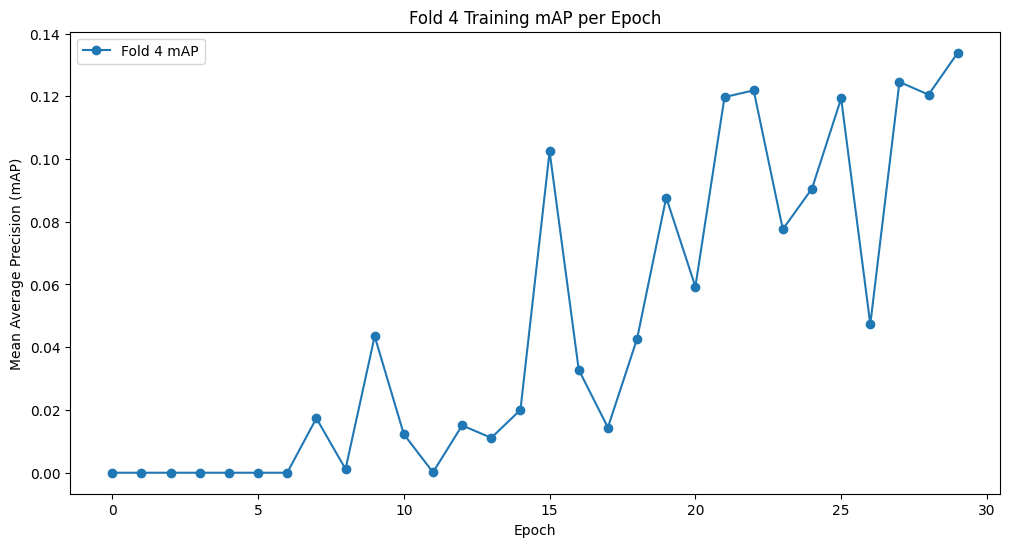

FOLD 4
--------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.13it/s, loss=77.5]


Mean loss was 1097.9306615193684
Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.30it/s, loss=131]


Mean loss was 522.8269449869791
Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.49it/s, loss=72.4]

Mean loss was 358.8396504720052


Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.79it/s, loss=49.4]

Mean loss was 289.37487030029297


Validation mAP for epoch 3: 0.001174241944681853


100%|██████████| 6/6 [00:01<00:00,  5.76it/s, loss=98.9]

Mean loss was 236.79217910766602


Validation mAP for epoch 4: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.97it/s, loss=60.1]


Mean loss was 194.13905970255533
Validation mAP for epoch 5: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.42it/s, loss=23.6]

Mean loss was 178.44641208648682


Validation mAP for epoch 6: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.52it/s, loss=55]


Mean loss was 176.97103627522787
Validation mAP for epoch 7: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.16it/s, loss=30]

Mean loss was 155.11932563781738


Validation mAP for epoch 8: 0.03749996144324541


100%|██████████| 6/6 [00:01<00:00,  3.48it/s, loss=36.6]


Mean loss was 150.2715276082357
Validation mAP for epoch 9: 0.1136903390288353


100%|██████████| 6/6 [00:00<00:00,  6.24it/s, loss=29.4]


Mean loss was 137.76043128967285
Validation mAP for epoch 10: 0.0519047100096941


100%|██████████| 6/6 [00:01<00:00,  5.67it/s, loss=48.7]


Mean loss was 123.14962514241536
Validation mAP for epoch 11: 0.16428551077842712


100%|██████████| 6/6 [00:01<00:00,  3.66it/s, loss=35.8]

Mean loss was 122.34321784973145


Validation mAP for epoch 12: 0.05238090083003044


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=26.2]


Mean loss was 109.25979359944661
Validation mAP for epoch 13: 0.1520831435918808


100%|██████████| 6/6 [00:01<00:00,  5.74it/s, loss=40.5]


Mean loss was 109.78620910644531
Validation mAP for epoch 14: 0.08928562700748444


100%|██████████| 6/6 [00:01<00:00,  3.62it/s, loss=22.5]

Mean loss was 115.58864974975586


Validation mAP for epoch 15: 0.1581580713391304


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=25.2]

Mean loss was 106.18196201324463


Validation mAP for epoch 16: 0.16428551077842712


100%|██████████| 6/6 [00:01<00:00,  3.65it/s, loss=18.9]

Mean loss was 97.06908353169759


Validation mAP for epoch 17: 0.1755950227379799


100%|██████████| 6/6 [00:01<00:00,  3.26it/s, loss=17.6]

Mean loss was 90.77414925893147


Validation mAP for epoch 18: 0.18863073736429214


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=27.4]

Mean loss was 89.12640317281087


Validation mAP for epoch 19: 0.18169621378183365


100%|██████████| 6/6 [00:01<00:00,  5.72it/s, loss=25.7]


Mean loss was 83.40174865722656
Validation mAP for epoch 20: 0.16815456748008728


100%|██████████| 6/6 [00:00<00:00,  6.30it/s, loss=26.8]

Mean loss was 107.2459643681844


Validation mAP for epoch 21: 0.1785712093114853


100%|██████████| 6/6 [00:01<00:00,  3.50it/s, loss=36.2]


Mean loss was 77.09063402811687
Validation mAP for epoch 22: 0.16190455853939056


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=9.64]

Mean loss was 70.75491778055827


Validation mAP for epoch 23: 0.17023788392543793


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=33.5]

Mean loss was 72.42677815755208


Validation mAP for epoch 24: 0.13273793831467628


100%|██████████| 6/6 [00:01<00:00,  5.55it/s, loss=13.2]

Mean loss was 70.9155101776123


Validation mAP for epoch 25: 0.1785712093114853


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=41.4]

Mean loss was 70.32732645670573


Validation mAP for epoch 26: 0.1785712093114853


100%|██████████| 6/6 [00:01<00:00,  3.35it/s, loss=43.6]

Mean loss was 72.92787170410156


Validation mAP for epoch 27: 0.1785712093114853


100%|██████████| 6/6 [00:01<00:00,  3.92it/s, loss=15.7]

Mean loss was 71.14198239644368


Validation mAP for epoch 28: 0.1785712093114853


100%|██████████| 6/6 [00:01<00:00,  5.46it/s, loss=14.3]


Mean loss was 66.51847807566325
Validation mAP for epoch 29: 0.1726188361644745


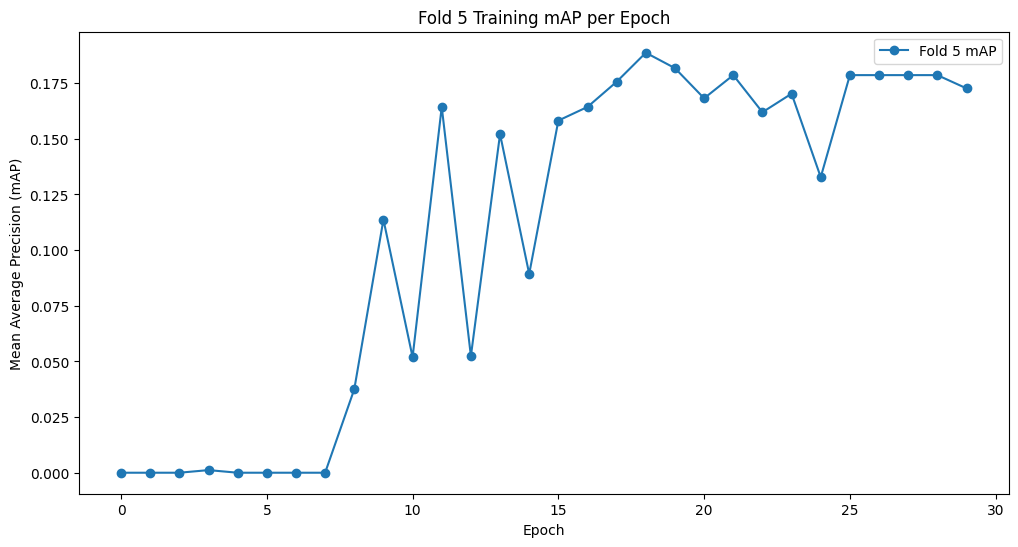

Average Validation mAP across all folds: 0.12552570998668672


In [31]:
train_dataset = VOCDataset(
    "100examples.csv",
    transform=transform,
    img_dir=IMG_DIR,
    label_dir=LABEL_DIR,
)

test_dataset = VOCDataset(
    "test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
)

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=seed)
fold_results = []

# Collect the fold performance for plotting
fold_performance_history = []

for fold, (train_ids, valid_ids) in enumerate(kf.split(np.arange(len(train_dataset)))):
    print(f'FOLD {fold}')
    print('--------------------------------')

    fold_epoch_mAPs = []

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = SubsetRandomSampler(train_ids)
    valid_subsampler = SubsetRandomSampler(valid_ids)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    valid_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    # Initialize the model and optimizer for this fold
    model_RMSP = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.RMSprop(model_RMSP.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)  # Updated to RMSprop
    loss_fn = YoloLoss().to(DEVICE)


    for epoch in range(EPOCHS):

        # Train for one epoch
        train_fn(train_loader, model_RMSP, optimizer, loss_fn)

        # Evaluate after the epoch
        valid_mAPs = []
        model_RMSP.eval()
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(valid_loader):
                x, y = x.to(DEVICE), y.to(DEVICE)
                predictions = model_RMSP(x)
                # Calculate mAP
                pred_boxes, target_boxes = get_bboxes(valid_loader, model_RMSP, iou_threshold=0.5, threshold=0.4)
                valid_mAP = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
                valid_mAPs.append(valid_mAP.item())

        # Calculate average mAP for the validation set
        avg_valid_mAP = sum(valid_mAPs) / len(valid_mAPs)
        print(f"Validation mAP for epoch {epoch}: {avg_valid_mAP}")

        fold_epoch_mAPs.append(avg_valid_mAP)



        model.train()

    fold_results.append(avg_valid_mAP)

    plt.figure(figsize=(12, 6))
    plt.plot(range(EPOCHS), fold_epoch_mAPs, marker='o', label=f'Fold {fold+1} mAP')
    plt.title(f'Fold {fold+1} Training mAP per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Average Precision (mAP)')
    plt.legend()
    plt.show()

    fold_results.append(fold_epoch_mAPs[-1])


average_performance = sum(fold_results) / len(fold_results)
print(f'Average Validation mAP across all folds: {average_performance}')


###ADAM Optimizer

FOLD 0
--------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.98it/s, loss=57.7]

Mean loss was 836.1595592498779


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.22it/s, loss=155]

Mean loss was 538.9920374552408


Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.60it/s, loss=53.7]


Mean loss was 429.5723679860433
Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=34.6]

Mean loss was 355.10939598083496


Validation mAP for epoch 3: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.35it/s, loss=58.5]

Mean loss was 298.5277271270752


Validation mAP for epoch 4: 0.0017011825693771243


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=18.3]


Mean loss was 256.90092913309735
Validation mAP for epoch 5: 0.0010817301517818123


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=77.3]

Mean loss was 230.27750396728516


Validation mAP for epoch 6: 0.0015609381953254342


100%|██████████| 6/6 [00:02<00:00,  2.16it/s, loss=20.7]

Mean loss was 199.62759844462076


Validation mAP for epoch 7: 0.001923075644299388


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=17]

Mean loss was 181.31187438964844


Validation mAP for epoch 8: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.33it/s, loss=39.2]

Mean loss was 164.12643814086914


Validation mAP for epoch 9: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.74it/s, loss=26.9]


Mean loss was 141.4897403717041
Validation mAP for epoch 10: 0.00480768783017993


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=13]


Mean loss was 136.49607435862222
Validation mAP for epoch 11: 0.016185879707336426


100%|██████████| 6/6 [00:01<00:00,  3.29it/s, loss=19]

Mean loss was 120.5576737721761


Validation mAP for epoch 12: 0.019230742007493973


100%|██████████| 6/6 [00:01<00:00,  5.75it/s, loss=15.7]

Mean loss was 109.62525860468547


Validation mAP for epoch 13: 0.07716772332787514


100%|██████████| 6/6 [00:01<00:00,  3.73it/s, loss=11]

Mean loss was 108.28479607899983


Validation mAP for epoch 14: 0.07723525539040565


100%|██████████| 6/6 [00:02<00:00,  2.17it/s, loss=14.8]


Mean loss was 92.74307346343994
Validation mAP for epoch 15: 0.07735031098127365


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=12.6]


Mean loss was 86.62607479095459
Validation mAP for epoch 16: 0.07820501923561096


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=8.23]

Mean loss was 81.89679447809856


Validation mAP for epoch 17: 0.10523491352796555


100%|██████████| 6/6 [00:01<00:00,  3.27it/s, loss=31.6]

Mean loss was 77.08350880940755


Validation mAP for epoch 18: 0.082799032330513


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=12.7]

Mean loss was 73.6041825612386


Validation mAP for epoch 19: 0.12532035261392593


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=11.9]


Mean loss was 69.73870817820232
Validation mAP for epoch 20: 0.09006397798657417


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=16.1]


Mean loss was 60.82480716705322
Validation mAP for epoch 21: 0.11634600535035133


100%|██████████| 6/6 [00:01<00:00,  3.62it/s, loss=14.3]

Mean loss was 62.41984669367472


Validation mAP for epoch 22: 0.13974342122673988


100%|██████████| 6/6 [00:01<00:00,  3.29it/s, loss=15.9]


Mean loss was 58.911917527516685
Validation mAP for epoch 23: 0.12606821954250336


100%|██████████| 6/6 [00:01<00:00,  3.42it/s, loss=98.5]


Mean loss was 73.878355662028
Validation mAP for epoch 24: 0.1426280178129673


100%|██████████| 6/6 [00:01<00:00,  5.62it/s, loss=16.6]

Mean loss was 60.13633791605631


Validation mAP for epoch 25: 0.1166665181517601


100%|██████████| 6/6 [00:00<00:00,  6.20it/s, loss=29.1]

Mean loss was 58.605482737223305


Validation mAP for epoch 26: 0.09705115109682083


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=13.8]

Mean loss was 56.214345932006836


Validation mAP for epoch 27: 0.1166665181517601


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=27.4]


Mean loss was 57.46763674418131
Validation mAP for epoch 28: 0.11837592348456383


100%|██████████| 6/6 [00:02<00:00,  2.84it/s, loss=9.57]


Mean loss was 58.690265814463295
Validation mAP for epoch 29: 0.1285254806280136


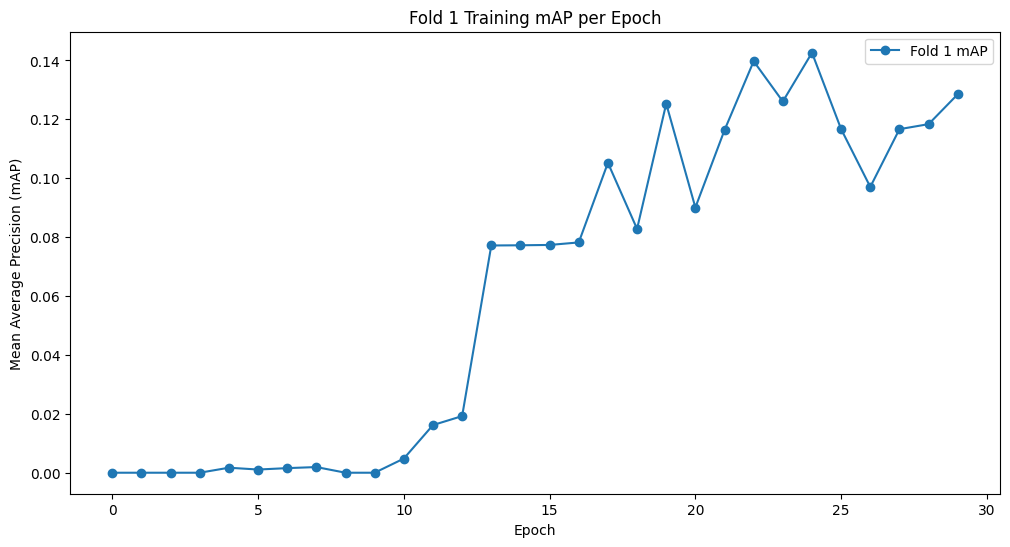

FOLD 1
--------------------------------


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=71.3]

Mean loss was 783.2297592163086


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.74it/s, loss=29.4]

Mean loss was 445.3381579717


Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.50it/s, loss=80.3]


Mean loss was 356.23545837402344
Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.26it/s, loss=21.7]

Mean loss was 294.38276354471844


Validation mAP for epoch 3: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.63it/s, loss=23.3]

Mean loss was 250.86628119150797


Validation mAP for epoch 4: 0.0


100%|██████████| 6/6 [00:01<00:00,  4.65it/s, loss=13.2]


Mean loss was 211.5681994756063
Validation mAP for epoch 5: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.45it/s, loss=31]


Mean loss was 201.63503901163736
Validation mAP for epoch 6: 0.0013440853217616677


100%|██████████| 6/6 [00:01<00:00,  3.25it/s, loss=21.7]


Mean loss was 166.8768679300944
Validation mAP for epoch 7: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=10]


Mean loss was 155.77406946818033
Validation mAP for epoch 8: 0.00014510017354041338


100%|██████████| 6/6 [00:03<00:00,  1.74it/s, loss=48.7]

Mean loss was 135.29041290283203


Validation mAP for epoch 9: 0.021670171059668064


100%|██████████| 6/6 [00:01<00:00,  5.62it/s, loss=27.7]


Mean loss was 119.80305703481038
Validation mAP for epoch 10: 0.06978040933609009


100%|██████████| 6/6 [00:01<00:00,  3.66it/s, loss=41.2]

Mean loss was 113.46561813354492


Validation mAP for epoch 11: 0.04917111061513424


100%|██████████| 6/6 [00:01<00:00,  5.56it/s, loss=6.01]

Mean loss was 107.97428560256958


Validation mAP for epoch 12: 0.05005596578121185


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=14.3]

Mean loss was 91.73349682490031


Validation mAP for epoch 13: 0.09442196041345596


100%|██████████| 6/6 [00:01<00:00,  5.58it/s, loss=29.8]

Mean loss was 90.60574913024902


Validation mAP for epoch 14: 0.07863624952733517


100%|██████████| 6/6 [00:01<00:00,  3.08it/s, loss=31.4]

Mean loss was 80.31589190165202


Validation mAP for epoch 15: 0.10237447172403336


100%|██████████| 6/6 [00:01<00:00,  3.29it/s, loss=17.8]


Mean loss was 72.11993058522542
Validation mAP for epoch 16: 0.05868137627840042


100%|██████████| 6/6 [00:01<00:00,  5.71it/s, loss=38.3]

Mean loss was 75.2059555053711


Validation mAP for epoch 17: 0.05923681519925594


100%|██████████| 6/6 [00:01<00:00,  3.36it/s, loss=5.75]

Mean loss was 67.88990656534831


Validation mAP for epoch 18: 0.08371995016932487


100%|██████████| 6/6 [00:01<00:00,  5.57it/s, loss=15.2]


Mean loss was 68.96201006571452
Validation mAP for epoch 19: 0.10560162365436554


100%|██████████| 6/6 [00:02<00:00,  2.86it/s, loss=13.6]


Mean loss was 66.86509545644124
Validation mAP for epoch 20: 0.1066703237593174


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=9.96]

Mean loss was 64.56469217936198


Validation mAP for epoch 21: 0.10790817812085152


100%|██████████| 6/6 [00:01<00:00,  3.46it/s, loss=15.4]

Mean loss was 63.46715450286865


Validation mAP for epoch 22: 0.10614405944943428


100%|██████████| 6/6 [00:01<00:00,  5.70it/s, loss=7.55]


Mean loss was 54.64585200945536
Validation mAP for epoch 23: 0.10954104736447334


100%|██████████| 6/6 [00:01<00:00,  5.67it/s, loss=13.1]

Mean loss was 58.68504158655802


Validation mAP for epoch 24: 0.1045541800558567


100%|██████████| 6/6 [00:01<00:00,  3.45it/s, loss=15.5]


Mean loss was 56.631043116251625
Validation mAP for epoch 25: 0.12706941738724709


100%|██████████| 6/6 [00:01<00:00,  5.72it/s, loss=68.9]

Mean loss was 57.0564390818278


Validation mAP for epoch 26: 0.10851790010929108


100%|██████████| 6/6 [00:01<00:00,  5.52it/s, loss=16.7]

Mean loss was 52.04836368560791


Validation mAP for epoch 27: 0.10918490961194038


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=9.19]


Mean loss was 50.542598724365234
Validation mAP for epoch 28: 0.12377789244055748


100%|██████████| 6/6 [00:01<00:00,  5.11it/s, loss=7.01]


Mean loss was 45.06063334147135
Validation mAP for epoch 29: 0.10973941162228584


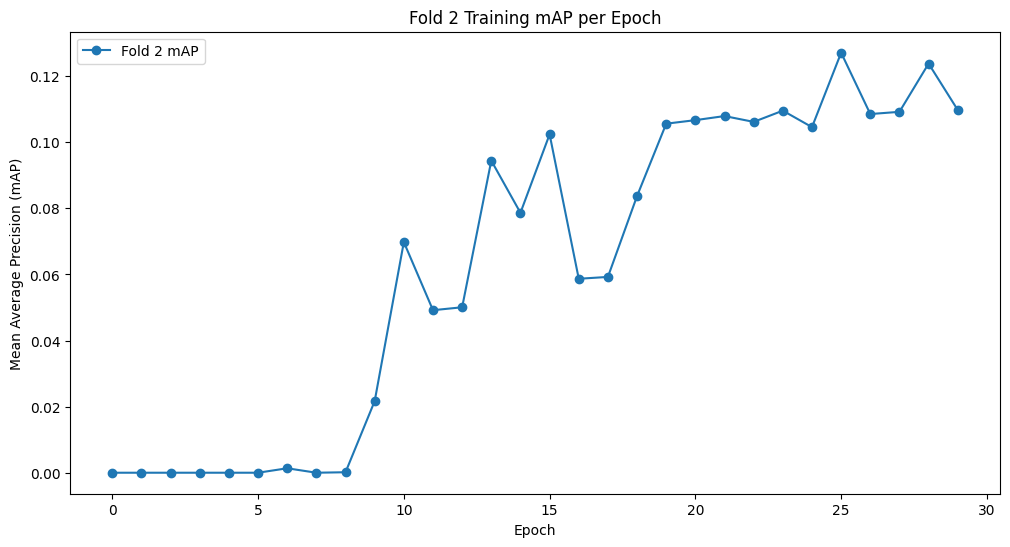

FOLD 2
--------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.66it/s, loss=43.4]

Mean loss was 854.462900797526


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=28.3]


Mean loss was 547.5595823923746
Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.22it/s, loss=21.8]

Mean loss was 422.2060645421346


Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.48it/s, loss=95.4]

Mean loss was 364.4344075520833


Validation mAP for epoch 3: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.42it/s, loss=34.9]

Mean loss was 312.67694155375165


Validation mAP for epoch 4: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.88it/s, loss=61.7]


Mean loss was 264.90243403116864
Validation mAP for epoch 5: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.64it/s, loss=79.1]

Mean loss was 232.7157185872396


Validation mAP for epoch 6: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.18it/s, loss=25.2]


Mean loss was 210.51867834726968
Validation mAP for epoch 7: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.83it/s, loss=19.8]


Mean loss was 182.8194341659546
Validation mAP for epoch 8: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=29.8]

Mean loss was 164.43549791971842


Validation mAP for epoch 9: 0.0007396445726044476


100%|██████████| 6/6 [00:01<00:00,  5.57it/s, loss=31.9]


Mean loss was 145.95321973164877
Validation mAP for epoch 10: 0.0009861928410828114


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=57.7]

Mean loss was 133.39302825927734


Validation mAP for epoch 11: 0.009023662656545639


100%|██████████| 6/6 [00:01<00:00,  5.51it/s, loss=22.5]


Mean loss was 130.92042223612467
Validation mAP for epoch 12: 0.045652493834495544


100%|██████████| 6/6 [00:01<00:00,  5.38it/s, loss=28.7]


Mean loss was 118.01730092366536
Validation mAP for epoch 13: 0.05571987293660641


100%|██████████| 6/6 [00:02<00:00,  2.68it/s, loss=39.9]

Mean loss was 107.98176574707031


Validation mAP for epoch 14: 0.07470408082008362


100%|██████████| 6/6 [00:01<00:00,  5.39it/s, loss=26.2]


Mean loss was 108.75981839497884
Validation mAP for epoch 15: 0.09341707825660706


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=7.48]

Mean loss was 96.4296326637268


Validation mAP for epoch 16: 0.11506517976522446


100%|██████████| 6/6 [00:01<00:00,  3.64it/s, loss=25.6]

Mean loss was 93.52389907836914


Validation mAP for epoch 17: 0.11649398133158684


100%|██████████| 6/6 [00:01<00:00,  3.27it/s, loss=8.93]


Mean loss was 84.36516793568929
Validation mAP for epoch 18: 0.1181211993098259


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=10.6]

Mean loss was 94.88772805531819


Validation mAP for epoch 19: 0.10971391201019287


100%|██████████| 6/6 [00:01<00:00,  5.56it/s, loss=14.1]

Mean loss was 76.34269746144612


Validation mAP for epoch 20: 0.11612416058778763


100%|██████████| 6/6 [00:01<00:00,  4.54it/s, loss=33.3]

Mean loss was 71.33841705322266


Validation mAP for epoch 21: 0.11735690012574196


100%|██████████| 6/6 [00:01<00:00,  5.54it/s, loss=57.1]

Mean loss was 69.16505686442058


Validation mAP for epoch 22: 0.11735690012574196


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=28.8]

Mean loss was 66.62882232666016


Validation mAP for epoch 23: 0.10749498009681702


100%|██████████| 6/6 [00:01<00:00,  3.14it/s, loss=9.59]

Mean loss was 68.76947561899821


Validation mAP for epoch 24: 0.11735690012574196


100%|██████████| 6/6 [00:01<00:00,  3.49it/s, loss=54.9]

Mean loss was 60.78125317891439


Validation mAP for epoch 25: 0.13227306306362152


100%|██████████| 6/6 [00:01<00:00,  5.50it/s, loss=21.7]


Mean loss was 73.09838962554932
Validation mAP for epoch 26: 0.1523667350411415


100%|██████████| 6/6 [00:01<00:00,  4.61it/s, loss=20.5]


Mean loss was 59.24235471089681
Validation mAP for epoch 27: 0.1272188238799572


100%|██████████| 6/6 [00:01<00:00,  5.67it/s, loss=4.71]


Mean loss was 58.624643643697105
Validation mAP for epoch 28: 0.16222865134477615


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=12.9]

Mean loss was 55.494880040486656


Validation mAP for epoch 29: 0.16176020354032516


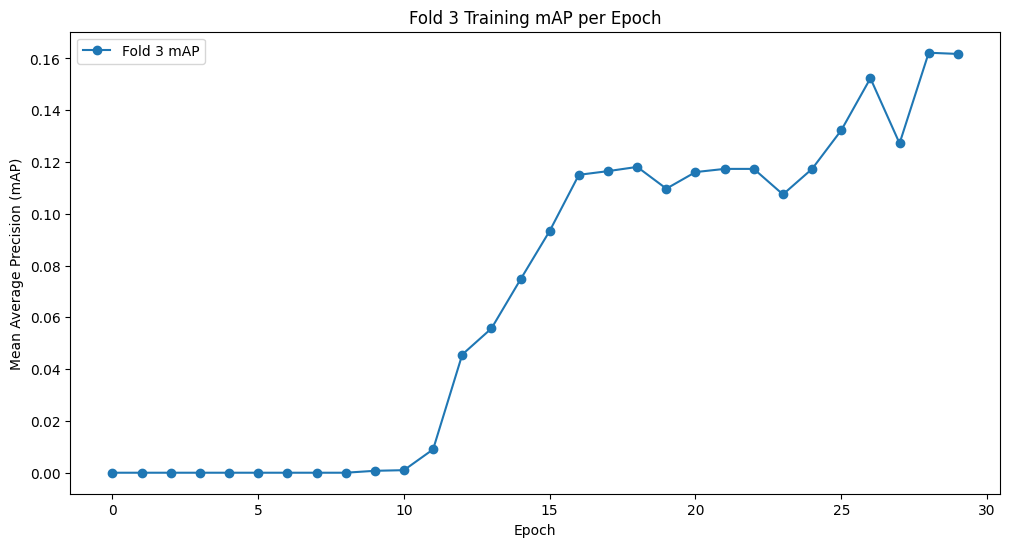

FOLD 3
--------------------------------


100%|██████████| 6/6 [00:00<00:00,  6.06it/s, loss=118]

Mean loss was 761.6681315104166


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.87it/s, loss=246]

Mean loss was 467.5311330159505


Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.57it/s, loss=105]


Mean loss was 381.83431752522785
Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=29.8]

Mean loss was 321.7116889953613


Validation mAP for epoch 3: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.60it/s, loss=91.1]

Mean loss was 265.6836700439453


Validation mAP for epoch 4: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.69it/s, loss=23.1]


Mean loss was 230.74702072143555
Validation mAP for epoch 5: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=23.9]

Mean loss was 194.13292344411215


Validation mAP for epoch 6: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.60it/s, loss=24.5]

Mean loss was 169.1055113474528


Validation mAP for epoch 7: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.33it/s, loss=25.8]

Mean loss was 161.38744195302328


Validation mAP for epoch 8: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=41.6]

Mean loss was 138.3491636912028


Validation mAP for epoch 9: 0.052083260379731655


100%|██████████| 6/6 [00:01<00:00,  5.63it/s, loss=40.9]


Mean loss was 129.4349454243978
Validation mAP for epoch 10: 0.08356469869613647


100%|██████████| 6/6 [00:00<00:00,  6.17it/s, loss=55.9]

Mean loss was 121.29875246683757


Validation mAP for epoch 11: 0.0037422812019940466


100%|██████████| 6/6 [00:01<00:00,  3.35it/s, loss=60.4]

Mean loss was 110.11386617024739


Validation mAP for epoch 12: 0.0023148133404902183


100%|██████████| 6/6 [00:01<00:00,  5.04it/s, loss=22.7]

Mean loss was 99.26357237497966


Validation mAP for epoch 13: 0.00030864187283441424


100%|██████████| 6/6 [00:01<00:00,  3.29it/s, loss=27.3]

Mean loss was 94.93387603759766


Validation mAP for epoch 14: 0.0004287917981855571


100%|██████████| 6/6 [00:02<00:00,  2.69it/s, loss=11.2]


Mean loss was 88.62111186981201
Validation mAP for epoch 15: 0.0008723142964299768


100%|██████████| 6/6 [00:02<00:00,  2.68it/s, loss=15.4]


Mean loss was 78.00306701660156
Validation mAP for epoch 16: 0.001416962535586208


100%|██████████| 6/6 [00:01<00:00,  5.02it/s, loss=13.3]


Mean loss was 74.80600627263387
Validation mAP for epoch 17: 0.030805019661784172


100%|██████████| 6/6 [00:01<00:00,  3.28it/s, loss=83.9]

Mean loss was 75.42692375183105


Validation mAP for epoch 18: 0.00304643576964736


100%|██████████| 6/6 [00:01<00:00,  5.64it/s, loss=16.1]

Mean loss was 70.61887550354004


Validation mAP for epoch 19: 0.002763150376267731


100%|██████████| 6/6 [00:01<00:00,  4.72it/s, loss=21]


Mean loss was 66.98175875345866
Validation mAP for epoch 20: 0.00366420391947031


100%|██████████| 6/6 [00:01<00:00,  5.56it/s, loss=26.3]

Mean loss was 69.63847160339355


Validation mAP for epoch 21: 0.007541297702118754


100%|██████████| 6/6 [00:01<00:00,  3.62it/s, loss=26.3]

Mean loss was 59.99587376912435


Validation mAP for epoch 22: 0.00845292885787785


100%|██████████| 6/6 [00:00<00:00,  6.18it/s, loss=83.6]


Mean loss was 65.41879272460938
Validation mAP for epoch 23: 0.009735444793477654


100%|██████████| 6/6 [00:01<00:00,  5.65it/s, loss=27.3]

Mean loss was 56.61909929911295


Validation mAP for epoch 24: 0.0061320525128394365


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=22.8]


Mean loss was 53.70470937093099
Validation mAP for epoch 25: 0.010392228607088327


100%|██████████| 6/6 [00:01<00:00,  5.96it/s, loss=40]

Mean loss was 51.6434580485026


Validation mAP for epoch 26: 0.010824511758983135


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=21]

Mean loss was 58.96373685201009


Validation mAP for epoch 27: 0.03888886049389839


100%|██████████| 6/6 [00:01<00:00,  5.56it/s, loss=12]

Mean loss was 51.48023303349813


Validation mAP for epoch 28: 0.03876485489308834


100%|██████████| 6/6 [00:01<00:00,  3.67it/s, loss=22.9]

Mean loss was 48.90014139811198


Validation mAP for epoch 29: 0.037716493010520935


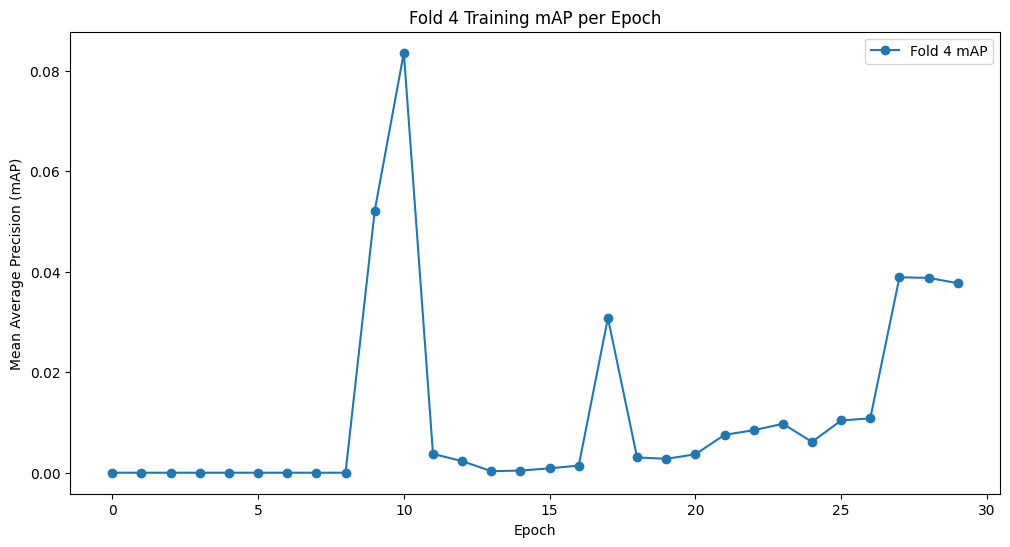

FOLD 4
--------------------------------


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=52.4]

Mean loss was 920.7335993448893


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.75it/s, loss=150]

Mean loss was 566.3972702026367


Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.13it/s, loss=159]

Mean loss was 451.1736246744792


Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=77.3]

Mean loss was 379.2131411234538


Validation mAP for epoch 3: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.61it/s, loss=38.9]

Mean loss was 325.96468353271484


Validation mAP for epoch 4: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.26it/s, loss=100]

Mean loss was 285.049072265625


Validation mAP for epoch 5: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=83.2]

Mean loss was 259.5367965698242


Validation mAP for epoch 6: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.78it/s, loss=44.9]

Mean loss was 226.13195864359537


Validation mAP for epoch 7: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.61it/s, loss=60.4]

Mean loss was 212.53971926371256


Validation mAP for epoch 8: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.21it/s, loss=29.3]

Mean loss was 190.27245171864828


Validation mAP for epoch 9: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.98it/s, loss=38.5]

Mean loss was 163.3085060119629


Validation mAP for epoch 10: 0.024999964982271194


100%|██████████| 6/6 [00:01<00:00,  5.96it/s, loss=57.3]

Mean loss was 153.73594538370767


Validation mAP for epoch 11: 0.062499912455677986


100%|██████████| 6/6 [00:02<00:00,  2.98it/s, loss=18.4]

Mean loss was 138.73839982350668


Validation mAP for epoch 12: 0.06285707652568817


100%|██████████| 6/6 [00:01<00:00,  3.72it/s, loss=61]

Mean loss was 128.78829447428384


Validation mAP for epoch 13: 0.14999981224536896


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=26.9]

Mean loss was 123.77727095286052


Validation mAP for epoch 14: 0.17499978095293045


100%|██████████| 6/6 [00:01<00:00,  3.15it/s, loss=80.4]

Mean loss was 112.85411707560222


Validation mAP for epoch 15: 0.151606947183609


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=114]

Mean loss was 117.06856791178386


Validation mAP for epoch 16: 0.1149204932153225


100%|██████████| 6/6 [00:01<00:00,  3.65it/s, loss=52.3]

Mean loss was 117.31316375732422


Validation mAP for epoch 17: 0.15148790180683136


100%|██████████| 6/6 [00:01<00:00,  3.32it/s, loss=30.2]

Mean loss was 95.03327020009358


Validation mAP for epoch 18: 0.1535712331533432


100%|██████████| 6/6 [00:01<00:00,  5.65it/s, loss=18.4]

Mean loss was 96.20831807454427


Validation mAP for epoch 19: 0.1535712331533432


100%|██████████| 6/6 [00:00<00:00,  6.17it/s, loss=52.8]


Mean loss was 84.6778195699056
Validation mAP for epoch 20: 0.18043629080057144


100%|██████████| 6/6 [00:01<00:00,  3.30it/s, loss=37.4]

Mean loss was 84.02855745951335


Validation mAP for epoch 21: 0.1785712093114853


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=19.3]

Mean loss was 70.04164346059163


Validation mAP for epoch 22: 0.18178550153970718


100%|██████████| 6/6 [00:01<00:00,  3.57it/s, loss=56.3]

Mean loss was 78.38873481750488


Validation mAP for epoch 23: 0.19523786753416061


100%|██████████| 6/6 [00:02<00:00,  2.54it/s, loss=80.4]

Mean loss was 76.83123779296875


Validation mAP for epoch 24: 0.18093090504407883


100%|██████████| 6/6 [00:00<00:00,  6.02it/s, loss=42]

Mean loss was 72.39407030741374


Validation mAP for epoch 25: 0.1785712093114853


100%|██████████| 6/6 [00:01<00:00,  5.67it/s, loss=15.6]

Mean loss was 69.0203030904134


Validation mAP for epoch 26: 0.1785712093114853


100%|██████████| 6/6 [00:02<00:00,  2.89it/s, loss=32.6]


Mean loss was 69.39547729492188
Validation mAP for epoch 27: 0.1785712093114853


100%|██████████| 6/6 [00:01<00:00,  5.58it/s, loss=22.5]

Mean loss was 62.31041272481283


Validation mAP for epoch 28: 0.18093090504407883


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=33.6]

Mean loss was 62.209817250569664


Validation mAP for epoch 29: 0.1785712093114853


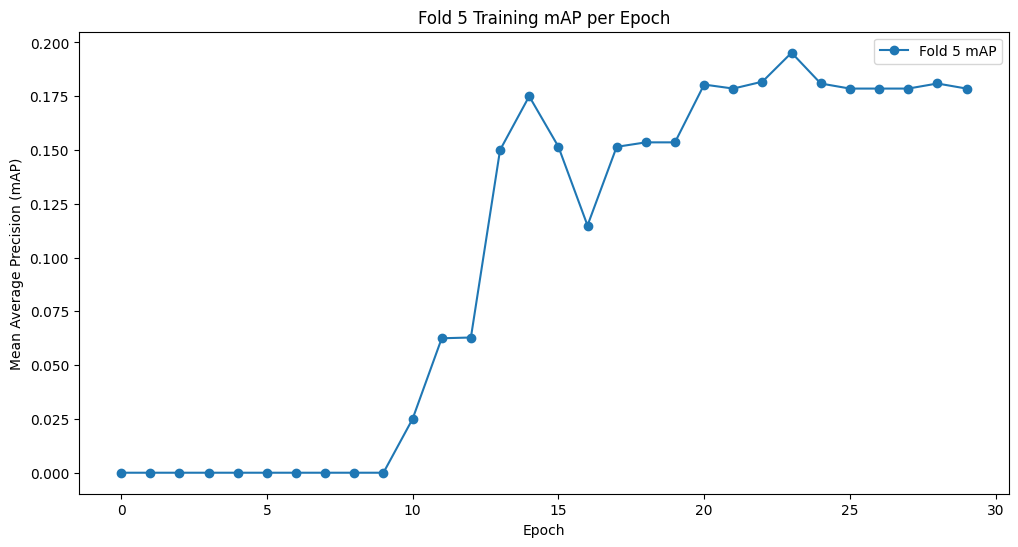

Average Validation mAP across all folds: 0.12326255962252616


In [32]:

# Hyperparameters etc.
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss()

if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

train_dataset = VOCDataset(
    "100examples.csv",
    transform=transform,
    img_dir=IMG_DIR,
    label_dir=LABEL_DIR,
)

test_dataset = VOCDataset(
    "test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
)


k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=seed)
fold_results = []

fold_performance_history = []

for fold, (train_ids, valid_ids) in enumerate(kf.split(np.arange(len(train_dataset)))):
    print(f'FOLD {fold}')
    print('--------------------------------')

    fold_epoch_mAPs = []

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    valid_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    # Initialize the model and optimizer for this fold
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    loss_fn = YoloLoss().to(DEVICE)

    for epoch in range(EPOCHS):

        train_fn(train_loader, model, optimizer, loss_fn)

        valid_mAPs = []
        model.eval() # evaluate in each graph
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(valid_loader):
                x, y = x.to(DEVICE), y.to(DEVICE)
                predictions = model(x)
                # Calculate mAP
                pred_boxes, target_boxes = get_bboxes(valid_loader, model, iou_threshold=0.5, threshold=0.4)
                valid_mAP = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
                valid_mAPs.append(valid_mAP.item())

        # Calculate average mAP for the validation set
        avg_valid_mAP = sum(valid_mAPs) / len(valid_mAPs)
        print(f"Validation mAP for epoch {epoch}: {avg_valid_mAP}")

        fold_epoch_mAPs.append(avg_valid_mAP)

        model.train()

    fold_results.append(avg_valid_mAP)

    plt.figure(figsize=(12, 6))
    plt.plot(range(EPOCHS), fold_epoch_mAPs, marker='o', label=f'Fold {fold+1} mAP')
    plt.title(f'Fold {fold+1} Training mAP per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Average Precision (mAP)')
    plt.legend()
    plt.show()

    fold_results.append(fold_epoch_mAPs[-1])  # Append the last mAP of the fold


average_performance = sum(fold_results) / len(fold_results)
print(f'Average Validation mAP across all folds: {average_performance}')


##Different Hyperparameters

In [33]:
# Hyperparameters etc.
LEARNING_RATE = 1e-5
BATCH_SIZE = 32 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0.0001
EPOCHS = 30 #1000
NUM_WORKERS = 2

##With Adam Optimizer

FOLD 0
--------------------------------


100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=1.07e+3]

Mean loss was 1991.8736572265625


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.59it/s, loss=831]

Mean loss was 1270.9913126627605


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=880]

Mean loss was 1036.9346110026042


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.12it/s, loss=585]

Mean loss was 910.7497151692709


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=511]


Mean loss was 844.0840657552084
Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.23it/s, loss=451]

Mean loss was 742.4989827473959


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.07it/s, loss=364]

Mean loss was 705.6366170247396


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=469]


Mean loss was 643.6142985026041
Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=405]

Mean loss was 607.6327311197916


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.47it/s, loss=411]

Mean loss was 544.2839660644531


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.07s/it, loss=391]

Mean loss was 511.71543375651044


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.11it/s, loss=274]

Mean loss was 486.68454996744794


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.82it/s, loss=189]

Mean loss was 440.43333943684894


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.27it/s, loss=308]

Mean loss was 425.3397928873698


Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.12it/s, loss=394]

Mean loss was 411.87721761067706


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.01it/s, loss=229]

Mean loss was 370.066401163737


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.67it/s, loss=308]

Mean loss was 377.8805338541667


Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=252]

Mean loss was 330.9770762125651


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=221]

Mean loss was 356.69286092122394


Validation mAP for epoch 18: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.14it/s, loss=199]

Mean loss was 335.7874247233073


Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.02it/s, loss=174]

Mean loss was 301.258794148763


Validation mAP for epoch 20: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.12it/s, loss=283]

Mean loss was 284.0349426269531


Validation mAP for epoch 21: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.89it/s, loss=196]


Mean loss was 260.46083068847656
Validation mAP for epoch 22: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.88it/s, loss=171]

Mean loss was 262.58763122558594


Validation mAP for epoch 23: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.27it/s, loss=152]

Mean loss was 223.4349822998047


Validation mAP for epoch 24: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=172]

Mean loss was 246.06500244140625


Validation mAP for epoch 25: 0.01282049622386694


100%|██████████| 3/3 [00:01<00:00,  1.91it/s, loss=188]


Mean loss was 234.22981770833334
Validation mAP for epoch 26: 0.07692296802997589


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=146]

Mean loss was 217.5394032796224


Validation mAP for epoch 27: 0.019230742007493973


100%|██████████| 3/3 [00:02<00:00,  1.01it/s, loss=187]

Mean loss was 233.50787353515625


Validation mAP for epoch 28: 0.024358944967389107


100%|██████████| 3/3 [00:02<00:00,  1.14it/s, loss=168]

Mean loss was 206.7599639892578


Validation mAP for epoch 29: 0.024358944967389107


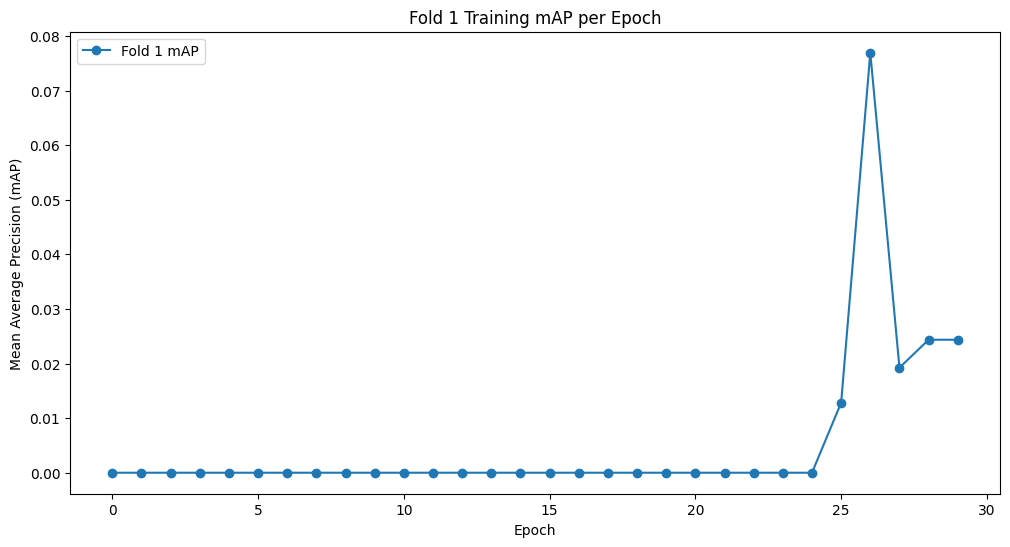

FOLD 1
--------------------------------


100%|██████████| 3/3 [00:01<00:00,  1.96it/s, loss=856]


Mean loss was 1918.7473754882812
Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.13it/s, loss=759]

Mean loss was 1234.3546346028645


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.20it/s, loss=548]

Mean loss was 1033.5640665690105


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.17it/s, loss=571]

Mean loss was 883.5357666015625


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.02it/s, loss=446]

Mean loss was 824.8560078938802


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.38it/s, loss=616]


Mean loss was 742.5948486328125
Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=436]

Mean loss was 664.1405334472656


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.64it/s, loss=559]

Mean loss was 638.5680338541666


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.93it/s, loss=330]


Mean loss was 586.2183024088541
Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.06it/s, loss=434]

Mean loss was 539.1437072753906


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.16it/s, loss=271]

Mean loss was 503.85106404622394


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=357]

Mean loss was 464.4462483723958


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.07it/s, loss=479]

Mean loss was 469.73765055338544


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.88it/s, loss=478]


Mean loss was 447.95444742838544
Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.07it/s, loss=307]

Mean loss was 401.59290568033856


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.23it/s, loss=263]

Mean loss was 367.94200642903644


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.96it/s, loss=212]


Mean loss was 359.9129943847656
Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.07it/s, loss=311]

Mean loss was 372.6915995279948


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=223]

Mean loss was 322.57947794596356


Validation mAP for epoch 18: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.67it/s, loss=215]

Mean loss was 302.6282908121745


Validation mAP for epoch 19: 0.041666626930236816


100%|██████████| 3/3 [00:01<00:00,  1.88it/s, loss=146]

Mean loss was 292.8462880452474


Validation mAP for epoch 20: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.93it/s, loss=180]

Mean loss was 261.84454854329425


Validation mAP for epoch 21: 0.005376340821385384


100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=214]

Mean loss was 282.0293884277344


Validation mAP for epoch 22: 0.043458741158246994


100%|██████████| 3/3 [00:01<00:00,  2.70it/s, loss=224]

Mean loss was 245.17758178710938


Validation mAP for epoch 23: 0.06630819290876389


100%|██████████| 3/3 [00:02<00:00,  1.29it/s, loss=221]

Mean loss was 256.2780354817708


Validation mAP for epoch 24: 0.06787628680467606


100%|██████████| 3/3 [00:01<00:00,  2.07it/s, loss=140]

Mean loss was 236.69474283854166


Validation mAP for epoch 25: 0.06787628680467606


100%|██████████| 3/3 [00:01<00:00,  2.48it/s, loss=137]


Mean loss was 222.2058308919271
Validation mAP for epoch 26: 0.09565404802560806


100%|██████████| 3/3 [00:01<00:00,  1.50it/s, loss=251]

Mean loss was 263.4344889322917


Validation mAP for epoch 27: 0.07629922032356262


100%|██████████| 3/3 [00:02<00:00,  1.39it/s, loss=116]

Mean loss was 186.26008097330728


Validation mAP for epoch 28: 0.07398440688848495


100%|██████████| 3/3 [00:01<00:00,  1.91it/s, loss=129]

Mean loss was 255.78455607096353


Validation mAP for epoch 29: 0.07250591367483139


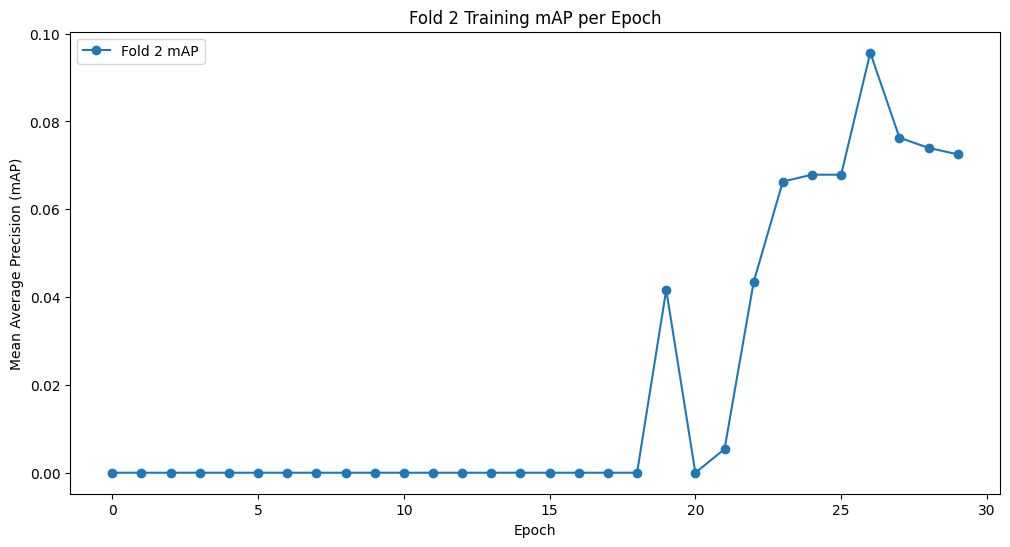

FOLD 2
--------------------------------


100%|██████████| 3/3 [00:03<00:00,  1.07s/it, loss=1.17e+3]

Mean loss was 1924.4598388671875


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=718]

Mean loss was 1252.656229654948


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.38it/s, loss=709]

Mean loss was 1094.9777018229167


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.27it/s, loss=592]

Mean loss was 947.2576904296875


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.15it/s, loss=562]

Mean loss was 891.1716512044271


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.15it/s, loss=490]

Mean loss was 796.6865030924479


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=437]

Mean loss was 731.0455423990885


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.88it/s, loss=440]


Mean loss was 686.7706197102865
Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.27it/s, loss=343]

Mean loss was 624.3980204264323


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.38it/s, loss=428]

Mean loss was 596.7187296549479


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=481]

Mean loss was 587.6547241210938


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.18s/it, loss=526]

Mean loss was 576.8492635091146


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=316]


Mean loss was 507.92600504557294
Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=289]

Mean loss was 455.2011006673177


Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.15it/s, loss=304]

Mean loss was 444.6096598307292


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.15it/s, loss=238]

Mean loss was 406.51645914713544


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=328]

Mean loss was 391.80345662434894


Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.15it/s, loss=265]

Mean loss was 376.1997578938802


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=237]


Mean loss was 367.28411865234375
Validation mAP for epoch 18: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.33it/s, loss=302]


Mean loss was 355.256591796875
Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.62it/s, loss=253]


Mean loss was 348.4633483886719
Validation mAP for epoch 20: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=251]

Mean loss was 317.07854715983075


Validation mAP for epoch 21: 0.0014792891452088952


100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=213]

Mean loss was 293.43157958984375


Validation mAP for epoch 22: 0.03747531771659851


100%|██████████| 3/3 [00:02<00:00,  1.12it/s, loss=240]

Mean loss was 300.65717061360675


Validation mAP for epoch 23: 0.03747531771659851


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=197]

Mean loss was 277.85654703776044


Validation mAP for epoch 24: 0.03747531771659851


100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=222]

Mean loss was 272.1686503092448


Validation mAP for epoch 25: 0.0700196698307991


100%|██████████| 3/3 [00:01<00:00,  2.68it/s, loss=177]

Mean loss was 246.76776631673178


Validation mAP for epoch 26: 0.0700196698307991


100%|██████████| 3/3 [00:01<00:00,  1.93it/s, loss=233]

Mean loss was 253.47260030110678


Validation mAP for epoch 27: 0.0700196698307991


100%|██████████| 3/3 [00:01<00:00,  1.93it/s, loss=306]

Mean loss was 283.8437194824219


Validation mAP for epoch 28: 0.0700196698307991


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=181]

Mean loss was 262.67657979329425


Validation mAP for epoch 29: 0.10848116874694824


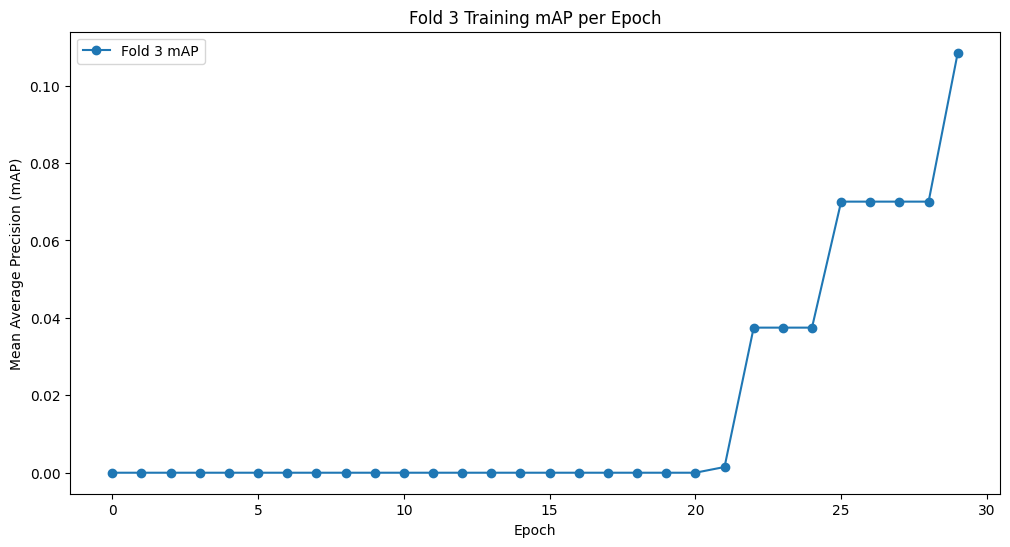

FOLD 3
--------------------------------


100%|██████████| 3/3 [00:01<00:00,  2.58it/s, loss=931]


Mean loss was 1882.4162190755208
Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=719]

Mean loss was 1099.4049072265625


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.39it/s, loss=672]


Mean loss was 891.7908528645834
Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.16s/it, loss=442]

Mean loss was 772.4083455403646


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.12it/s, loss=454]


Mean loss was 727.3929036458334
Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=324]

Mean loss was 623.0576883951823


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.15it/s, loss=397]

Mean loss was 560.8883666992188


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.29it/s, loss=328]

Mean loss was 522.0604654947916


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.60it/s, loss=244]


Mean loss was 461.80621337890625
Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.49it/s, loss=276]

Mean loss was 447.2418924967448


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=325]

Mean loss was 422.9897867838542


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.65it/s, loss=270]

Mean loss was 367.81810506184894


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=242]

Mean loss was 344.3614196777344


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.14it/s, loss=264]

Mean loss was 320.5663146972656


Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=266]

Mean loss was 334.98354085286456


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=227]


Mean loss was 286.43723551432294
Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.06it/s, loss=185]

Mean loss was 273.3906962076823


Validation mAP for epoch 16: 0.0018518510041758418


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=124]

Mean loss was 257.48182423909503


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.12it/s, loss=143]


Mean loss was 230.40568033854166
Validation mAP for epoch 18: 0.00023148143372964114


100%|██████████| 3/3 [00:02<00:00,  1.02it/s, loss=199]

Mean loss was 245.3686065673828


Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.13it/s, loss=189]


Mean loss was 230.80694071451822
Validation mAP for epoch 20: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.50it/s, loss=87.4]

Mean loss was 193.64807891845703


Validation mAP for epoch 21: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.13it/s, loss=179]

Mean loss was 211.45830281575522


Validation mAP for epoch 22: 0.00046296275104396045


100%|██████████| 3/3 [00:01<00:00,  1.89it/s, loss=116]

Mean loss was 193.22754669189453


Validation mAP for epoch 23: 0.00046296275104396045


100%|██████████| 3/3 [00:02<00:00,  1.30it/s, loss=165]

Mean loss was 189.62610880533853


Validation mAP for epoch 24: 0.00046296275104396045


100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=175]

Mean loss was 176.7096150716146


Validation mAP for epoch 25: 0.028240717947483063


100%|██████████| 3/3 [00:02<00:00,  1.16it/s, loss=116]

Mean loss was 153.77418009440103


Validation mAP for epoch 26: 0.028086399659514427


100%|██████████| 3/3 [00:02<00:00,  1.12it/s, loss=117]

Mean loss was 157.89175669352213


Validation mAP for epoch 27: 0.028086399659514427


100%|██████████| 3/3 [00:02<00:00,  1.30it/s, loss=105]

Mean loss was 158.3382314046224


Validation mAP for epoch 28: 0.057098712772130966


100%|██████████| 3/3 [00:02<00:00,  1.13it/s, loss=148]

Mean loss was 164.81033325195312


Validation mAP for epoch 29: 0.08988087624311447


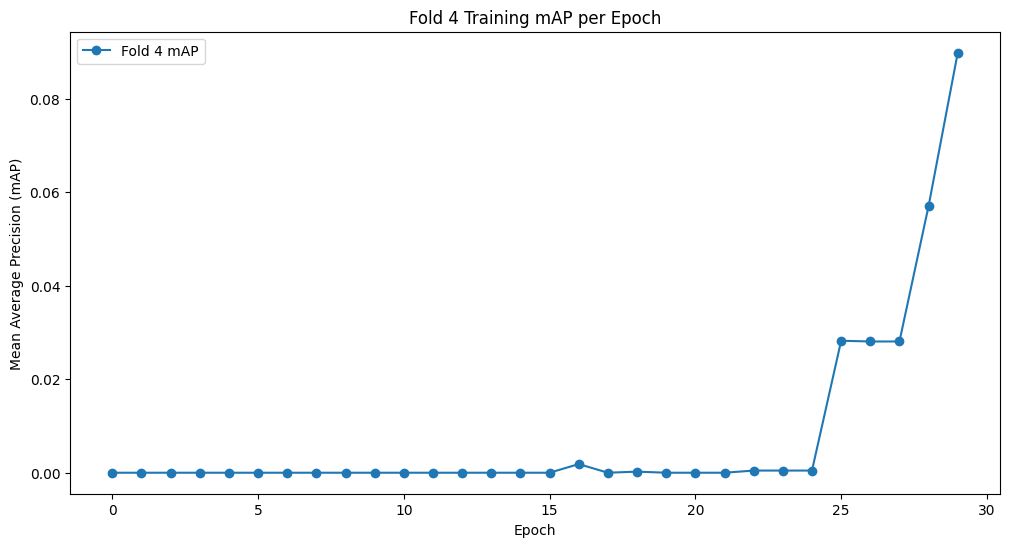

FOLD 4
--------------------------------


100%|██████████| 3/3 [00:02<00:00,  1.28it/s, loss=1.16e+3]

Mean loss was 2038.0447998046875


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.70it/s, loss=826]

Mean loss was 1358.4925333658855


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=655]

Mean loss was 1112.0472615559895


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=669]


Mean loss was 958.9839070638021
Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.28it/s, loss=553]

Mean loss was 862.395751953125


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=521]

Mean loss was 774.1467488606771


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=374]


Mean loss was 745.0487670898438
Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=381]

Mean loss was 661.7837422688802


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.76it/s, loss=352]

Mean loss was 621.3377482096354


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.95it/s, loss=269]

Mean loss was 557.415517171224


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=310]

Mean loss was 530.2613321940104


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.19it/s, loss=304]

Mean loss was 520.3490193684896


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=243]


Mean loss was 468.6703847249349
Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=304]

Mean loss was 453.33819580078125


Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.58it/s, loss=309]

Mean loss was 432.7764892578125


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.05it/s, loss=304]

Mean loss was 411.9272054036458


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.91it/s, loss=236]

Mean loss was 357.10423787434894


Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.91it/s, loss=304]


Mean loss was 345.86810302734375
Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=224]

Mean loss was 360.69414774576825


Validation mAP for epoch 18: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=286]

Mean loss was 330.49254353841144


Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=232]

Mean loss was 304.16082763671875


Validation mAP for epoch 20: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=156]


Mean loss was 278.49586486816406
Validation mAP for epoch 21: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.07it/s, loss=208]

Mean loss was 320.2762451171875


Validation mAP for epoch 22: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=277]


Mean loss was 306.2562255859375
Validation mAP for epoch 23: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.00it/s, loss=172]

Mean loss was 250.1363779703776


Validation mAP for epoch 24: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.10it/s, loss=170]

Mean loss was 259.8512674967448


Validation mAP for epoch 25: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.91it/s, loss=182]

Mean loss was 249.14700317382812


Validation mAP for epoch 26: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=150]

Mean loss was 216.80807495117188


Validation mAP for epoch 27: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=178]

Mean loss was 222.80236307779947


Validation mAP for epoch 28: 0.09999985992908478


100%|██████████| 3/3 [00:02<00:00,  1.17it/s, loss=149]

Mean loss was 208.4835459391276


Validation mAP for epoch 29: 0.09999985992908478


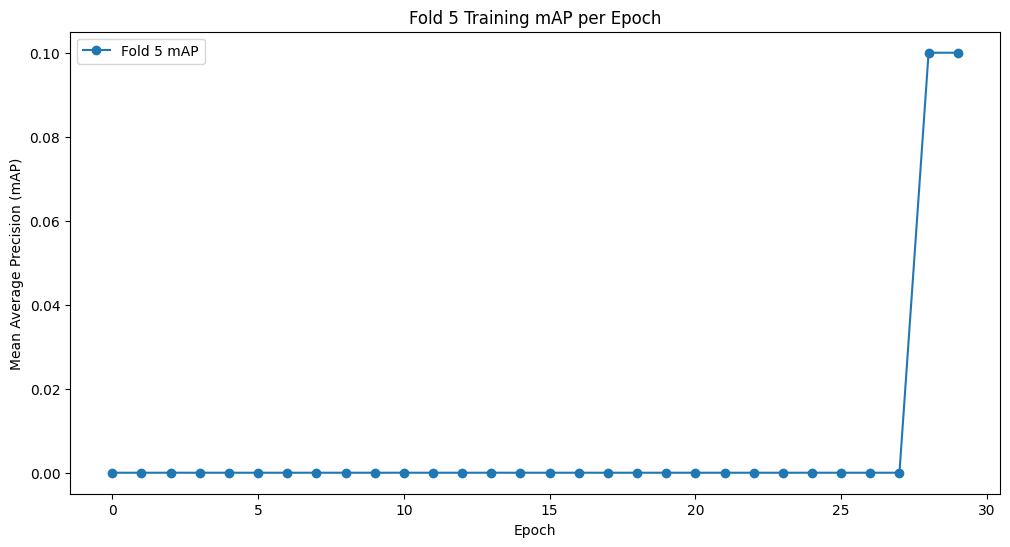

Average Validation mAP across all folds: 0.0790453527122736


In [34]:

# Hyperparameters etc.
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss()

if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

train_dataset = VOCDataset(
    "100examples.csv",
    transform=transform,
    img_dir=IMG_DIR,
    label_dir=LABEL_DIR,
)

test_dataset = VOCDataset(
    "test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
)


k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=seed)
fold_results = []

# Collect the fold performance for plotting
fold_performance_history = []

for fold, (train_ids, valid_ids) in enumerate(kf.split(np.arange(len(train_dataset)))):
    print(f'FOLD {fold}')
    print('--------------------------------')

    fold_epoch_mAPs = []  # Store mAP for each epoch within this fold

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    valid_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    # Initialize the model and optimizer for this fold
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    loss_fn = YoloLoss().to(DEVICE)

    for epoch in range(EPOCHS):

        train_fn(train_loader, model, optimizer, loss_fn)

        # Evaluate after the epoch
        valid_mAPs = []
        model.eval()
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(valid_loader):
                x, y = x.to(DEVICE), y.to(DEVICE)
                predictions = model(x)
                # Calculate mAP
                pred_boxes, target_boxes = get_bboxes(valid_loader, model, iou_threshold=0.5, threshold=0.4)
                valid_mAP = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
                valid_mAPs.append(valid_mAP.item())

        # Calculate average mAP for the validation set
        avg_valid_mAP = sum(valid_mAPs) / len(valid_mAPs)
        print(f"Validation mAP for epoch {epoch}: {avg_valid_mAP}")

        fold_epoch_mAPs.append(avg_valid_mAP)


        model.train()

    fold_results.append(avg_valid_mAP)


    # Plot the training mAP for each epoch of the current fold
    plt.figure(figsize=(12, 6))
    plt.plot(range(EPOCHS), fold_epoch_mAPs, marker='o', label=f'Fold {fold+1} mAP')
    plt.title(f'Fold {fold+1} Training mAP per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Average Precision (mAP)')
    plt.legend()
    plt.show()

    fold_results.append(fold_epoch_mAPs[-1])


average_performance = sum(fold_results) / len(fold_results)
print(f'Average Validation mAP across all folds: {average_performance}')


With RMSProp Optimizer

FOLD 0
--------------------------------


100%|██████████| 3/3 [00:03<00:00,  1.12s/it, loss=684]

Mean loss was 1784.8750406901042


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.06it/s, loss=455]

Mean loss was 865.8476765950521


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=428]

Mean loss was 639.7139383951823


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.01it/s, loss=373]

Mean loss was 551.342041015625


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.91it/s, loss=355]

Mean loss was 489.00110880533856


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.27it/s, loss=259]

Mean loss was 388.0530192057292


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.61it/s, loss=263]

Mean loss was 347.6510823567708


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.07it/s, loss=211]

Mean loss was 328.2427978515625


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=301]


Mean loss was 311.6510518391927
Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=238]

Mean loss was 261.88880411783856


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=200]

Mean loss was 230.1785888671875


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.17it/s, loss=279]

Mean loss was 266.72487386067706


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.15it/s, loss=208]

Mean loss was 218.8422393798828


Validation mAP for epoch 12: 0.0021367508452385664


100%|██████████| 3/3 [00:01<00:00,  1.91it/s, loss=154]


Mean loss was 198.70169067382812
Validation mAP for epoch 13: 0.00961537566035986


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=193]

Mean loss was 209.13945515950522


Validation mAP for epoch 14: 0.03846150264143944


100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=210]

Mean loss was 215.8438720703125


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.07it/s, loss=165]

Mean loss was 215.05012003580728


Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.06it/s, loss=202]

Mean loss was 249.70430501302084


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.89it/s, loss=190]


Mean loss was 175.71853383382162
Validation mAP for epoch 18: 0.03974355012178421


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=171]

Mean loss was 188.23792012532553


Validation mAP for epoch 19: 0.00341880158521235


100%|██████████| 3/3 [00:02<00:00,  1.27it/s, loss=123]

Mean loss was 176.13990783691406


Validation mAP for epoch 20: 0.08846141397953033


100%|██████████| 3/3 [00:02<00:00,  1.15it/s, loss=114]

Mean loss was 149.3169148763021


Validation mAP for epoch 21: 0.08525629341602325


100%|██████████| 3/3 [00:02<00:00,  1.16it/s, loss=99]

Mean loss was 146.3454793294271


Validation mAP for epoch 22: 0.08205116540193558


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=122]

Mean loss was 132.67431640625


Validation mAP for epoch 23: 0.08205116540193558


100%|██████████| 3/3 [00:02<00:00,  1.16it/s, loss=70.9]

Mean loss was 126.14320882161458


Validation mAP for epoch 24: 0.12051267176866531


100%|██████████| 3/3 [00:01<00:00,  2.07it/s, loss=119]

Mean loss was 136.37633260091147


Validation mAP for epoch 25: 0.12051267176866531


100%|██████████| 3/3 [00:01<00:00,  1.52it/s, loss=127]

Mean loss was 141.0766143798828


Validation mAP for epoch 26: 0.12051267176866531


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=93]

Mean loss was 115.53120676676433


Validation mAP for epoch 27: 0.12051267176866531


100%|██████████| 3/3 [00:02<00:00,  1.28it/s, loss=63.4]

Mean loss was 127.23330434163411


Validation mAP for epoch 28: 0.12051267176866531


100%|██████████| 3/3 [00:01<00:00,  1.94it/s, loss=119]

Mean loss was 138.78768412272134


Validation mAP for epoch 29: 0.12051267176866531


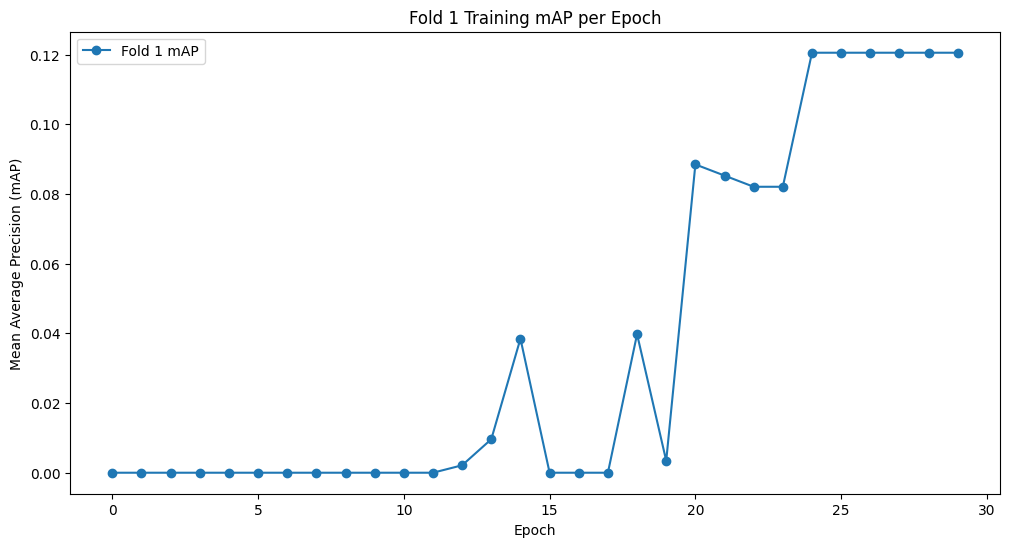

FOLD 1
--------------------------------


100%|██████████| 3/3 [00:02<00:00,  1.21it/s, loss=841]

Mean loss was 1769.2344970703125


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.01it/s, loss=565]

Mean loss was 917.5901896158854


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.89it/s, loss=635]


Mean loss was 653.1744384765625
Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=454]

Mean loss was 531.5104471842448


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=292]

Mean loss was 464.31373087565106


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.73it/s, loss=358]

Mean loss was 391.9308369954427


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.67it/s, loss=239]

Mean loss was 362.6649424235026


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.92it/s, loss=275]

Mean loss was 316.86069742838544


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.06it/s, loss=243]

Mean loss was 325.1954803466797


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.96it/s, loss=215]

Mean loss was 287.8113606770833


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=286]

Mean loss was 269.03477986653644


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=241]

Mean loss was 254.62690226236978


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.60it/s, loss=177]

Mean loss was 214.0626424153646


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.60it/s, loss=164]

Mean loss was 215.32417805989584


Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.35it/s, loss=105]

Mean loss was 204.8989054361979


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.49it/s, loss=159]

Mean loss was 192.46893819173178


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=164]

Mean loss was 181.1491444905599


Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.16s/it, loss=134]

Mean loss was 183.5723673502604


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.76it/s, loss=118]

Mean loss was 166.9839604695638


Validation mAP for epoch 18: 0.0003360214177519083


100%|██████████| 3/3 [00:01<00:00,  2.69it/s, loss=102]

Mean loss was 144.5932820638021


Validation mAP for epoch 19: 0.0002688171516638249


100%|██████████| 3/3 [00:01<00:00,  1.94it/s, loss=125]

Mean loss was 155.24591573079428


Validation mAP for epoch 20: 0.10293450206518173


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=87.2]

Mean loss was 154.97037760416666


Validation mAP for epoch 21: 0.08012985438108444


100%|██████████| 3/3 [00:01<00:00,  2.73it/s, loss=74.5]

Mean loss was 147.41636403401694


Validation mAP for epoch 22: 0.10174722224473953


100%|██████████| 3/3 [00:01<00:00,  2.15it/s, loss=149]

Mean loss was 157.26659647623697


Validation mAP for epoch 23: 0.17636632919311523


100%|██████████| 3/3 [00:01<00:00,  1.91it/s, loss=105]


Mean loss was 156.32524871826172
Validation mAP for epoch 24: 0.056694790720939636


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=134]

Mean loss was 180.4362335205078


Validation mAP for epoch 25: 0.10886446386575699


100%|██████████| 3/3 [00:02<00:00,  1.27it/s, loss=117]

Mean loss was 164.94036102294922


Validation mAP for epoch 26: 0.17876969277858734


100%|██████████| 3/3 [00:02<00:00,  1.13it/s, loss=87]

Mean loss was 122.99617258707683


Validation mAP for epoch 27: 0.20483529567718506


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=88.2]

Mean loss was 126.73070271809895


Validation mAP for epoch 28: 0.1402267962694168


100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=93.5]

Mean loss was 124.45687357584636


Validation mAP for epoch 29: 0.1005956307053566


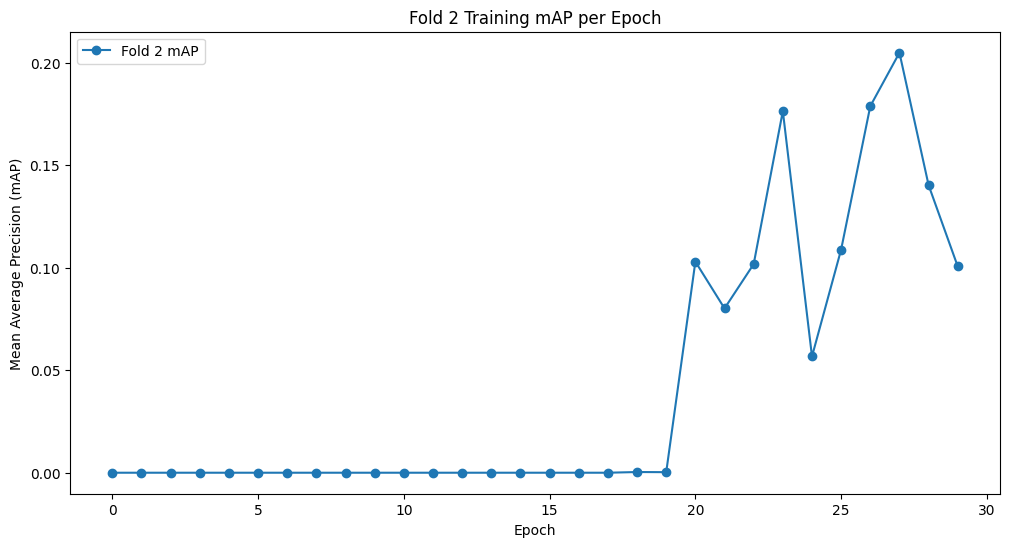

FOLD 2
--------------------------------


100%|██████████| 3/3 [00:01<00:00,  2.65it/s, loss=1.21e+3]

Mean loss was 2010.1594645182292


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=526]

Mean loss was 1141.8883463541667


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.18it/s, loss=430]

Mean loss was 789.2545776367188


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=309]

Mean loss was 638.8204142252604


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.60it/s, loss=366]

Mean loss was 577.4922485351562


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.06it/s, loss=287]

Mean loss was 492.62855021158856


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=344]


Mean loss was 447.59307861328125
Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=366]

Mean loss was 411.61902872721356


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.20it/s, loss=279]

Mean loss was 377.75107828776044


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.49it/s, loss=288]

Mean loss was 335.0917460123698


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=282]

Mean loss was 299.0348714192708


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.37it/s, loss=192]

Mean loss was 301.7083689371745


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=144]


Mean loss was 282.13775126139325
Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=170]

Mean loss was 252.2357381184896


Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.15it/s, loss=156]

Mean loss was 252.7080281575521


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=192]

Mean loss was 246.5230509440104


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.16s/it, loss=109]

Mean loss was 240.1319325764974


Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.15it/s, loss=124]

Mean loss was 200.25387827555338


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=236]

Mean loss was 215.42296346028647


Validation mAP for epoch 18: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.66it/s, loss=159]

Mean loss was 195.12952677408853


Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=177]

Mean loss was 197.51327514648438


Validation mAP for epoch 20: 0.03920114412903786


100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=123]

Mean loss was 161.04507954915366


Validation mAP for epoch 21: 0.0700196623802185


100%|██████████| 3/3 [00:01<00:00,  2.73it/s, loss=134]

Mean loss was 166.52890014648438


Validation mAP for epoch 22: 0.11439832299947739


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=159]

Mean loss was 171.06511433919272


Validation mAP for epoch 23: 0.11439832299947739


100%|██████████| 3/3 [00:02<00:00,  1.18it/s, loss=142]

Mean loss was 162.47595723470053


Validation mAP for epoch 24: 0.1109466478228569


100%|██████████| 3/3 [00:01<00:00,  2.64it/s, loss=143]

Mean loss was 175.86795043945312


Validation mAP for epoch 25: 0.11193284392356873


100%|██████████| 3/3 [00:01<00:00,  1.67it/s, loss=150]

Mean loss was 159.08187866210938


Validation mAP for epoch 26: 0.10981957614421844


100%|██████████| 3/3 [00:02<00:00,  1.28it/s, loss=104]

Mean loss was 146.09253438313803


Validation mAP for epoch 27: 0.10848116874694824


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=155]

Mean loss was 154.58108520507812


Validation mAP for epoch 28: 0.10964345932006836


100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=100]

Mean loss was 172.01143646240234


Validation mAP for epoch 29: 0.1095084473490715


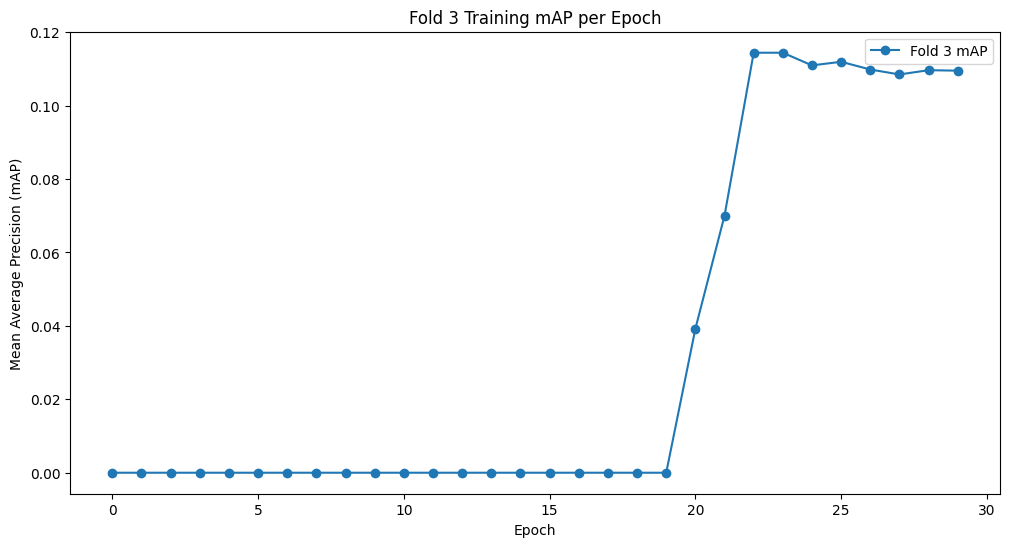

FOLD 3
--------------------------------


100%|██████████| 3/3 [00:02<00:00,  1.21it/s, loss=797]

Mean loss was 1671.7347615559895


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.46it/s, loss=445]

Mean loss was 791.5557759602865


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.91it/s, loss=539]

Mean loss was 604.3308308919271


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.38it/s, loss=438]

Mean loss was 462.8987121582031


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.31it/s, loss=287]

Mean loss was 375.3045145670573


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.12it/s, loss=230]

Mean loss was 338.84349568684894


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.28it/s, loss=248]

Mean loss was 361.39617919921875


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.09it/s, loss=220]

Mean loss was 277.79148864746094


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=311]

Mean loss was 285.0424092610677


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=230]

Mean loss was 240.3769073486328


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.06it/s, loss=145]

Mean loss was 224.70891316731772


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.89it/s, loss=252]

Mean loss was 235.5455322265625


Validation mAP for epoch 11: 0.0018518510041758418


100%|██████████| 3/3 [00:01<00:00,  1.89it/s, loss=150]


Mean loss was 206.97517903645834
Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.92it/s, loss=178]


Mean loss was 183.34100850423178
Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.89it/s, loss=133]

Mean loss was 166.09866841634116


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.27it/s, loss=133]

Mean loss was 162.76434834798178


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.91it/s, loss=86.5]


Mean loss was 147.77787272135416
Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.29it/s, loss=153]

Mean loss was 160.1793975830078


Validation mAP for epoch 17: 0.00046296275104396045


100%|██████████| 3/3 [00:01<00:00,  2.66it/s, loss=106]

Mean loss was 144.1191660563151


Validation mAP for epoch 18: 0.00018518515571486205


100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=130]

Mean loss was 143.03469848632812


Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.38it/s, loss=155]


Mean loss was 192.23650105794272
Validation mAP for epoch 20: 0.0015432093059644103


100%|██████████| 3/3 [00:02<00:00,  1.06it/s, loss=128]

Mean loss was 151.11494954427084


Validation mAP for epoch 21: 0.00030864187283441424


100%|██████████| 3/3 [00:03<00:00,  1.18s/it, loss=126]

Mean loss was 144.50574747721353


Validation mAP for epoch 22: 0.029228374361991882


100%|██████████| 3/3 [00:02<00:00,  1.24it/s, loss=119]

Mean loss was 133.22139994303384


Validation mAP for epoch 23: 0.03419309854507446


100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=68.5]


Mean loss was 105.6138203938802
Validation mAP for epoch 24: 0.04533727094531059


100%|██████████| 3/3 [00:01<00:00,  1.94it/s, loss=99.1]

Mean loss was 114.11343383789062


Validation mAP for epoch 25: 0.04398145154118538


100%|██████████| 3/3 [00:01<00:00,  2.29it/s, loss=92.1]


Mean loss was 113.58013916015625
Validation mAP for epoch 26: 0.03980744257569313


100%|██████████| 3/3 [00:01<00:00,  2.47it/s, loss=68]

Mean loss was 101.97075653076172


Validation mAP for epoch 27: 0.04001687839627266


100%|██████████| 3/3 [00:02<00:00,  1.50it/s, loss=77.9]

Mean loss was 111.43406168619792


Validation mAP for epoch 28: 0.04003364220261574


100%|██████████| 3/3 [00:02<00:00,  1.37it/s, loss=63.6]


Mean loss was 89.92462793986003
Validation mAP for epoch 29: 0.04136093705892563


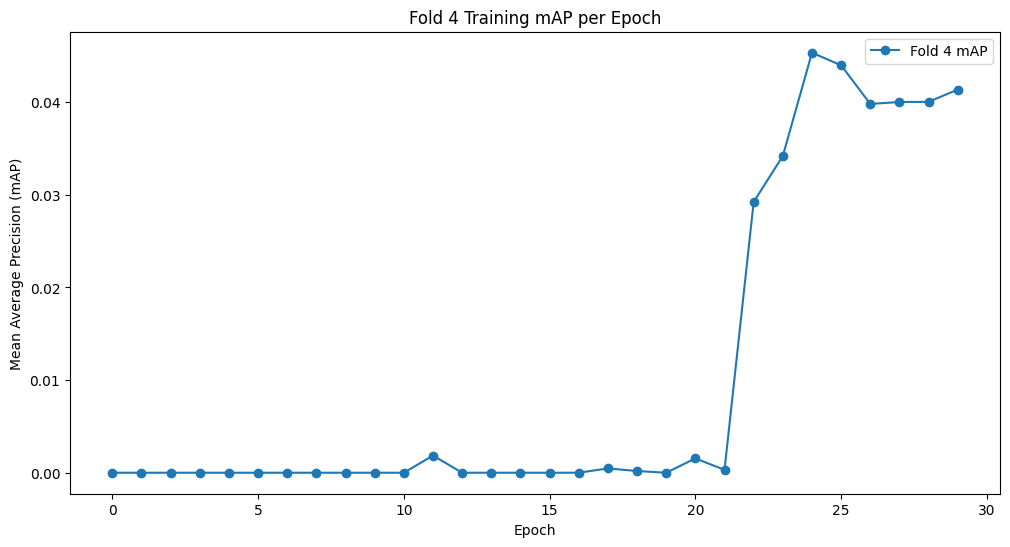

FOLD 4
--------------------------------


100%|██████████| 3/3 [00:03<00:00,  1.07s/it, loss=889]

Mean loss was 2066.191935221354


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.00it/s, loss=501]

Mean loss was 1016.6015828450521


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.07it/s, loss=588]

Mean loss was 730.1863199869791


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=405]


Mean loss was 611.7762247721354
Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.93it/s, loss=430]


Mean loss was 501.60373942057294
Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=364]

Mean loss was 448.5265706380208


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=369]

Mean loss was 421.12818400065106


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.01it/s, loss=297]

Mean loss was 462.1642252604167


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.89it/s, loss=240]

Mean loss was 351.56215413411456


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.31it/s, loss=257]

Mean loss was 312.7892659505208


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.53it/s, loss=316]


Mean loss was 313.7042541503906
Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.06it/s, loss=257]

Mean loss was 309.26759847005206


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.25it/s, loss=186]

Mean loss was 306.1707356770833


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.57it/s, loss=218]


Mean loss was 250.52310180664062
Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.06it/s, loss=255]

Mean loss was 270.99753824869794


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=159]


Mean loss was 237.6176503499349
Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=144]


Mean loss was 198.8374786376953
Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.27it/s, loss=152]

Mean loss was 195.69867451985678


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.91it/s, loss=169]


Mean loss was 203.22549947102866
Validation mAP for epoch 18: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=142]


Mean loss was 174.25177510579428
Validation mAP for epoch 19: 0.04999995231628418


100%|██████████| 3/3 [00:01<00:00,  1.89it/s, loss=140]

Mean loss was 155.26288859049478


Validation mAP for epoch 20: 0.04999995231628418


100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=85.7]


Mean loss was 153.67227172851562
Validation mAP for epoch 21: 0.14999981224536896


100%|██████████| 3/3 [00:02<00:00,  1.27it/s, loss=190]

Mean loss was 183.36508178710938


Validation mAP for epoch 22: 0.1535712331533432


100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=127]

Mean loss was 189.59684244791666


Validation mAP for epoch 23: 0.1535712331533432


100%|██████████| 3/3 [00:01<00:00,  1.88it/s, loss=157]

Mean loss was 191.7960408528646


Validation mAP for epoch 24: 0.1535712331533432


100%|██████████| 3/3 [00:02<00:00,  1.28it/s, loss=82.8]

Mean loss was 161.18916829427084


Validation mAP for epoch 25: 0.1535712331533432


100%|██████████| 3/3 [00:01<00:00,  2.06it/s, loss=119]

Mean loss was 133.9208526611328


Validation mAP for epoch 26: 0.1535712331533432


100%|██████████| 3/3 [00:01<00:00,  1.88it/s, loss=123]


Mean loss was 141.3654810587565
Validation mAP for epoch 27: 0.1535712331533432


100%|██████████| 3/3 [00:02<00:00,  1.23it/s, loss=97.5]

Mean loss was 147.17643229166666


Validation mAP for epoch 28: 0.1785712093114853


100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=103]

Mean loss was 148.55397033691406


Validation mAP for epoch 29: 0.1785712093114853


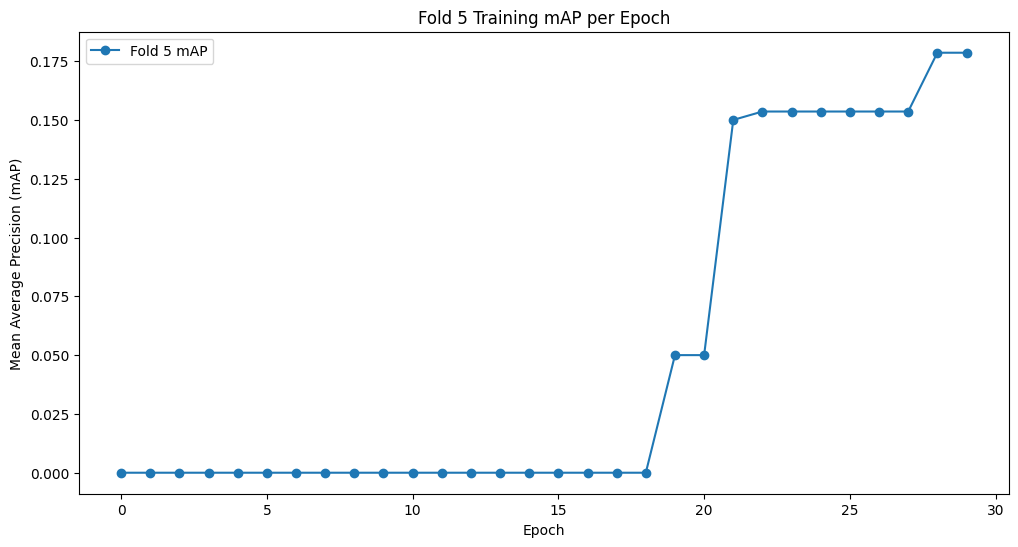

Average Validation mAP across all folds: 0.11010977923870087


In [35]:
# Hyperparameters etc.
model_RMSP = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.RMSprop(
    model_RMSP.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss()

if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model_RMSP, optimizer)

train_dataset = VOCDataset(
    "100examples.csv",
    transform=transform,
    img_dir=IMG_DIR,
    label_dir=LABEL_DIR,
)

test_dataset = VOCDataset(
    "test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
)

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=seed)
fold_results = []

# Collect the fold performance for plotting
fold_performance_history = []

for fold, (train_ids, valid_ids) in enumerate(kf.split(np.arange(len(train_dataset)))):
    print(f'FOLD {fold}')
    print('--------------------------------')

    fold_epoch_mAPs = []  # Store mAP for each epoch within this fold

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = SubsetRandomSampler(train_ids)
    valid_subsampler = SubsetRandomSampler(valid_ids)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    valid_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    # Initialize the model and optimizer for this fold
    model_RMSP = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.RMSprop(model_RMSP.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)  # Updated to RMSprop
    loss_fn = YoloLoss().to(DEVICE)


    for epoch in range(EPOCHS):

        # Train for current epoch
        train_fn(train_loader, model_RMSP, optimizer, loss_fn)

        valid_mAPs = []
        model_RMSP.eval()
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(valid_loader):
                x, y = x.to(DEVICE), y.to(DEVICE)
                predictions = model_RMSP(x)
                # Calculate mAP
                pred_boxes, target_boxes = get_bboxes(valid_loader, model_RMSP, iou_threshold=0.5, threshold=0.4)
                valid_mAP = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
                valid_mAPs.append(valid_mAP.item())

        # Calculate average mAP for the validation set
        avg_valid_mAP = sum(valid_mAPs) / len(valid_mAPs)
        print(f"Validation mAP for epoch {epoch}: {avg_valid_mAP}")

        fold_epoch_mAPs.append(avg_valid_mAP)

        model.train()

    fold_results.append(avg_valid_mAP)

    # Plot the training mAP for each epoch of the current fold
    plt.figure(figsize=(12, 6))
    plt.plot(range(EPOCHS), fold_epoch_mAPs, marker='o', label=f'Fold {fold+1} mAP')
    plt.title(f'Fold {fold+1} Training mAP per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Average Precision (mAP)')
    plt.legend()
    plt.show()

    fold_results.append(fold_epoch_mAPs[-1])


average_performance = sum(fold_results) / len(fold_results)
print(f'Average Validation mAP across all folds: {average_performance}')


#YoloV1 without BN

In [38]:
class CNNBlock_WO_BN(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock_WO_BN, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=True, **kwargs)  # Set bias=True because we're not using BatchNorm
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.conv(x))



class Yolov1_WO_BN(nn.Module):
  """
  Implementation of Yolo (v1) architecture
  """
  def __init__(self, in_channels=3, **kwargs):
    super(Yolov1_WO_BN, self).__init__()
    self.architecture = architecture_config
    self.in_channels = in_channels # Store the number of input channels (e.g., 3 for RGB images).
    self.darknet = self._create_conv_layers(self.architecture) #Create the convolutional layers based on the architecture

    self.fcs = self._create_fcs(**kwargs) # Create the fully connected layers using another private method

  def forward(self, x):
    x = self.darknet(x)     # Pass the input 'x' through the convolutional layers (darknet part of YOLO).
    return self.fcs(torch.flatten(x, start_dim=1))    # Flatten the output of the convolutional layers and pass it through the fully connected layers.

  def _create_conv_layers(self, architecture):
    layers = []
    in_channels = self.in_channels # Start with the initial number of input channels

    for x in architecture:
      if type(x) == tuple: # If the element is a tuple, it defines a convolutional layer's parameters.
        layers += [
          CNNBlock_WO_BN(
              in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
          )
        ]
        in_channels = x[1]

      elif type(x) == str: # If the element is a Str, it defines a Max pooling layer's parameters.
        layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

      elif type(x) == list: # If the element is a list, it defines a series of convolutional layer's parameters.
        conv1 = x[0]        # The first element in the list specifies the parameters for one convolutional layer
        conv2 = x[1]        # The second element specifies the parameters for another convolutional layer
        num_repeats = x[2]  # The third element is the number of times this block will repeat

        for _ in range(num_repeats):
          layers += [
            CNNBlock_WO_BN(
              in_channels,  # Number of input channels
              conv1[1],  # Number of output channels for the first layer
              kernel_size=conv1[0],  # Kernel size for the first layer
              stride=conv1[2],  # Stride for the first layer
              padding=conv1[3],  # Padding for the first layer
            )
          ]
          layers += [
            CNNBlock_WO_BN(
              conv1[1],  # Number of input channels for the second layer is the output channels of the first
              conv2[1],  # Number of output channels for the second layer
              kernel_size=conv2[0],  # Kernel size for the second layer
              stride=conv2[2],  # Stride for the second layer
              padding=conv2[3],  # Padding for the second layer
            )
          ]
          in_channels = conv2[1]  # Update the number of input channels for the next layer


    return nn.Sequential(*layers)

  def _create_fcs(self, split_size, num_boxes, num_classes):
    S, B, C = split_size, num_boxes, num_classes

    # In original paper this should be
    # nn.Linear(1024*S*S, 4096),
    # nn.LeakyReLU(0.1),
    # nn.Linear(4096, S*S*(B*5+C))

    return nn.Sequential(
      nn.Flatten(),
      nn.Linear(1024 * S * S, 496),
      nn.Dropout(0.0),
      nn.LeakyReLU(0.1),
      nn.Linear(496, S * S * (C + B * 5)),
    )



In [42]:
model = Yolov1_WO_BN(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
summary(model.cuda(), (3, 448, 448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,472
         LeakyReLU-2         [-1, 64, 224, 224]               0
    CNNBlock_WO_BN-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 192, 112, 112]         110,784
         LeakyReLU-6        [-1, 192, 112, 112]               0
    CNNBlock_WO_BN-7        [-1, 192, 112, 112]               0
         MaxPool2d-8          [-1, 192, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          24,704
        LeakyReLU-10          [-1, 128, 56, 56]               0
   CNNBlock_WO_BN-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         295,168
        LeakyReLU-13          [-1, 256, 56, 56]               0
   CNNBlock_WO_BN-14          [-1, 256,

FOLD 0
--------------------------------


100%|██████████| 6/6 [00:02<00:00,  2.85it/s, loss=312]

Mean loss was 1034.0352834065754


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.44it/s, loss=232]

Mean loss was 940.4011281331381


Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.25it/s, loss=34.9]

Mean loss was 768.6440976460775


Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=135]


Mean loss was 553.639045715332
Validation mAP for epoch 3: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.28it/s, loss=41.8]

Mean loss was 482.47460746765137


Validation mAP for epoch 4: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.85it/s, loss=99.4]

Mean loss was 429.7515614827474


Validation mAP for epoch 5: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.97it/s, loss=17.1]

Mean loss was 378.97068881988525


Validation mAP for epoch 6: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.29it/s, loss=21.1]


Mean loss was 334.69946002960205
Validation mAP for epoch 7: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=27.2]

Mean loss was 305.3723379770915


Validation mAP for epoch 8: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.80it/s, loss=24.9]

Mean loss was 278.5543139775594


Validation mAP for epoch 9: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.37it/s, loss=75.8]

Mean loss was 253.11748504638672


Validation mAP for epoch 10: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.35it/s, loss=27.8]

Mean loss was 232.1268720626831


Validation mAP for epoch 11: 0.001174636767245829


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=68]

Mean loss was 213.5631866455078


Validation mAP for epoch 12: 0.008195966249331832


100%|██████████| 6/6 [00:00<00:00,  6.33it/s, loss=39.1]

Mean loss was 197.70524660746256


Validation mAP for epoch 13: 0.0008625563641544431


100%|██████████| 6/6 [00:01<00:00,  3.14it/s, loss=9.9]

Mean loss was 184.9689466158549


Validation mAP for epoch 14: 0.005691741593182087


100%|██████████| 6/6 [00:01<00:00,  3.34it/s, loss=67.3]

Mean loss was 174.80967330932617


Validation mAP for epoch 15: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=10.1]

Mean loss was 166.1409215927124


Validation mAP for epoch 16: 0.0


100%|██████████| 6/6 [00:01<00:00,  4.77it/s, loss=6.38]

Mean loss was 159.20644942919412


Validation mAP for epoch 17: 0.0008611054799985141


100%|██████████| 6/6 [00:01<00:00,  5.88it/s, loss=12.4]

Mean loss was 155.38467073440552


Validation mAP for epoch 18: 0.001488094450905919


100%|██████████| 6/6 [00:01<00:00,  3.53it/s, loss=13.3]

Mean loss was 152.7484868367513


Validation mAP for epoch 19: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=5.13]

Mean loss was 149.144007285436


Validation mAP for epoch 20: 0.0024402212584391236


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=40.4]

Mean loss was 146.03332010904947


Validation mAP for epoch 21: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.37it/s, loss=12.3]

Mean loss was 144.5327246983846


Validation mAP for epoch 22: 0.0006350252660922706


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=34.9]

Mean loss was 143.49249394734701


Validation mAP for epoch 23: 0.0010871845006477088


100%|██████████| 6/6 [00:01<00:00,  4.23it/s, loss=8.25]

Mean loss was 142.04909578959146


Validation mAP for epoch 24: 0.0010858072200790048


100%|██████████| 6/6 [00:01<00:00,  5.88it/s, loss=19.6]

Mean loss was 140.96700795491537


Validation mAP for epoch 25: 0.0013331109657883644


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=18.3]

Mean loss was 140.7145620981852


Validation mAP for epoch 26: 0.007029911503195763


100%|██████████| 6/6 [00:01<00:00,  3.50it/s, loss=16.1]

Mean loss was 138.51900641123453


Validation mAP for epoch 27: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=15.9]

Mean loss was 138.11271381378174


Validation mAP for epoch 28: 0.0007524731627199799


100%|██████████| 6/6 [00:01<00:00,  3.35it/s, loss=28.2]


Mean loss was 137.107227007548
Validation mAP for epoch 29: 0.0012280450901016593


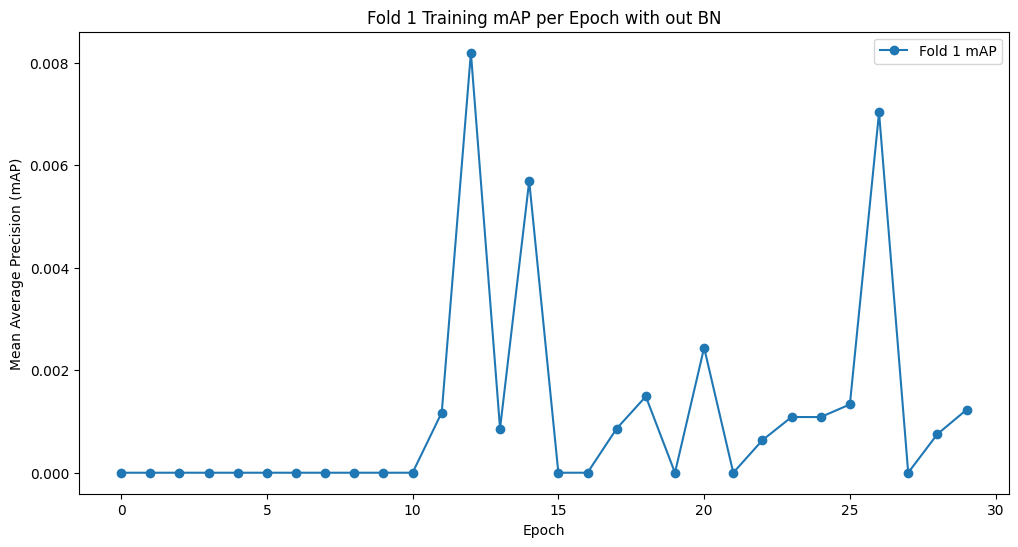

FOLD 1
--------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.23it/s, loss=142]

Mean loss was 1043.6615524291992


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:01<00:00,  4.25it/s, loss=132]

Mean loss was 936.9241358439127


Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=168]

Mean loss was 799.7165374755859


Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.28it/s, loss=86.4]

Mean loss was 579.465747833252


Validation mAP for epoch 3: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=128]

Mean loss was 467.36375681559247


Validation mAP for epoch 4: 0.0003808241926890332


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=20.3]

Mean loss was 401.14408842722577


Validation mAP for epoch 5: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.08it/s, loss=93.6]

Mean loss was 352.6947072347005


Validation mAP for epoch 6: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.79it/s, loss=14.6]

Mean loss was 317.91556819279987


Validation mAP for epoch 7: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.49it/s, loss=32.2]

Mean loss was 285.1195710500081


Validation mAP for epoch 8: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.81it/s, loss=15.2]


Mean loss was 259.52191464106244
Validation mAP for epoch 9: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=22.9]

Mean loss was 237.08484077453613


Validation mAP for epoch 10: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=12.3]

Mean loss was 217.12209701538086


Validation mAP for epoch 11: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=9.49]

Mean loss was 200.27963002522787


Validation mAP for epoch 12: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.22it/s, loss=17.3]

Mean loss was 185.69273948669434


Validation mAP for epoch 13: 0.0001493428717367351


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=30.1]

Mean loss was 171.64754645029703


Validation mAP for epoch 14: 0.000933351824642159


100%|██████████| 6/6 [00:01<00:00,  5.72it/s, loss=21.5]

Mean loss was 159.62871678670248


Validation mAP for epoch 15: 0.00010909788034041412


100%|██████████| 6/6 [00:01<00:00,  5.77it/s, loss=63.1]

Mean loss was 149.26455688476562


Validation mAP for epoch 16: 0.002068790723569691


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=27.8]

Mean loss was 144.48821640014648


Validation mAP for epoch 17: 0.001386088002618635


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=15.8]


Mean loss was 137.62253983815512
Validation mAP for epoch 18: 0.0010361713648308069


100%|██████████| 6/6 [00:01<00:00,  3.45it/s, loss=45.5]

Mean loss was 133.14782524108887


Validation mAP for epoch 19: 0.002133517467882484


100%|██████████| 6/6 [00:01<00:00,  3.38it/s, loss=5.84]

Mean loss was 130.85603245099387


Validation mAP for epoch 20: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=14.7]

Mean loss was 126.49130217234294


Validation mAP for epoch 21: 0.0035932870814576745


100%|██████████| 6/6 [00:01<00:00,  3.75it/s, loss=8.69]

Mean loss was 124.25782934824626


Validation mAP for epoch 22: 0.0006909196090418845


100%|██████████| 6/6 [00:01<00:00,  3.49it/s, loss=11.8]

Mean loss was 122.34514999389648


Validation mAP for epoch 23: 0.0029121851548552513


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=9.42]

Mean loss was 121.93643601735432


Validation mAP for epoch 24: 0.005376340821385384


100%|██████████| 6/6 [00:00<00:00,  6.14it/s, loss=16.1]

Mean loss was 121.85002326965332


Validation mAP for epoch 25: 0.0022401425521820784


100%|██████████| 6/6 [00:00<00:00,  6.02it/s, loss=10]

Mean loss was 121.4295989672343


Validation mAP for epoch 26: 0.002316824742592871


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=23]

Mean loss was 120.14182662963867


Validation mAP for epoch 27: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.67it/s, loss=10.5]

Mean loss was 122.08320999145508


Validation mAP for epoch 28: 0.0006720426608808339


100%|██████████| 6/6 [00:02<00:00,  2.06it/s, loss=5.56]

Mean loss was 119.57059653600056


Validation mAP for epoch 29: 0.0


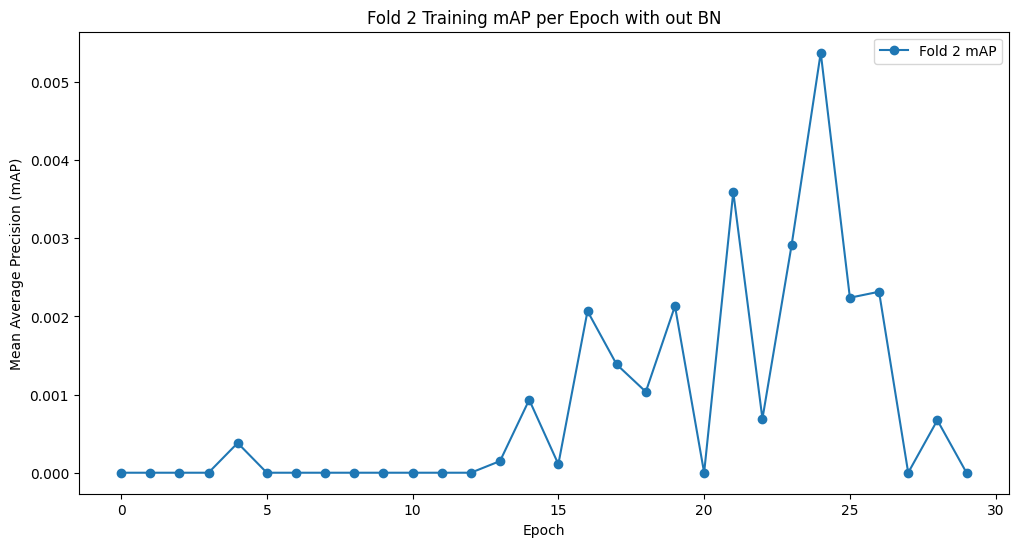

FOLD 2
--------------------------------


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=86.2]

Mean loss was 1061.8541514078777


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=100]

Mean loss was 991.682627360026


Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.14it/s, loss=56.7]

Mean loss was 857.6304969787598


Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=50.7]

Mean loss was 625.0117988586426


Validation mAP for epoch 3: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.31it/s, loss=78.1]

Mean loss was 526.910317738851


Validation mAP for epoch 4: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=65.5]

Mean loss was 462.0757471720378


Validation mAP for epoch 5: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.75it/s, loss=18]

Mean loss was 402.3977305094401


Validation mAP for epoch 6: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.29it/s, loss=51.6]

Mean loss was 364.1799723307292


Validation mAP for epoch 7: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.13it/s, loss=121]

Mean loss was 325.1863327026367


Validation mAP for epoch 8: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.08it/s, loss=14.1]

Mean loss was 296.5011444091797


Validation mAP for epoch 9: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.71it/s, loss=18.2]

Mean loss was 268.00136947631836


Validation mAP for epoch 10: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.08it/s, loss=42.1]

Mean loss was 248.57800483703613


Validation mAP for epoch 11: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.97it/s, loss=52.3]


Mean loss was 224.8591162363688
Validation mAP for epoch 12: 0.0002852915786206722


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=64.4]


Mean loss was 209.69090270996094
Validation mAP for epoch 13: 0.00037569261621683836


100%|██████████| 6/6 [00:01<00:00,  4.44it/s, loss=22.5]

Mean loss was 197.55269050598145


Validation mAP for epoch 14: 0.00023494601919082925


100%|██████████| 6/6 [00:01<00:00,  3.03it/s, loss=22.7]

Mean loss was 184.92767524719238


Validation mAP for epoch 15: 0.0012327409931458533


100%|██████████| 6/6 [00:02<00:00,  2.14it/s, loss=24.9]

Mean loss was 171.86998176574707


Validation mAP for epoch 16: 0.0002482724012224935


100%|██████████| 6/6 [00:01<00:00,  5.86it/s, loss=8.94]


Mean loss was 163.38434521357217
Validation mAP for epoch 17: 0.0002370656657149084


100%|██████████| 6/6 [00:02<00:00,  2.97it/s, loss=15.6]


Mean loss was 156.33317534128824
Validation mAP for epoch 18: 0.0001856363523984328


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=11.8]

Mean loss was 151.3203730583191


Validation mAP for epoch 19: 0.0002617204954731278


100%|██████████| 6/6 [00:01<00:00,  3.77it/s, loss=22]

Mean loss was 147.02757199605307


Validation mAP for epoch 20: 0.0003883135359501466


100%|██████████| 6/6 [00:01<00:00,  3.47it/s, loss=39.8]

Mean loss was 143.76769510904947


Validation mAP for epoch 21: 0.0008136090618791059


100%|██████████| 6/6 [00:00<00:00,  6.13it/s, loss=17.5]

Mean loss was 141.71292877197266


Validation mAP for epoch 22: 0.0006163706711959094


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=12.8]

Mean loss was 138.58086395263672


Validation mAP for epoch 23: 0.00028240986284799874


100%|██████████| 6/6 [00:02<00:00,  2.79it/s, loss=10]

Mean loss was 137.61120414733887


Validation mAP for epoch 24: 0.00016642009723000228


100%|██████████| 6/6 [00:02<00:00,  2.89it/s, loss=18.9]

Mean loss was 136.48297691345215


Validation mAP for epoch 25: 0.0003592560678953305


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=38]


Mean loss was 136.56791051228842
Validation mAP for epoch 26: 0.0003780406914302148


100%|██████████| 6/6 [00:01<00:00,  3.13it/s, loss=27.8]

Mean loss was 135.00112883249918


Validation mAP for epoch 27: 0.0001856363523984328


100%|██████████| 6/6 [00:01<00:00,  3.42it/s, loss=19.5]

Mean loss was 139.34912045796713


Validation mAP for epoch 28: 0.0002218934678239748


100%|██████████| 6/6 [00:00<00:00,  6.27it/s, loss=12.6]

Mean loss was 137.94326798121133


Validation mAP for epoch 29: 0.00034927674278151244


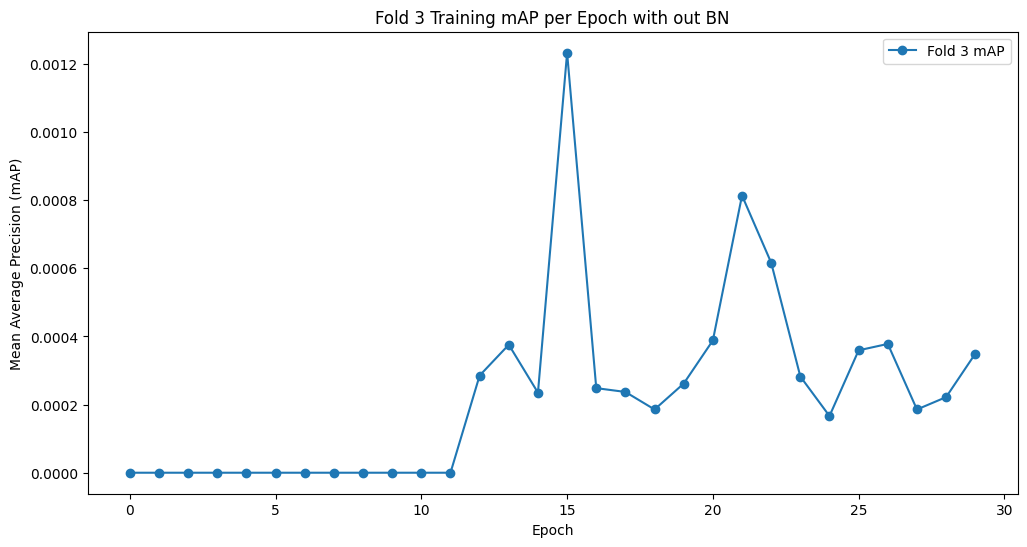

FOLD 3
--------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.32it/s, loss=179]

Mean loss was 973.7606582641602


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.75it/s, loss=167]

Mean loss was 895.7859853108724


Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.48it/s, loss=94.8]

Mean loss was 740.1817245483398


Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.10it/s, loss=116]


Mean loss was 494.89981333414715
Validation mAP for epoch 3: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.16it/s, loss=58.4]

Mean loss was 428.4577941894531


Validation mAP for epoch 4: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.18it/s, loss=74.2]


Mean loss was 393.22930399576825
Validation mAP for epoch 5: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=138]

Mean loss was 341.69375864664715


Validation mAP for epoch 6: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=49.5]

Mean loss was 301.5762545267741


Validation mAP for epoch 7: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.25it/s, loss=22.7]


Mean loss was 276.4975659052531
Validation mAP for epoch 8: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.03it/s, loss=30.3]


Mean loss was 245.97558625539145
Validation mAP for epoch 9: 0.004398143384605646


100%|██████████| 6/6 [00:01<00:00,  4.81it/s, loss=68.3]


Mean loss was 221.7788403828939
Validation mAP for epoch 10: 0.0010967809648718685


100%|██████████| 6/6 [00:00<00:00,  6.27it/s, loss=43]


Mean loss was 204.8577423095703
Validation mAP for epoch 11: 6.523568663396873e-05


100%|██████████| 6/6 [00:01<00:00,  3.49it/s, loss=33.3]

Mean loss was 187.7595074971517


Validation mAP for epoch 12: 0.005902772536501288


100%|██████████| 6/6 [00:01<00:00,  3.35it/s, loss=65.5]


Mean loss was 174.68329874674478
Validation mAP for epoch 13: 0.005694439634680748


100%|██████████| 6/6 [00:02<00:00,  2.70it/s, loss=35.6]


Mean loss was 164.69177436828613
Validation mAP for epoch 14: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.69it/s, loss=57.1]

Mean loss was 156.082789738973


Validation mAP for epoch 15: 0.00018155405086872634


100%|██████████| 6/6 [00:02<00:00,  2.91it/s, loss=42.6]


Mean loss was 147.4308204650879
Validation mAP for epoch 16: 7.71604900364764e-05


100%|██████████| 6/6 [00:01<00:00,  3.96it/s, loss=14.6]

Mean loss was 141.4586876233419


Validation mAP for epoch 17: 7.716048276051879e-05


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=10.9]

Mean loss was 136.84425767262778


Validation mAP for epoch 18: 7.16490249033086e-05


100%|██████████| 6/6 [00:01<00:00,  3.26it/s, loss=15.9]


Mean loss was 133.4424680074056
Validation mAP for epoch 19: 0.0003472220923868008


100%|██████████| 6/6 [00:00<00:00,  6.06it/s, loss=21.8]

Mean loss was 128.65047963460287


Validation mAP for epoch 20: 8.838383291731589e-05


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=58.6]


Mean loss was 125.80241139729817
Validation mAP for epoch 21: 8.838383291731589e-05


100%|██████████| 6/6 [00:01<00:00,  4.23it/s, loss=22.6]


Mean loss was 123.97702471415202
Validation mAP for epoch 22: 4.886830720352009e-05


100%|██████████| 6/6 [00:01<00:00,  3.41it/s, loss=21.7]

Mean loss was 122.83107503255208


Validation mAP for epoch 23: 7.201645348686725e-05


100%|██████████| 6/6 [00:01<00:00,  3.48it/s, loss=24.8]

Mean loss was 119.63569037119548


Validation mAP for epoch 24: 6.430040593841113e-05


100%|██████████| 6/6 [00:00<00:00,  6.20it/s, loss=19.3]


Mean loss was 117.9530684153239
Validation mAP for epoch 25: 0.0002604165583761642


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=17.7]

Mean loss was 118.36834081013997


Validation mAP for epoch 26: 0.00011757788161048666


100%|██████████| 6/6 [00:01<00:00,  3.29it/s, loss=27.2]

Mean loss was 116.04579035441081


Validation mAP for epoch 27: 0.0018518510041758418


100%|██████████| 6/6 [00:00<00:00,  6.11it/s, loss=14.6]

Mean loss was 114.48602135976155


Validation mAP for epoch 28: 0.00014403289969777688


100%|██████████| 6/6 [00:01<00:00,  3.78it/s, loss=15.1]

Mean loss was 114.23584191004436


Validation mAP for epoch 29: 8.066778536885977e-05


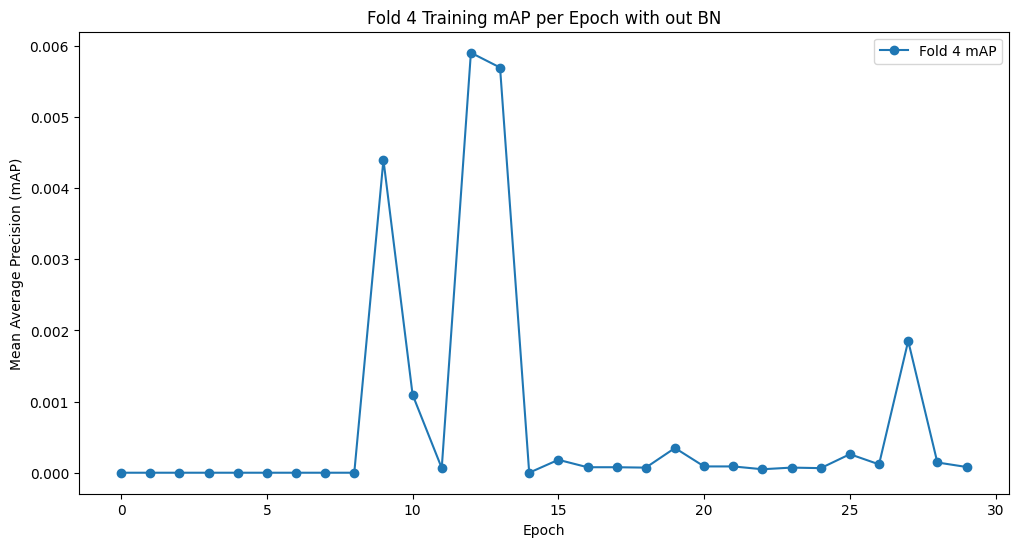

FOLD 4
--------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.32it/s, loss=277]

Mean loss was 1105.9454040527344


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.06it/s, loss=198]

Mean loss was 998.7474161783854


Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.17it/s, loss=115]


Mean loss was 794.9430491129557
Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.73it/s, loss=91]

Mean loss was 587.8903363545736


Validation mAP for epoch 3: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=56.7]

Mean loss was 502.0099328358968


Validation mAP for epoch 4: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.39it/s, loss=125]


Mean loss was 454.6197052001953
Validation mAP for epoch 5: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.32it/s, loss=119]


Mean loss was 407.7858708699544
Validation mAP for epoch 6: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.23it/s, loss=58.9]


Mean loss was 367.46515973409015
Validation mAP for epoch 7: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=41.6]


Mean loss was 336.10536257425946
Validation mAP for epoch 8: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.73it/s, loss=84.4]

Mean loss was 303.4202054341634


Validation mAP for epoch 9: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.52it/s, loss=50.2]

Mean loss was 278.76880645751953


Validation mAP for epoch 10: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.99it/s, loss=49.3]


Mean loss was 256.33668454488117
Validation mAP for epoch 11: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.04it/s, loss=62.5]


Mean loss was 236.00782839457193
Validation mAP for epoch 12: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=61.1]

Mean loss was 219.7918790181478


Validation mAP for epoch 13: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.40it/s, loss=29.7]


Mean loss was 209.42758433024088
Validation mAP for epoch 14: 0.001785713597200811


100%|██████████| 6/6 [00:01<00:00,  4.87it/s, loss=16.3]


Mean loss was 195.65624364217123
Validation mAP for epoch 15: 0.0012244893587194383


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=49.1]


Mean loss was 189.2205327351888
Validation mAP for epoch 16: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.71it/s, loss=29.5]

Mean loss was 183.93914699554443


Validation mAP for epoch 17: 0.0011607138731051236


100%|██████████| 6/6 [00:01<00:00,  3.27it/s, loss=37.1]

Mean loss was 181.35203806559244


Validation mAP for epoch 18: 0.0015686265542171896


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=24.3]

Mean loss was 176.54513676961264


Validation mAP for epoch 19: 0.0010204078862443566


100%|██████████| 6/6 [00:00<00:00,  6.15it/s, loss=12.7]


Mean loss was 172.06486956278482
Validation mAP for epoch 20: 0.0005527209723368287


100%|██████████| 6/6 [00:01<00:00,  3.10it/s, loss=11.9]

Mean loss was 166.1167451540629


Validation mAP for epoch 21: 0.000529827200807631


100%|██████████| 6/6 [00:01<00:00,  3.27it/s, loss=51.4]


Mean loss was 163.49615859985352
Validation mAP for epoch 22: 0.0014880947419442236


100%|██████████| 6/6 [00:00<00:00,  6.08it/s, loss=16.5]

Mean loss was 160.84785429636636


Validation mAP for epoch 23: 0.0007539680518675596


100%|██████████| 6/6 [00:01<00:00,  3.47it/s, loss=31.1]

Mean loss was 157.55536715189615


Validation mAP for epoch 24: 0.001785713480785489


100%|██████████| 6/6 [00:00<00:00,  6.23it/s, loss=34.6]


Mean loss was 158.38801701863608
Validation mAP for epoch 25: 0.0004848091775784269


100%|██████████| 6/6 [00:01<00:00,  3.45it/s, loss=18.2]


Mean loss was 156.73290411631265
Validation mAP for epoch 26: 0.0005208332004258409


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=25.1]

Mean loss was 156.3075656890869


Validation mAP for epoch 27: 0.0020833323360420763


100%|██████████| 6/6 [00:01<00:00,  4.78it/s, loss=27.1]

Mean loss was 155.8098611831665


Validation mAP for epoch 28: 0.008928565075621009


100%|██████████| 6/6 [00:00<00:00,  6.26it/s, loss=33.9]

Mean loss was 152.73797353108725


Validation mAP for epoch 29: 0.0005128203774802387


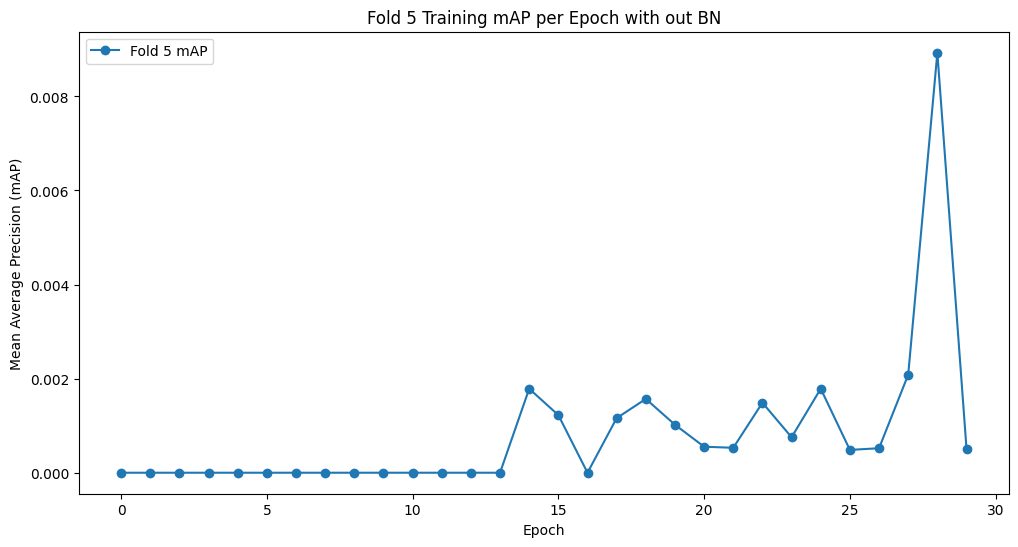

Average Validation mAP across all folds: 0.000434161999146454


In [40]:
seed = 123
torch.manual_seed(seed)

# Hyperparameters etc.
LEARNING_RATE = 2e-5
#DEVICE = "cuda" if torch.cuda.is_available else "cpu" #"cpu"#
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 30 #1000
NUM_WORKERS = 2

# Hyperparameters etc.
model = Yolov1_WO_BN(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss()

if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

train_dataset = VOCDataset(
    "100examples.csv",
    transform=transform,
    img_dir=IMG_DIR,
    label_dir=LABEL_DIR,
)

test_dataset = VOCDataset(
    "test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
)


k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=seed)
fold_results = []

# Collect the fold performance for plotting
fold_performance_history = []

for fold, (train_ids, valid_ids) in enumerate(kf.split(np.arange(len(train_dataset)))):
    print(f'FOLD {fold}')
    print('--------------------------------')

    fold_epoch_mAPs = []  # Store mAP for each epoch within this fold

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    valid_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    # Initialize the model and optimizer for this fold
    model = Yolov1_WO_BN(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    loss_fn = YoloLoss().to(DEVICE)

    for epoch in range(EPOCHS):

        # Train for current epoch
        train_fn(train_loader, model, optimizer, loss_fn)

        valid_mAPs = []
        model.eval()
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(valid_loader):
                x, y = x.to(DEVICE), y.to(DEVICE)
                predictions = model(x)
                # Calculate mAP
                pred_boxes, target_boxes = get_bboxes(valid_loader, model, iou_threshold=0.5, threshold=0.4)
                valid_mAP = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
                valid_mAPs.append(valid_mAP.item())

        # Calculate average mAP for the validation set
        avg_valid_mAP = sum(valid_mAPs) / len(valid_mAPs)
        print(f"Validation mAP for epoch {epoch}: {avg_valid_mAP}")

        fold_epoch_mAPs.append(avg_valid_mAP)

        model.train()

    fold_results.append(avg_valid_mAP)

    plt.figure(figsize=(12, 6))
    plt.plot(range(EPOCHS), fold_epoch_mAPs, marker='o', label=f'Fold {fold+1} mAP')
    plt.title(f'Fold {fold+1} Training mAP per Epoch with out BN')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Average Precision (mAP)')
    plt.legend()
    plt.show()

    fold_results.append(fold_epoch_mAPs[-1])


average_performance = sum(fold_results) / len(fold_results)
print(f'Average Validation mAP across all folds: {average_performance}')


FOLD 0
--------------------------------


100%|██████████| 6/6 [00:02<00:00,  2.66it/s, loss=208]

Mean loss was 1118.1130549112956


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.17it/s, loss=133]

Mean loss was 511.86581166585285


Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=14.9]

Mean loss was 353.5982042948405


Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.96it/s, loss=74.7]

Mean loss was 290.85364532470703


Validation mAP for epoch 3: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.17it/s, loss=18.1]

Mean loss was 246.97283458709717


Validation mAP for epoch 4: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.77it/s, loss=45]

Mean loss was 221.3544546763102


Validation mAP for epoch 5: 0.00017874750483315438


100%|██████████| 6/6 [00:01<00:00,  3.16it/s, loss=9.54]

Mean loss was 204.06120793024698


Validation mAP for epoch 6: 0.00017431396554457024


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=18.3]

Mean loss was 186.81287129720053


Validation mAP for epoch 7: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.26it/s, loss=19.5]

Mean loss was 176.73027229309082


Validation mAP for epoch 8: 0.005644630407914519


100%|██████████| 6/6 [00:01<00:00,  3.41it/s, loss=16.2]

Mean loss was 168.43283398946127


Validation mAP for epoch 9: 0.0009787821909412742


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=38.2]

Mean loss was 165.2177963256836


Validation mAP for epoch 10: 0.001366704294923693


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=17.9]

Mean loss was 160.313619295756


Validation mAP for epoch 11: 0.000783729221438989


100%|██████████| 6/6 [00:01<00:00,  5.79it/s, loss=42.1]

Mean loss was 157.6743590037028


Validation mAP for epoch 12: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.82it/s, loss=28.8]

Mean loss was 159.38890425364175


Validation mAP for epoch 13: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.80it/s, loss=11.8]

Mean loss was 152.53979523976645


Validation mAP for epoch 14: 0.004754645051434636


100%|██████████| 6/6 [00:03<00:00,  1.71it/s, loss=46.9]

Mean loss was 151.51640510559082


Validation mAP for epoch 15: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.01it/s, loss=7.57]

Mean loss was 148.7994548479716


Validation mAP for epoch 16: 0.007956719025969505


100%|██████████| 6/6 [00:00<00:00,  6.04it/s, loss=5.88]

Mean loss was 152.03612089157104


Validation mAP for epoch 17: 0.00386943289777264


100%|██████████| 6/6 [00:00<00:00,  6.22it/s, loss=13]

Mean loss was 151.48112201690674


Validation mAP for epoch 18: 0.005530061898753047


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=13.7]

Mean loss was 143.3471040725708


Validation mAP for epoch 19: 0.0010953709424939007


100%|██████████| 6/6 [00:01<00:00,  3.47it/s, loss=5.52]

Mean loss was 146.14113863309225


Validation mAP for epoch 20: 0.00024475521058775485


100%|██████████| 6/6 [00:01<00:00,  5.73it/s, loss=33.9]

Mean loss was 147.27566846211752


Validation mAP for epoch 21: 0.0014233422989491373


100%|██████████| 6/6 [00:01<00:00,  3.51it/s, loss=18.2]

Mean loss was 150.38684527079263


Validation mAP for epoch 22: 0.0029099169187247753


100%|██████████| 6/6 [00:01<00:00,  5.88it/s, loss=39]

Mean loss was 154.21676699320474


Validation mAP for epoch 23: 0.0021775439963676035


100%|██████████| 6/6 [00:00<00:00,  6.14it/s, loss=9.05]

Mean loss was 140.57222588857016


Validation mAP for epoch 24: 0.0015789512544870377


100%|██████████| 6/6 [00:00<00:00,  6.29it/s, loss=22.4]

Mean loss was 140.51013247172037


Validation mAP for epoch 25: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=17.2]

Mean loss was 143.2065575917562


Validation mAP for epoch 26: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.86it/s, loss=16.1]

Mean loss was 140.3870620727539


Validation mAP for epoch 27: 0.0011019532976206392


100%|██████████| 6/6 [00:01<00:00,  3.65it/s, loss=16.3]

Mean loss was 138.93217436472574


Validation mAP for epoch 28: 0.0014650135417468846


100%|██████████| 6/6 [00:02<00:00,  2.98it/s, loss=29]

Mean loss was 141.25232283274332


Validation mAP for epoch 29: 0.0009479678992647678


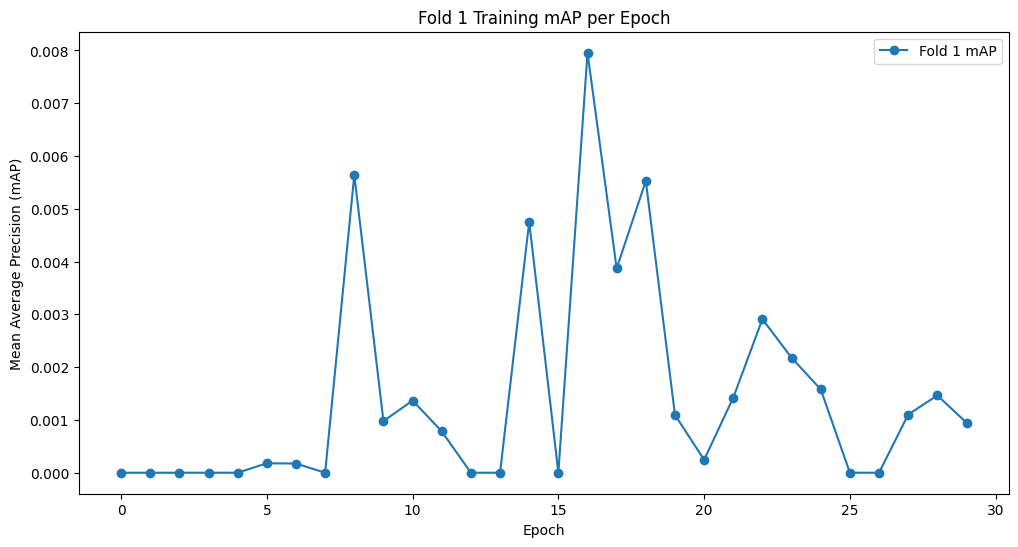

FOLD 1
--------------------------------


100%|██████████| 6/6 [00:02<00:00,  2.75it/s, loss=81.1]

Mean loss was 1160.405522664388


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.62it/s, loss=64.9]

Mean loss was 475.5043665568034


Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.58it/s, loss=79.5]

Mean loss was 331.4585418701172


Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.86it/s, loss=36.5]

Mean loss was 278.53979937235516


Validation mAP for epoch 3: 0.00016801072342786938


100%|██████████| 6/6 [00:01<00:00,  3.59it/s, loss=88.5]

Mean loss was 253.9010098775228


Validation mAP for epoch 4: 0.03338977973908186


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=8.11]

Mean loss was 221.98609177271524


Validation mAP for epoch 5: 0.0001493428644607775


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=44.1]

Mean loss was 204.48271814982095


Validation mAP for epoch 6: 0.00016801072342786938


100%|██████████| 6/6 [00:01<00:00,  4.47it/s, loss=6.98]


Mean loss was 188.50767119725546
Validation mAP for epoch 7: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=22.6]

Mean loss was 186.66757488250732


Validation mAP for epoch 8: 0.0003954282947233878


100%|██████████| 6/6 [00:00<00:00,  6.15it/s, loss=7.94]

Mean loss was 163.72581593195596


Validation mAP for epoch 9: 3.584866499295458e-05


100%|██████████| 6/6 [00:00<00:00,  6.18it/s, loss=14]

Mean loss was 163.4192589124044


Validation mAP for epoch 10: 0.0011101150885224342


100%|██████████| 6/6 [00:01<00:00,  3.05it/s, loss=7.44]

Mean loss was 156.0201268196106


Validation mAP for epoch 11: 0.08333321660757065


100%|██████████| 6/6 [00:01<00:00,  3.42it/s, loss=8.93]

Mean loss was 155.1718578338623


Validation mAP for epoch 12: 0.00020801326900254935


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=13.2]

Mean loss was 144.67161719004312


Validation mAP for epoch 13: 0.0007968172430992126


100%|██████████| 6/6 [00:00<00:00,  6.14it/s, loss=28.8]

Mean loss was 151.6464745203654


Validation mAP for epoch 14: 0.00017394051246810704


100%|██████████| 6/6 [00:00<00:00,  6.18it/s, loss=17.7]

Mean loss was 142.22006289164224


Validation mAP for epoch 15: 0.00013800880333292298


100%|██████████| 6/6 [00:01<00:00,  3.62it/s, loss=48.9]

Mean loss was 135.79385884602866


Validation mAP for epoch 16: 0.00044802852789871395


100%|██████████| 6/6 [00:00<00:00,  6.20it/s, loss=24.5]

Mean loss was 133.64038530985513


Validation mAP for epoch 17: 0.0002720173324632924


100%|██████████| 6/6 [00:00<00:00,  6.07it/s, loss=15.8]

Mean loss was 141.88595612843832


Validation mAP for epoch 18: 0.00026305993378628045


100%|██████████| 6/6 [00:01<00:00,  5.18it/s, loss=44.4]

Mean loss was 138.62573369344076


Validation mAP for epoch 19: 0.0


100%|██████████| 6/6 [00:01<00:00,  4.81it/s, loss=8.76]

Mean loss was 133.54549725850424


Validation mAP for epoch 20: 0.00028001785540254787


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=18.4]

Mean loss was 139.96942933400473


Validation mAP for epoch 21: 0.0026881706435233355


100%|██████████| 6/6 [00:00<00:00,  6.26it/s, loss=7.56]

Mean loss was 136.5876940091451


Validation mAP for epoch 22: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.22it/s, loss=11.8]

Mean loss was 131.02367877960205


Validation mAP for epoch 23: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=9.43]

Mean loss was 132.44838301340738


Validation mAP for epoch 24: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.17it/s, loss=13.9]

Mean loss was 132.45911089579263


Validation mAP for epoch 25: 0.00066137540852651


100%|██████████| 6/6 [00:01<00:00,  4.78it/s, loss=8.6]

Mean loss was 132.81842676798502


Validation mAP for epoch 26: 0.01121797226369381


100%|██████████| 6/6 [00:00<00:00,  6.31it/s, loss=22.6]

Mean loss was 132.16077327728271


Validation mAP for epoch 27: 0.0


100%|██████████| 6/6 [00:01<00:00,  4.83it/s, loss=9.73]

Mean loss was 130.49309476216635


Validation mAP for epoch 28: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.45it/s, loss=3.96]


Mean loss was 134.74710675080618
Validation mAP for epoch 29: 0.0001127904215536546


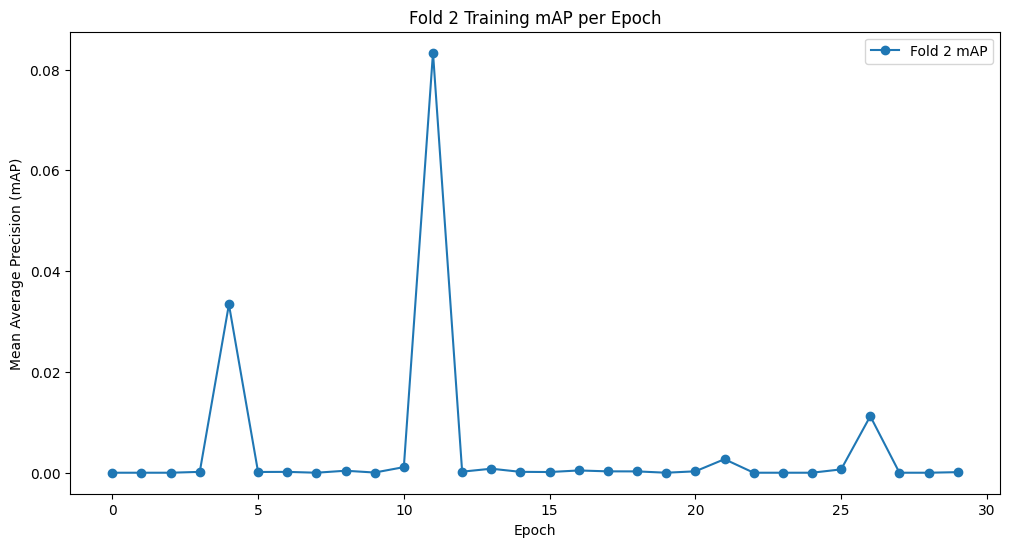

FOLD 2
--------------------------------


100%|██████████| 6/6 [00:02<00:00,  2.15it/s, loss=62.9]

Mean loss was 1278.8579972585042


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:01<00:00,  5.92it/s, loss=66]


Mean loss was 581.7289950052897
Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.31it/s, loss=35.5]

Mean loss was 398.9352175394694


Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=33.3]

Mean loss was 328.30310503641766


Validation mAP for epoch 3: 0.002163460594601929


100%|██████████| 6/6 [00:00<00:00,  6.19it/s, loss=36.1]

Mean loss was 275.77818934122723


Validation mAP for epoch 4: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.33it/s, loss=35.1]

Mean loss was 239.21816380818686


Validation mAP for epoch 5: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.70it/s, loss=17]

Mean loss was 232.5924860636393


Validation mAP for epoch 6: 0.0028846136410720646


100%|██████████| 6/6 [00:01<00:00,  4.96it/s, loss=26.5]

Mean loss was 225.68444887797037


Validation mAP for epoch 7: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=57.5]

Mean loss was 190.66515922546387


Validation mAP for epoch 8: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.50it/s, loss=11.5]

Mean loss was 189.00802564620972


Validation mAP for epoch 9: 0.001201922306790948


100%|██████████| 6/6 [00:00<00:00,  6.18it/s, loss=12.8]

Mean loss was 181.55313142140707


Validation mAP for epoch 10: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.28it/s, loss=30.5]

Mean loss was 171.61128362019858


Validation mAP for epoch 11: 0.00023011174198472872


100%|██████████| 6/6 [00:02<00:00,  2.70it/s, loss=44.1]


Mean loss was 165.7175661722819
Validation mAP for epoch 12: 0.0008321001805597916


100%|██████████| 6/6 [00:01<00:00,  4.05it/s, loss=33.8]

Mean loss was 160.8518886566162


Validation mAP for epoch 13: 0.006750938016921282


100%|██████████| 6/6 [00:01<00:00,  4.00it/s, loss=20.5]

Mean loss was 155.9115228652954


Validation mAP for epoch 14: 0.003045595331059303


100%|██████████| 6/6 [00:02<00:00,  2.68it/s, loss=23.7]

Mean loss was 158.59438196818033


Validation mAP for epoch 15: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.71it/s, loss=19.8]

Mean loss was 150.9655055999756


Validation mAP for epoch 16: 0.0004314594843890518


100%|██████████| 6/6 [00:01<00:00,  4.27it/s, loss=8.52]

Mean loss was 166.50848849614462


Validation mAP for epoch 17: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.38it/s, loss=13.4]

Mean loss was 148.18866602579752


Validation mAP for epoch 18: 0.0008629188232589513


100%|██████████| 6/6 [00:01<00:00,  3.55it/s, loss=11.1]

Mean loss was 146.39963388442993


Validation mAP for epoch 19: 0.0006163706711959094


100%|██████████| 6/6 [00:01<00:00,  3.58it/s, loss=20.3]

Mean loss was 145.10751310984293


Validation mAP for epoch 20: 0.00020492325711529702


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=41.7]

Mean loss was 157.57134691874185


Validation mAP for epoch 21: 0.0001878463153843768


100%|██████████| 6/6 [00:01<00:00,  3.33it/s, loss=18.2]

Mean loss was 146.57428042093912


Validation mAP for epoch 22: 0.0006656803307123482


100%|██████████| 6/6 [00:00<00:00,  6.21it/s, loss=14.5]

Mean loss was 146.68684228261313


Validation mAP for epoch 23: 0.0004314594843890518


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=9]

Mean loss was 140.81320158640543


Validation mAP for epoch 24: 0.0030290206632344052


100%|██████████| 6/6 [00:00<00:00,  6.33it/s, loss=19.1]

Mean loss was 140.64233239491782


Validation mAP for epoch 25: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.32it/s, loss=41.8]

Mean loss was 139.354221979777


Validation mAP for epoch 26: 0.003698222863022238


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=29.6]

Mean loss was 138.34483655293783


Validation mAP for epoch 27: 0.00017947264859685674


100%|██████████| 6/6 [00:01<00:00,  3.32it/s, loss=20]

Mean loss was 137.01375325520834


Validation mAP for epoch 28: 0.0025935908197425306


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=14.3]

Mean loss was 139.4004284540812


Validation mAP for epoch 29: 0.0003122945054201409


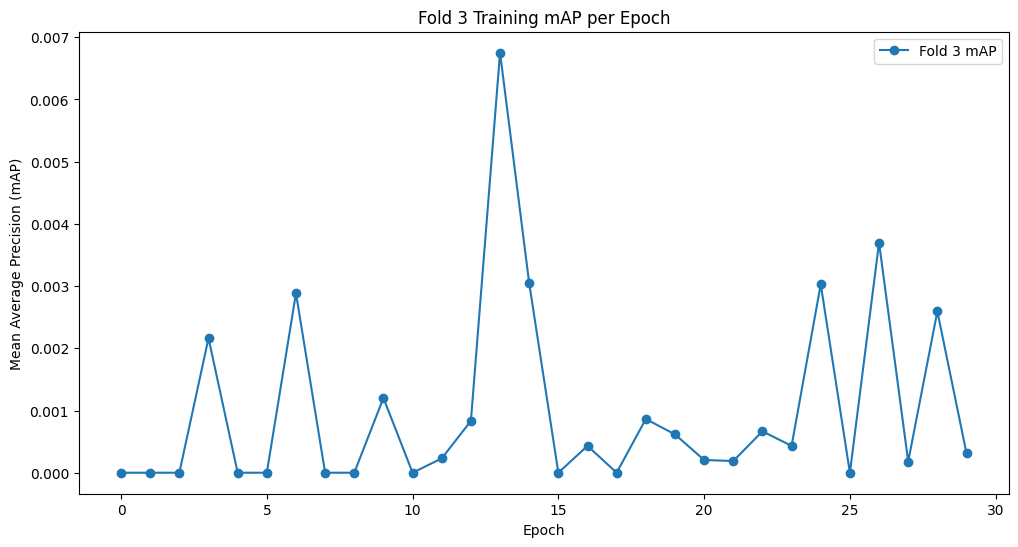

FOLD 3
--------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.34it/s, loss=107]

Mean loss was 1051.911382039388


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.05it/s, loss=58.4]

Mean loss was 445.5548152923584


Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.14it/s, loss=33.6]


Mean loss was 325.73564465840656
Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.08it/s, loss=63.5]

Mean loss was 274.8088188171387


Validation mAP for epoch 3: 0.00011243385233683512


100%|██████████| 6/6 [00:00<00:00,  6.11it/s, loss=25.3]

Mean loss was 232.08922863006592


Validation mAP for epoch 4: 0.00011757788161048666


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=35.8]

Mean loss was 197.741673151652


Validation mAP for epoch 5: 0.009441126603633165


100%|██████████| 6/6 [00:01<00:00,  3.41it/s, loss=76.7]


Mean loss was 179.28921763102213
Validation mAP for epoch 6: 0.009445651900023222


100%|██████████| 6/6 [00:01<00:00,  5.79it/s, loss=25.8]

Mean loss was 164.7382755279541


Validation mAP for epoch 7: 0.0001414608777849935


100%|██████████| 6/6 [00:01<00:00,  3.43it/s, loss=16.8]


Mean loss was 158.77594566345215
Validation mAP for epoch 8: 0.0008996209071483463


100%|██████████| 6/6 [00:00<00:00,  6.07it/s, loss=22.6]

Mean loss was 153.22770055135092


Validation mAP for epoch 9: 0.016666656360030174


100%|██████████| 6/6 [00:00<00:00,  6.12it/s, loss=45.3]

Mean loss was 145.9203847249349


Validation mAP for epoch 10: 8.487653758493252e-05


100%|██████████| 6/6 [00:00<00:00,  6.01it/s, loss=38]

Mean loss was 142.98150952657065


Validation mAP for epoch 11: 7.295173782040365e-05


100%|██████████| 6/6 [00:01<00:00,  3.50it/s, loss=25.1]

Mean loss was 135.15291500091553


Validation mAP for epoch 12: 0.00014467589971900452


100%|██████████| 6/6 [00:00<00:00,  6.09it/s, loss=56.6]

Mean loss was 131.01728630065918


Validation mAP for epoch 13: 0.0001157407314167358


100%|██████████| 6/6 [00:00<00:00,  6.23it/s, loss=36.8]


Mean loss was 130.29346466064453
Validation mAP for epoch 14: 0.00014329804253065959


100%|██████████| 6/6 [00:00<00:00,  6.06it/s, loss=49.9]

Mean loss was 130.1786791483561


Validation mAP for epoch 15: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.07it/s, loss=39.2]

Mean loss was 138.31306521097818


Validation mAP for epoch 16: 5.616829730570316e-05


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=13.8]

Mean loss was 125.55741039911906


Validation mAP for epoch 17: 0.0009516456630080938


100%|██████████| 6/6 [00:01<00:00,  3.25it/s, loss=12.6]

Mean loss was 121.95127789179485


Validation mAP for epoch 18: 0.00010931068754871376


100%|██████████| 6/6 [00:02<00:00,  2.65it/s, loss=17.4]

Mean loss was 121.27727381388347


Validation mAP for epoch 19: 0.0001240079254785087


100%|██████████| 6/6 [00:00<00:00,  6.29it/s, loss=17.4]

Mean loss was 121.76279322306316


Validation mAP for epoch 20: 6.751542787242215e-05


100%|██████████| 6/6 [00:01<00:00,  4.25it/s, loss=54.9]

Mean loss was 118.07240613301595


Validation mAP for epoch 21: 6.393297735485248e-05


100%|██████████| 6/6 [00:00<00:00,  6.11it/s, loss=25.3]

Mean loss was 118.80154546101888


Validation mAP for epoch 22: 4.629629256669432e-05


100%|██████████| 6/6 [00:00<00:00,  6.24it/s, loss=23.1]

Mean loss was 122.46868419647217


Validation mAP for epoch 23: 7.867343629186507e-05


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=30.5]


Mean loss was 122.9812707901001
Validation mAP for epoch 24: 7.867343629186507e-05


100%|██████████| 6/6 [00:00<00:00,  6.29it/s, loss=17.7]

Mean loss was 117.79731877644856


Validation mAP for epoch 25: 0.00010030862904386595


100%|██████████| 6/6 [00:00<00:00,  6.14it/s, loss=26.7]

Mean loss was 124.93117682139079


Validation mAP for epoch 26: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.55it/s, loss=28.2]

Mean loss was 120.07717863718669


Validation mAP for epoch 27: 0.00016975306061794981


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=16.4]

Mean loss was 123.31057230631511


Validation mAP for epoch 28: 5.80973119213013e-05


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=16.3]

Mean loss was 116.89084529876709


Validation mAP for epoch 29: 0.00010288064368069172


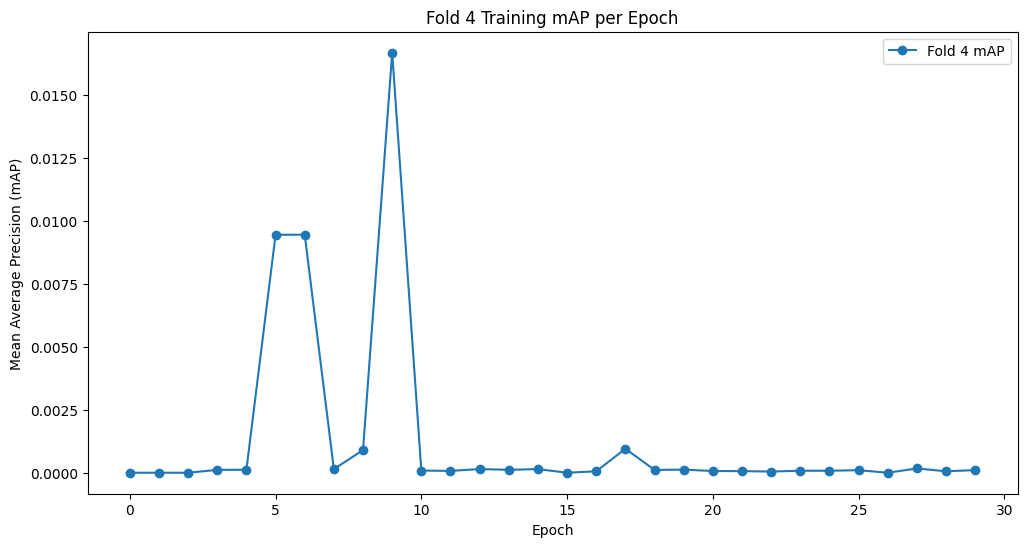

FOLD 4
--------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.39it/s, loss=191]

Mean loss was 1144.9334665934246


Validation mAP for epoch 0: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.09it/s, loss=95.4]

Mean loss was 577.6642990112305


Validation mAP for epoch 1: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.31it/s, loss=68.9]

Mean loss was 408.30407333374023


Validation mAP for epoch 2: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.68it/s, loss=47.8]

Mean loss was 326.1340688069661


Validation mAP for epoch 3: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.12it/s, loss=29.2]

Mean loss was 284.994083404541


Validation mAP for epoch 4: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.14it/s, loss=85.9]

Mean loss was 255.08633168538412


Validation mAP for epoch 5: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.33it/s, loss=77.9]

Mean loss was 242.20050303141275


Validation mAP for epoch 6: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=30]

Mean loss was 225.3107999165853


Validation mAP for epoch 7: 0.0


100%|██████████| 6/6 [00:01<00:00,  3.74it/s, loss=29.9]

Mean loss was 209.43428103129068


Validation mAP for epoch 8: 0.0005126451287651435


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=54.7]

Mean loss was 213.38755671183267


Validation mAP for epoch 9: 0.0004613094060914591


100%|██████████| 6/6 [00:00<00:00,  6.00it/s, loss=39.4]


Mean loss was 197.51134490966797
Validation mAP for epoch 10: 0.0014030607417225838


100%|██████████| 6/6 [00:00<00:00,  6.18it/s, loss=49.6]


Mean loss was 190.10403188069662
Validation mAP for epoch 11: 0.0004613094060914591


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=46.9]

Mean loss was 186.58665148417154


Validation mAP for epoch 12: 0.0008928567986004055


100%|██████████| 6/6 [00:01<00:00,  3.23it/s, loss=57.4]

Mean loss was 182.2161725362142


Validation mAP for epoch 13: 0.0


100%|██████████| 6/6 [00:00<00:00,  6.06it/s, loss=30.7]

Mean loss was 177.91763178507486


Validation mAP for epoch 14: 0.0020833323360420763


100%|██████████| 6/6 [00:00<00:00,  6.26it/s, loss=15.7]

Mean loss was 182.5822059313456


Validation mAP for epoch 15: 0.0017006794805638492


100%|██████████| 6/6 [00:00<00:00,  6.31it/s, loss=40.1]

Mean loss was 174.06569226582846


Validation mAP for epoch 16: 0.00238095095846802


100%|██████████| 6/6 [00:01<00:00,  3.58it/s, loss=24.5]

Mean loss was 171.3147211074829


Validation mAP for epoch 17: 0.0012244893587194383


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=38.7]

Mean loss was 169.5028508504232


Validation mAP for epoch 18: 0.0016071422141976655


100%|██████████| 6/6 [00:01<00:00,  4.77it/s, loss=23.5]

Mean loss was 167.44969685872397


Validation mAP for epoch 19: 0.0003665412514237687


100%|██████████| 6/6 [00:01<00:00,  3.48it/s, loss=15.5]

Mean loss was 184.66431331634521


Validation mAP for epoch 20: 0.0024999984307214618


100%|██████████| 6/6 [00:01<00:00,  3.37it/s, loss=11.9]

Mean loss was 163.46442858378092


Validation mAP for epoch 21: 0.0013095233589410782


100%|██████████| 6/6 [00:02<00:00,  2.70it/s, loss=46.8]

Mean loss was 167.50093205769858


Validation mAP for epoch 22: 0.0007440474291797727


100%|██████████| 6/6 [00:00<00:00,  6.08it/s, loss=15.3]

Mean loss was 168.55480178197226


Validation mAP for epoch 23: 0.0005627704376820475


100%|██████████| 6/6 [00:01<00:00,  4.92it/s, loss=34.8]

Mean loss was 165.36141649881998


Validation mAP for epoch 24: 0.0035714260302484035


100%|██████████| 6/6 [00:02<00:00,  2.88it/s, loss=32.8]

Mean loss was 162.64730008443198


Validation mAP for epoch 25: 0.0009126980585278943


100%|██████████| 6/6 [00:01<00:00,  3.80it/s, loss=20.6]

Mean loss was 160.62083784739175


Validation mAP for epoch 26: 0.00045351464359555393


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=29.7]

Mean loss was 161.93058013916016


Validation mAP for epoch 27: 0.0016071422141976655


100%|██████████| 6/6 [00:00<00:00,  6.08it/s, loss=24.5]


Mean loss was 156.81153869628906
Validation mAP for epoch 28: 0.004093302530236542


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=38.1]

Mean loss was 173.12482325236002


Validation mAP for epoch 29: 0.0003665412514237687


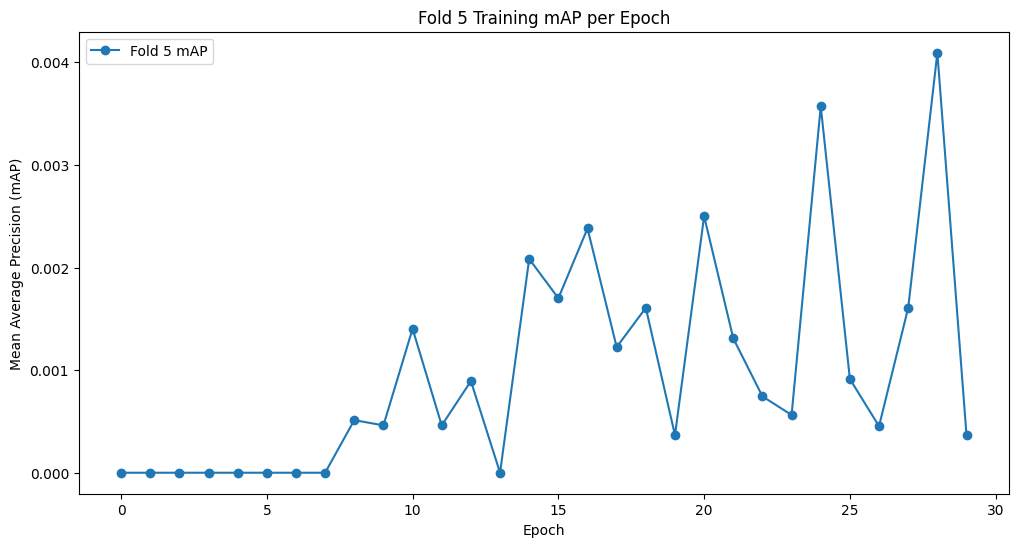

Average Validation mAP across all folds: 0.00036849494426860474


In [44]:
seed = 123
torch.manual_seed(seed)

# Hyperparameters etc.
LEARNING_RATE = 2e-5
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 30 #1000
NUM_WORKERS = 2


# Hyperparameters etc.
model_RMSP = Yolov1_WO_BN(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.RMSprop(
    model_RMSP.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss()

if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model_RMSP, optimizer)

train_dataset = VOCDataset(
    "100examples.csv",
    transform=transform,
    img_dir=IMG_DIR,
    label_dir=LABEL_DIR,
)

test_dataset = VOCDataset(
    "test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
)

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=seed)
fold_results = []

# Collect the fold performance for plotting
fold_performance_history = []

for fold, (train_ids, valid_ids) in enumerate(kf.split(np.arange(len(train_dataset)))):
    print(f'FOLD {fold}')
    print('--------------------------------')

    fold_epoch_mAPs = []  # Store mAP for each epoch within this fold

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = SubsetRandomSampler(train_ids)
    valid_subsampler = SubsetRandomSampler(valid_ids)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    valid_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    # Initialize the model and optimizer for this fold
    model_RMSP = Yolov1_WO_BN(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.RMSprop(model_RMSP.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    loss_fn = YoloLoss().to(DEVICE)


    for epoch in range(EPOCHS):

        # Train for one epoch
        train_fn(train_loader, model_RMSP, optimizer, loss_fn)

        valid_mAPs = []
        model_RMSP.eval()
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(valid_loader):
                x, y = x.to(DEVICE), y.to(DEVICE)
                predictions = model_RMSP(x)
                # Calculate mAP
                pred_boxes, target_boxes = get_bboxes(valid_loader, model_RMSP, iou_threshold=0.5, threshold=0.4)
                valid_mAP = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
                valid_mAPs.append(valid_mAP.item())

        # Calculate average mAP for the validation set
        avg_valid_mAP = sum(valid_mAPs) / len(valid_mAPs)
        print(f"Validation mAP for epoch {epoch}: {avg_valid_mAP}")

        fold_epoch_mAPs.append(avg_valid_mAP)

        model.train()

    fold_results.append(avg_valid_mAP)

    # Plot the training mAP for each epoch of the current fold
    plt.figure(figsize=(12, 6))
    plt.plot(range(EPOCHS), fold_epoch_mAPs, marker='o', label=f'Fold {fold+1} mAP')
    plt.title(f'Fold {fold+1} Training mAP per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Average Precision (mAP)')
    plt.legend()
    plt.show()

    fold_results.append(fold_epoch_mAPs[-1])

average_performance = sum(fold_results) / len(fold_results)
print(f'Average Validation mAP across all folds: {average_performance}')


#Different Hyperparameters for Yolov1 without Batch Normalization

In [60]:
LEARNING_RATE = 1e-5
BATCH_SIZE = 32 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0.0001
EPOCHS = 30 #1000
NUM_WORKERS = 2

Yolov1 with Adam Optimizer

FOLD 0
--------------------------------


100%|██████████| 3/3 [00:02<00:00,  1.30it/s, loss=1.56e+3]

Mean loss was 2187.5708821614585


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=1.27e+3]

Mean loss was 2120.3173828125


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.00it/s, loss=1.3e+3]

Mean loss was 2049.445556640625


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.81e+3]

Mean loss was 2002.4523111979167


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.02it/s, loss=1.2e+3]

Mean loss was 1958.469970703125


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=1.04e+3]

Mean loss was 1905.0589599609375


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.12e+3]

Mean loss was 1827.7458902994792


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.09e+3]

Mean loss was 1723.5917154947917


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=729]

Mean loss was 1578.7437337239583


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.12e+3]

Mean loss was 1389.4853515625


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=824]

Mean loss was 1190.384785970052


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=813]

Mean loss was 1095.8902384440105


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=732]

Mean loss was 1103.2972005208333


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=612]

Mean loss was 996.2060546875


Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=648]

Mean loss was 923.7417805989584


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=678]

Mean loss was 903.2622680664062


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.65it/s, loss=400]

Mean loss was 871.3086140950521


Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=350]

Mean loss was 824.6513468424479


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=388]

Mean loss was 789.2399597167969


Validation mAP for epoch 18: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=493]

Mean loss was 767.188730875651


Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=314]

Mean loss was 736.7611897786459


Validation mAP for epoch 20: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=350]

Mean loss was 703.3776652018229


Validation mAP for epoch 21: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.63it/s, loss=347]


Mean loss was 681.2410685221354
Validation mAP for epoch 22: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.00it/s, loss=474]

Mean loss was 657.1592305501302


Validation mAP for epoch 23: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.00it/s, loss=385]

Mean loss was 632.6731770833334


Validation mAP for epoch 24: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.20it/s, loss=413]

Mean loss was 611.3202514648438


Validation mAP for epoch 25: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=410]

Mean loss was 590.6860148111979


Validation mAP for epoch 26: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.07it/s, loss=499]

Mean loss was 566.7180582682291


Validation mAP for epoch 27: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.01it/s, loss=242]

Mean loss was 547.5990295410156


Validation mAP for epoch 28: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=481]

Mean loss was 527.4908548990885


Validation mAP for epoch 29: 0.0


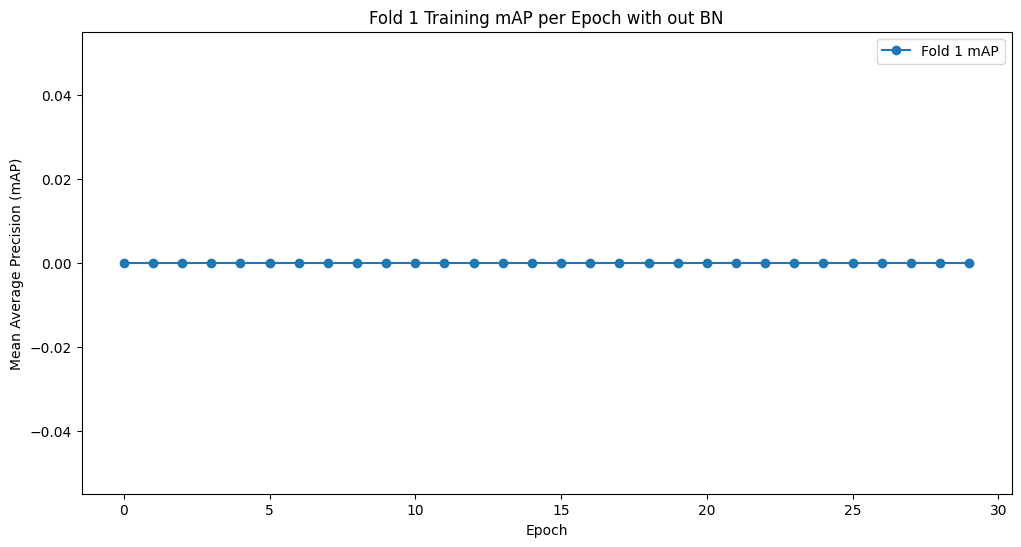

FOLD 1
--------------------------------


100%|██████████| 3/3 [00:01<00:00,  2.00it/s, loss=1.17e+3]

Mean loss was 2075.085408528646


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.64it/s, loss=1.37e+3]

Mean loss was 2009.818359375


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.29e+3]

Mean loss was 1945.0918782552083


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.20it/s, loss=1.26e+3]

Mean loss was 1890.5452067057292


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=815]

Mean loss was 1845.769063313802


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=1.32e+3]

Mean loss was 1782.3644205729167


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=967]

Mean loss was 1707.9212443033855


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=837]

Mean loss was 1604.2909545898438


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.00it/s, loss=854]

Mean loss was 1462.129638671875


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.01it/s, loss=920]

Mean loss was 1282.5509033203125


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=681]

Mean loss was 1092.3480224609375


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=750]

Mean loss was 978.3688761393229


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=660]

Mean loss was 979.2892252604166


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=545]

Mean loss was 890.315185546875


Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=448]

Mean loss was 812.2277119954427


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=550]

Mean loss was 787.9668172200521


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=507]

Mean loss was 760.4522094726562


Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=586]

Mean loss was 722.6736653645834


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=491]

Mean loss was 693.5560506184896


Validation mAP for epoch 18: 0.0006510414532385767


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=280]

Mean loss was 672.1294352213541


Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=537]

Mean loss was 643.7200317382812


Validation mAP for epoch 20: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=324]

Mean loss was 619.4594116210938


Validation mAP for epoch 21: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=443]

Mean loss was 598.0834350585938


Validation mAP for epoch 22: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=444]

Mean loss was 580.4135335286459


Validation mAP for epoch 23: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=359]

Mean loss was 558.7547912597656


Validation mAP for epoch 24: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.12it/s, loss=351]

Mean loss was 541.5454508463541


Validation mAP for epoch 25: 0.02090405859053135


100%|██████████| 3/3 [00:02<00:00,  1.02it/s, loss=277]

Mean loss was 523.6371053059896


Validation mAP for epoch 26: 0.002674906747415662


100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=248]


Mean loss was 506.28603108723956
Validation mAP for epoch 27: 0.005208329763263464


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=296]

Mean loss was 488.6937662760417


Validation mAP for epoch 28: 0.0026041653472930193


100%|██████████| 3/3 [00:02<00:00,  1.02it/s, loss=347]

Mean loss was 471.7962239583333


Validation mAP for epoch 29: 0.0023073467891663313


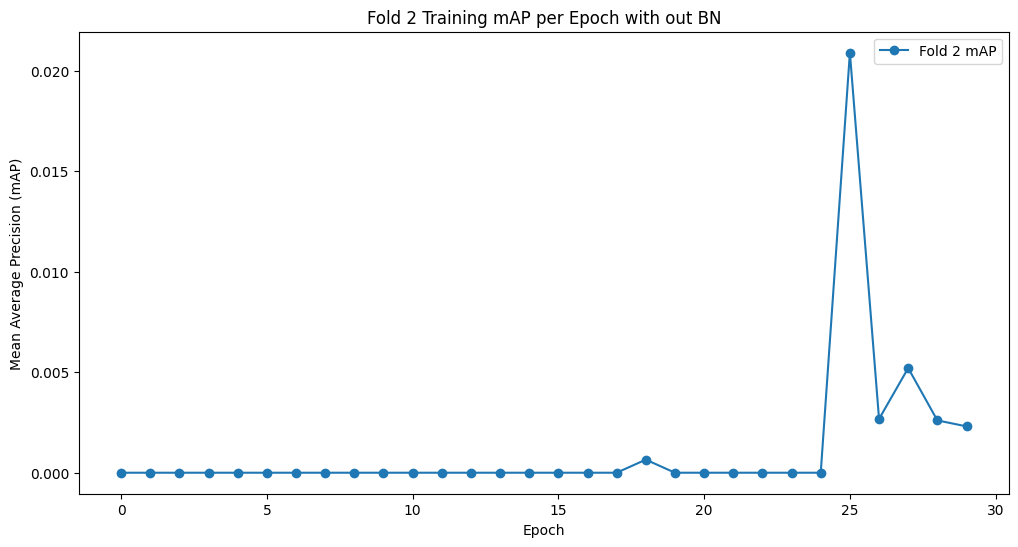

FOLD 2
--------------------------------


100%|██████████| 3/3 [00:01<00:00,  1.98it/s, loss=1.39e+3]

Mean loss was 2176.5609537760415


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=1.49e+3]

Mean loss was 2135.11474609375


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=1.38e+3]

Mean loss was 2078.732869466146


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.67it/s, loss=1.25e+3]

Mean loss was 2036.6074625651042


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.44e+3]

Mean loss was 1984.9020182291667


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=1.06e+3]

Mean loss was 1916.75634765625


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=994]

Mean loss was 1816.4765218098958


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.09e+3]

Mean loss was 1681.5327555338542


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=756]

Mean loss was 1526.68701171875


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.01it/s, loss=834]

Mean loss was 1334.0557861328125


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=587]

Mean loss was 1128.764383951823


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=681]

Mean loss was 1039.6723225911458


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=554]

Mean loss was 1045.652099609375


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=413]

Mean loss was 935.8774719238281


Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=726]

Mean loss was 867.4836222330729


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=546]

Mean loss was 845.3428955078125


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=462]

Mean loss was 808.286142985026


Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=569]

Mean loss was 766.1329549153646


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=662]

Mean loss was 737.9595336914062


Validation mAP for epoch 18: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=423]

Mean loss was 713.5867106119791


Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=454]

Mean loss was 680.658925374349


Validation mAP for epoch 20: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.21s/it, loss=465]

Mean loss was 649.8131103515625


Validation mAP for epoch 21: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.61it/s, loss=478]


Mean loss was 627.5906778971354
Validation mAP for epoch 22: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=409]

Mean loss was 605.4840901692709


Validation mAP for epoch 23: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=469]

Mean loss was 584.0859680175781


Validation mAP for epoch 24: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=479]

Mean loss was 565.3487345377604


Validation mAP for epoch 25: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=437]

Mean loss was 545.5049235026041


Validation mAP for epoch 26: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=247]

Mean loss was 527.1257375081381


Validation mAP for epoch 27: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.01it/s, loss=313]

Mean loss was 510.0390930175781


Validation mAP for epoch 28: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=329]

Mean loss was 493.14696248372394


Validation mAP for epoch 29: 0.0


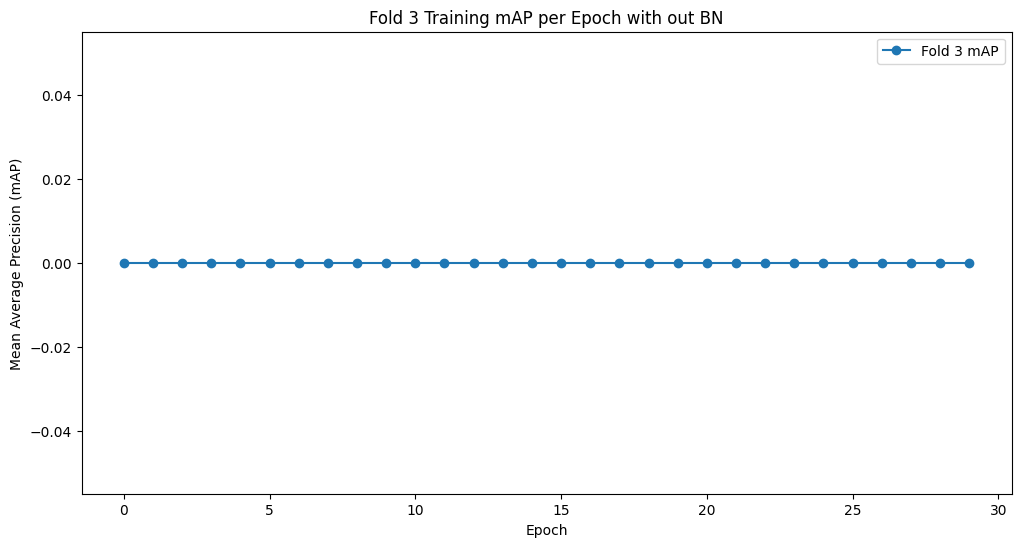

FOLD 3
--------------------------------


100%|██████████| 3/3 [00:03<00:00,  1.00s/it, loss=1.38e+3]

Mean loss was 2085.7562255859375


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.06s/it, loss=1.67e+3]

Mean loss was 2012.0553792317708


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.28e+3]

Mean loss was 1966.4894612630208


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.43e+3]

Mean loss was 1878.5111083984375


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.15e+3]

Mean loss was 1803.552001953125


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.26it/s, loss=946]

Mean loss was 1722.5603434244792


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=1.04e+3]

Mean loss was 1614.2479248046875


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=814]

Mean loss was 1479.303487141927


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=1.01e+3]

Mean loss was 1300.6284586588542


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=619]

Mean loss was 1114.977803548177


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=530]

Mean loss was 959.8023274739584


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.02it/s, loss=715]

Mean loss was 947.3768310546875


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=782]

Mean loss was 876.1824340820312


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=413]

Mean loss was 786.9780069986979


Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.00it/s, loss=590]

Mean loss was 748.0208333333334


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.09s/it, loss=512]

Mean loss was 723.041748046875


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=461]

Mean loss was 686.3679402669271


Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=391]

Mean loss was 652.8909505208334


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=455]

Mean loss was 625.2132466634115


Validation mAP for epoch 18: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=399]

Mean loss was 599.3862915039062


Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.38it/s, loss=306]


Mean loss was 572.4175008138021
Validation mAP for epoch 20: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=356]

Mean loss was 551.9914042154948


Validation mAP for epoch 21: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=377]

Mean loss was 532.4872639973959


Validation mAP for epoch 22: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=365]

Mean loss was 512.160888671875


Validation mAP for epoch 23: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=230]

Mean loss was 495.7030741373698


Validation mAP for epoch 24: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=322]

Mean loss was 480.9690856933594


Validation mAP for epoch 25: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=334]

Mean loss was 466.2410176595052


Validation mAP for epoch 26: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=370]

Mean loss was 451.58730061848956


Validation mAP for epoch 27: 4.629629256669432e-05


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=314]

Mean loss was 438.8313903808594


Validation mAP for epoch 28: 0.00030864187283441424


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=331]

Mean loss was 426.46885172526044


Validation mAP for epoch 29: 4.629629256669432e-05


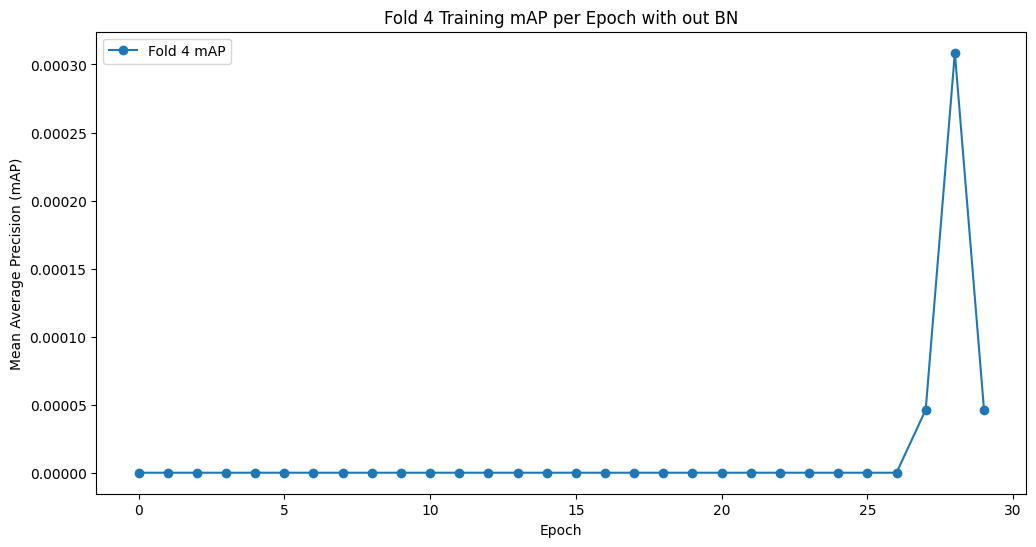

FOLD 4
--------------------------------


100%|██████████| 3/3 [00:02<00:00,  1.12it/s, loss=1.49e+3]

Mean loss was 2297.0819498697915


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.52e+3]

Mean loss was 2249.8511555989585


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.41it/s, loss=1.59e+3]


Mean loss was 2203.4646809895835
Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.43e+3]

Mean loss was 2139.026570638021


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=1.28e+3]

Mean loss was 2069.0305989583335


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.21it/s, loss=1.36e+3]

Mean loss was 1991.8252766927083


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=1.06e+3]

Mean loss was 1902.642822265625


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.00it/s, loss=1.55e+3]

Mean loss was 1765.3944905598958


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.1e+3]

Mean loss was 1594.0484212239583


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.84it/s, loss=812]

Mean loss was 1378.2162475585938


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=626]

Mean loss was 1187.3197835286458


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=669]

Mean loss was 1139.4916178385417


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=1.04e+3]

Mean loss was 1101.4095865885417


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=639]

Mean loss was 991.8863728841146


Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=472]

Mean loss was 944.5141398111979


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=681]

Mean loss was 917.0024820963541


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=516]

Mean loss was 876.687255859375


Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=588]

Mean loss was 826.7483317057291


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=454]

Mean loss was 804.0325419108073


Validation mAP for epoch 18: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=494]

Mean loss was 777.7887776692709


Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=377]

Mean loss was 740.1197509765625


Validation mAP for epoch 20: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=625]

Mean loss was 713.0197143554688


Validation mAP for epoch 21: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=433]

Mean loss was 693.6814880371094


Validation mAP for epoch 22: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=392]

Mean loss was 665.1807352701823


Validation mAP for epoch 23: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=396]

Mean loss was 641.1816202799479


Validation mAP for epoch 24: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=430]

Mean loss was 618.6749776204427


Validation mAP for epoch 25: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=362]

Mean loss was 597.5490112304688


Validation mAP for epoch 26: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.55it/s, loss=335]


Mean loss was 577.4837544759115
Validation mAP for epoch 27: 0.0005494504002854228


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=314]

Mean loss was 557.9478556315104


Validation mAP for epoch 28: 0.00039682528586126864


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=278]

Mean loss was 539.7896931966146


Validation mAP for epoch 29: 0.00039682528586126864


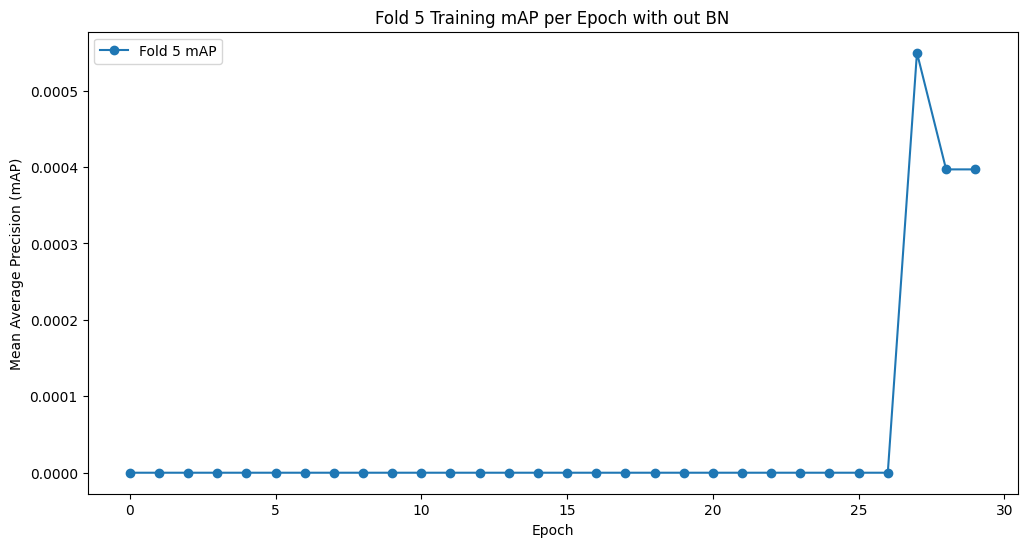

Average Validation mAP across all folds: 0.0005500936735188588


In [61]:
train_dataset = VOCDataset(
    "100examples.csv",
    transform=transform,
    img_dir=IMG_DIR,
    label_dir=LABEL_DIR,
)

test_dataset = VOCDataset(
    "test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
)


k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=seed)
fold_results = []

# Collect the fold performance for plotting
fold_performance_history = []

for fold, (train_ids, valid_ids) in enumerate(kf.split(np.arange(len(train_dataset)))):
    print(f'FOLD {fold}')
    print('--------------------------------')

    fold_epoch_mAPs = []  # Store mAP for each epoch within this fold

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    valid_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    # Initialize the model and optimizer for this fold
    model = Yolov1_WO_BN(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    loss_fn = YoloLoss().to(DEVICE)

    # Run the training loop for the defined number of epochs
    for epoch in range(EPOCHS):

        # Train for one epoch
        train_fn(train_loader, model, optimizer, loss_fn)

        # Evaluate after the epoch
        valid_mAPs = []
        model.eval()
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(valid_loader):
                x, y = x.to(DEVICE), y.to(DEVICE)
                predictions = model(x)
                # Calculate mAP
                pred_boxes, target_boxes = get_bboxes(valid_loader, model, iou_threshold=0.5, threshold=0.4)
                valid_mAP = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
                valid_mAPs.append(valid_mAP.item())

        # Calculate average mAP for the validation set
        avg_valid_mAP = sum(valid_mAPs) / len(valid_mAPs)
        print(f"Validation mAP for epoch {epoch}: {avg_valid_mAP}")

        fold_epoch_mAPs.append(avg_valid_mAP)  # Append the average mAP for the current epoch

        # Save the model's state if this is the best performing fold
        # if avg_valid_mAP > best_valid_mAP_so_far (you'll need to define this variable outside the loop)
        #     best_valid_mAP_so_far = avg_valid_mAP
        #     save_checkpoint(...)  # Save your model using the function you've defined

        model.train()

    fold_results.append(avg_valid_mAP)
    # After finishing all epochs for the fold, add the fold performance to the fold performance history
   # fold_performance_history.append(fold_epoch_mAPs)
    # Calculate and print the average performance over all folds

    # Plot the training mAP for each epoch of the current fold
    plt.figure(figsize=(12, 6))
    plt.plot(range(EPOCHS), fold_epoch_mAPs, marker='o', label=f'Fold {fold+1} mAP')
    plt.title(f'Fold {fold+1} Training mAP per Epoch with out BN')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Average Precision (mAP)')
    plt.legend()
    plt.show()

    fold_results.append(fold_epoch_mAPs[-1])  # Append the last mAP of the fold


average_performance = sum(fold_results) / len(fold_results)
print(f'Average Validation mAP across all folds: {average_performance}')


Yolov1 using RSMProp Optimizer

FOLD 0
--------------------------------


100%|██████████| 3/3 [00:02<00:00,  1.01it/s, loss=1.37e+3]

Mean loss was 2039.638671875


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.67it/s, loss=744]

Mean loss was 1286.3458455403645


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.13it/s, loss=548]

Mean loss was 1019.0381673177084


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=356]

Mean loss was 779.2151692708334


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=572]

Mean loss was 704.8881429036459


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=390]

Mean loss was 655.2571309407552


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.28it/s, loss=455]

Mean loss was 599.3846842447916


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=437]

Mean loss was 533.6907348632812


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=415]

Mean loss was 530.6889851888021


Validation mAP for epoch 8: 0.00019723862351384014


100%|██████████| 3/3 [00:01<00:00,  1.88it/s, loss=409]

Mean loss was 508.8257141113281


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.00s/it, loss=272]

Mean loss was 446.85988362630206


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=333]

Mean loss was 427.946533203125


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.67it/s, loss=336]

Mean loss was 434.3851318359375


Validation mAP for epoch 12: 0.00021367518638726324


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=270]

Mean loss was 413.0648498535156


Validation mAP for epoch 13: 0.0006450656219385564


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=274]

Mean loss was 382.0338846842448


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=213]

Mean loss was 385.8284505208333


Validation mAP for epoch 15: 0.00012210010027047247


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=203]

Mean loss was 362.69664510091144


Validation mAP for epoch 16: 0.001921576913446188


100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=242]

Mean loss was 355.68613688151044


Validation mAP for epoch 17: 0.0007387055666185915


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=246]

Mean loss was 367.0126444498698


Validation mAP for epoch 18: 0.0056196553632617


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=215]

Mean loss was 346.59999084472656


Validation mAP for epoch 19: 0.005691741593182087


100%|██████████| 3/3 [00:01<00:00,  2.64it/s, loss=293]

Mean loss was 354.0107421875


Validation mAP for epoch 20: 0.00844932533800602


100%|██████████| 3/3 [00:01<00:00,  2.63it/s, loss=279]

Mean loss was 352.18166097005206


Validation mAP for epoch 21: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=230]

Mean loss was 329.7417399088542


Validation mAP for epoch 22: 0.0006929180817678571


100%|██████████| 3/3 [00:01<00:00,  2.59it/s, loss=191]

Mean loss was 343.2315216064453


Validation mAP for epoch 23: 0.0013166158460080624


100%|██████████| 3/3 [00:02<00:00,  1.23it/s, loss=208]

Mean loss was 326.80495198567706


Validation mAP for epoch 24: 0.003418802050873637


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=197]

Mean loss was 314.7218424479167


Validation mAP for epoch 25: 0.0026495717465877533


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=182]

Mean loss was 314.6418863932292


Validation mAP for epoch 26: 0.0056196553632617


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=193]

Mean loss was 308.08986409505206


Validation mAP for epoch 27: 0.005500607658177614


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=137]

Mean loss was 303.9611002604167


Validation mAP for epoch 28: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=204]

Mean loss was 323.55926513671875


Validation mAP for epoch 29: 0.0


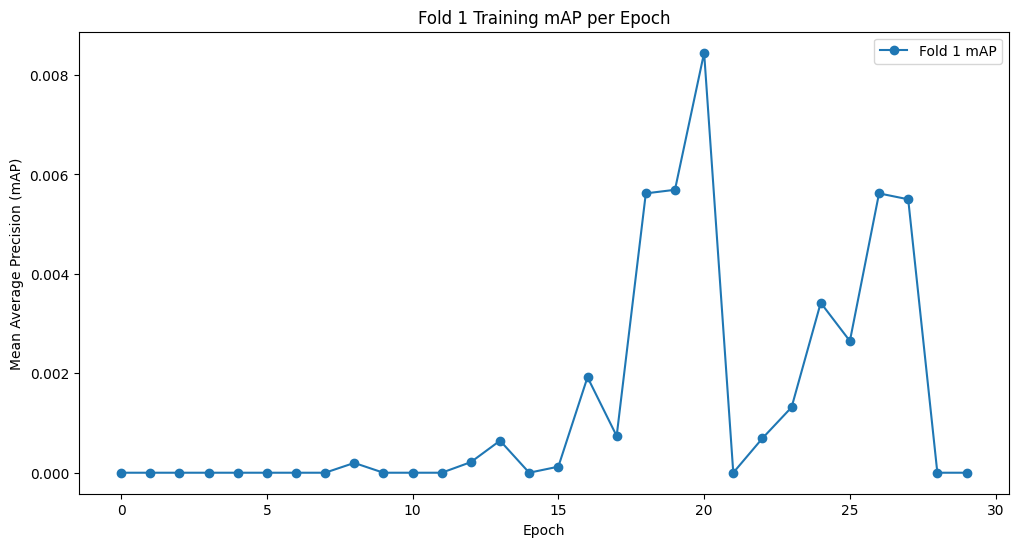

FOLD 1
--------------------------------


100%|██████████| 3/3 [00:02<00:00,  1.06it/s, loss=1.18e+3]

Mean loss was 1938.2255859375


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.08it/s, loss=579]

Mean loss was 1207.8932088216145


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=847]

Mean loss was 938.0866495768229


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=551]

Mean loss was 801.5123901367188


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=440]

Mean loss was 636.3310139973959


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=370]

Mean loss was 582.2569681803385


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=428]

Mean loss was 543.3728942871094


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.98it/s, loss=342]

Mean loss was 503.9400126139323


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=230]

Mean loss was 475.3344472249349


Validation mAP for epoch 8: 8.400536171393469e-05


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=317]

Mean loss was 446.71746826171875


Validation mAP for epoch 9: 0.0002688171516638249


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=321]

Mean loss was 424.69549560546875


Validation mAP for epoch 10: 8.400536171393469e-05


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=266]

Mean loss was 414.39747111002606


Validation mAP for epoch 11: 0.00013440859038382769


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=276]

Mean loss was 400.49786376953125


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.62it/s, loss=180]

Mean loss was 375.4529520670573


Validation mAP for epoch 13: 9.600613702787086e-05


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=255]

Mean loss was 362.28379313151044


Validation mAP for epoch 14: 0.0026881706435233355


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=203]

Mean loss was 358.1056620279948


Validation mAP for epoch 15: 0.0002688171516638249


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=155]

Mean loss was 330.9394175211589


Validation mAP for epoch 16: 0.0017921141115948558


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=180]

Mean loss was 330.74639892578125


Validation mAP for epoch 17: 0.001052867155522108


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=245]

Mean loss was 317.1244201660156


Validation mAP for epoch 18: 0.004096014425158501


100%|██████████| 3/3 [00:02<00:00,  1.03it/s, loss=209]

Mean loss was 305.9629414876302


Validation mAP for epoch 19: 0.0006101723411120474


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=275]

Mean loss was 313.957763671875


Validation mAP for epoch 20: 0.0013726484030485153


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=272]

Mean loss was 292.5427551269531


Validation mAP for epoch 21: 0.0007200459367595613


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=185]

Mean loss was 292.1423085530599


Validation mAP for epoch 22: 0.00011200716107850894


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=180]

Mean loss was 301.165283203125


Validation mAP for epoch 23: 0.0006720426608808339


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=213]

Mean loss was 280.4078318277995


Validation mAP for epoch 24: 0.0011208500945940614


100%|██████████| 3/3 [00:01<00:00,  2.57it/s, loss=139]

Mean loss was 283.40273030598956


Validation mAP for epoch 25: 0.0015264410758391023


100%|██████████| 3/3 [00:02<00:00,  1.01it/s, loss=190]

Mean loss was 281.48072306315106


Validation mAP for epoch 26: 0.0006720426608808339


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=198]

Mean loss was 273.56858317057294


Validation mAP for epoch 27: 0.0026881706435233355


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=134]

Mean loss was 266.40684000651044


Validation mAP for epoch 28: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=166]

Mean loss was 268.97833251953125


Validation mAP for epoch 29: 0.0007927243132144213


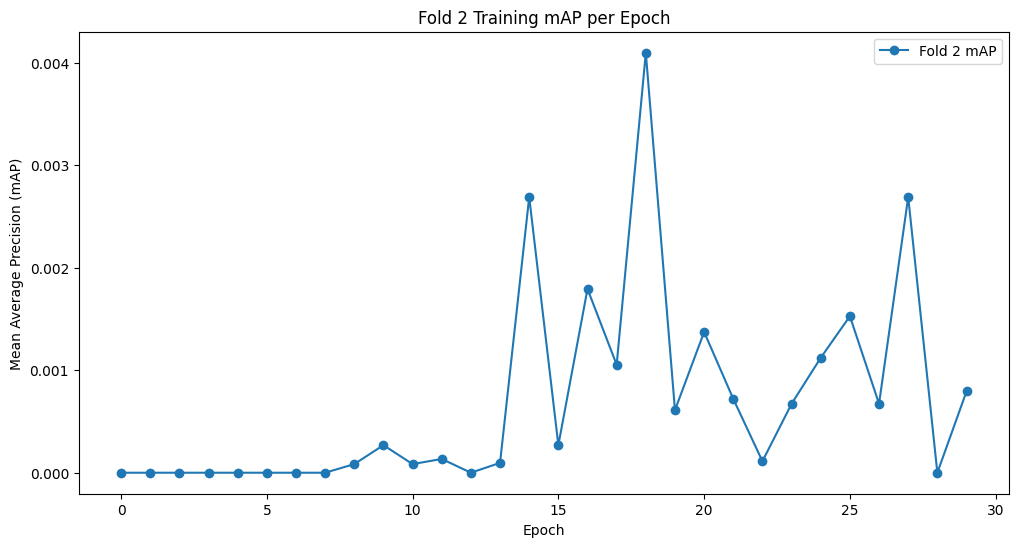

FOLD 2
--------------------------------


100%|██████████| 3/3 [00:01<00:00,  1.96it/s, loss=1.79e+3]

Mean loss was 2079.5997314453125


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=869]

Mean loss was 1467.2850138346355


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.64it/s, loss=774]

Mean loss was 1080.1746826171875


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=576]

Mean loss was 821.3469034830729


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=439]

Mean loss was 726.6825968424479


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=340]

Mean loss was 651.7977701822916


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=497]

Mean loss was 617.357666015625


Validation mAP for epoch 6: 0.0010683754226192832


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=373]

Mean loss was 563.7870279947916


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=339]

Mean loss was 525.4223327636719


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=328]

Mean loss was 519.5868530273438


Validation mAP for epoch 9: 0.0010683754226192832


100%|██████████| 3/3 [00:01<00:00,  2.03it/s, loss=360]

Mean loss was 475.11370849609375


Validation mAP for epoch 10: 0.0005341878277249634


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=209]

Mean loss was 443.5968068440755


Validation mAP for epoch 11: 0.00029585795709863305


100%|██████████| 3/3 [00:01<00:00,  2.64it/s, loss=356]

Mean loss was 497.01206461588544


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.63it/s, loss=399]

Mean loss was 435.8878682454427


Validation mAP for epoch 13: 0.0004930965369567275


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=306]

Mean loss was 420.58062744140625


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=451]

Mean loss was 415.1226094563802


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.27it/s, loss=277]

Mean loss was 379.8698221842448


Validation mAP for epoch 16: 0.00018491121591068804


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=241]

Mean loss was 403.4299825032552


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=180]

Mean loss was 372.5352071126302


Validation mAP for epoch 18: 0.0014792891452088952


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=174]

Mean loss was 354.51930236816406


Validation mAP for epoch 19: 0.0007396448054350913


100%|██████████| 3/3 [00:03<00:00,  1.05s/it, loss=295]

Mean loss was 341.77662150065106


Validation mAP for epoch 20: 0.0014792891452088952


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=207]

Mean loss was 337.64702860514325


Validation mAP for epoch 21: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=199]

Mean loss was 335.1438293457031


Validation mAP for epoch 22: 0.0003287310537416488


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=175]

Mean loss was 331.46046956380206


Validation mAP for epoch 23: 0.0005917158559896052


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=234]

Mean loss was 334.93549092610675


Validation mAP for epoch 24: 0.0002689617685973644


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=184]

Mean loss was 323.6775410970052


Validation mAP for epoch 25: 0.0004930965369567275


100%|██████████| 3/3 [00:01<00:00,  2.58it/s, loss=223]

Mean loss was 319.0152587890625


Validation mAP for epoch 26: 0.0007396448054350913


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=234]

Mean loss was 314.04920450846356


Validation mAP for epoch 27: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=239]

Mean loss was 329.1395212809245


Validation mAP for epoch 28: 0.00018491121591068804


100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=152]

Mean loss was 312.08819580078125


Validation mAP for epoch 29: 0.00029585795709863305


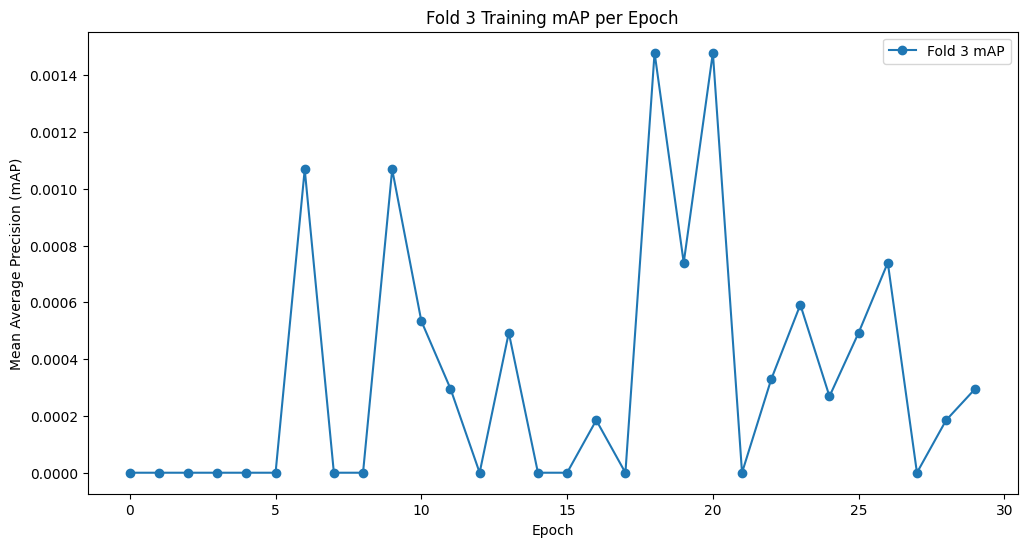

FOLD 3
--------------------------------


100%|██████████| 3/3 [00:03<00:00,  1.00s/it, loss=1.42e+3]

Mean loss was 1889.1868896484375


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=1.18e+3]

Mean loss was 1313.1761474609375


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=645]

Mean loss was 967.1675008138021


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=486]

Mean loss was 758.944580078125


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.55it/s, loss=511]

Mean loss was 688.4107666015625


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=454]

Mean loss was 619.4478047688802


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=367]

Mean loss was 601.5225118001302


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=312]

Mean loss was 565.3466491699219


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.00it/s, loss=344]

Mean loss was 505.53564453125


Validation mAP for epoch 8: 0.00018518515571486205


100%|██████████| 3/3 [00:03<00:00,  1.21s/it, loss=369]

Mean loss was 475.06870524088544


Validation mAP for epoch 9: 0.08333321660757065


100%|██████████| 3/3 [00:01<00:00,  2.09it/s, loss=355]


Mean loss was 452.24219767252606
Validation mAP for epoch 10: 0.013888870365917683


100%|██████████| 3/3 [00:03<00:00,  1.00s/it, loss=383]

Mean loss was 426.1056213378906


Validation mAP for epoch 11: 4.629629256669432e-05


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=296]

Mean loss was 414.5448506673177


Validation mAP for epoch 12: 0.0006042882450856268


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=282]

Mean loss was 412.59023030598956


Validation mAP for epoch 13: 4.629629256669432e-05


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=299]

Mean loss was 387.16656494140625


Validation mAP for epoch 14: 4.629629256669432e-05


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=333]

Mean loss was 366.653076171875


Validation mAP for epoch 15: 4.629629256669432e-05


100%|██████████| 3/3 [00:03<00:00,  1.00s/it, loss=328]

Mean loss was 395.3724670410156


Validation mAP for epoch 16: 4.629629256669432e-05


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=229]

Mean loss was 351.43242899576825


Validation mAP for epoch 17: 0.00013995316112414002


100%|██████████| 3/3 [00:01<00:00,  1.83it/s, loss=331]

Mean loss was 333.39757283528644


Validation mAP for epoch 18: 4.629629256669432e-05


100%|██████████| 3/3 [00:02<00:00,  1.00it/s, loss=196]

Mean loss was 328.0221862792969


Validation mAP for epoch 19: 4.629629256669432e-05


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=184]

Mean loss was 328.5993245442708


Validation mAP for epoch 20: 4.629629256669432e-05


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=180]

Mean loss was 318.8533681233724


Validation mAP for epoch 21: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.28it/s, loss=256]

Mean loss was 319.3385314941406


Validation mAP for epoch 22: 0.0001569950400153175


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=142]

Mean loss was 302.0633138020833


Validation mAP for epoch 23: 4.629629256669432e-05


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=170]

Mean loss was 295.9144236246745


Validation mAP for epoch 24: 4.629629256669432e-05


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=289]

Mean loss was 300.22938028971356


Validation mAP for epoch 25: 0.0006042882450856268


100%|██████████| 3/3 [00:02<00:00,  1.41it/s, loss=151]

Mean loss was 307.1564432779948


Validation mAP for epoch 26: 4.629629256669432e-05


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=202]

Mean loss was 288.98829650878906


Validation mAP for epoch 27: 4.629629256669432e-05


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=182]

Mean loss was 297.5610605875651


Validation mAP for epoch 28: 0.0006944442284293473


100%|██████████| 3/3 [00:02<00:00,  1.21it/s, loss=288]

Mean loss was 322.09405517578125


Validation mAP for epoch 29: 0.0006042882450856268


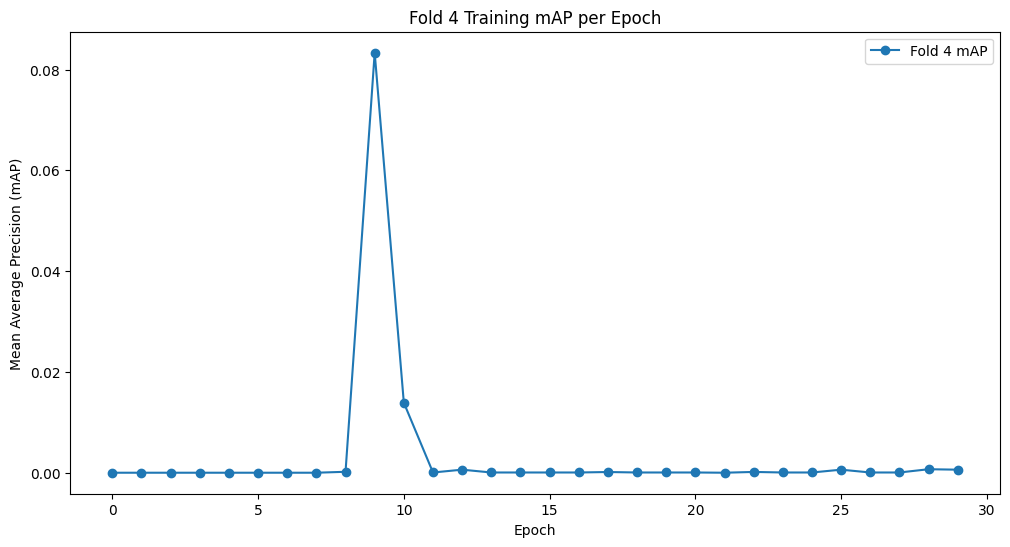

FOLD 4
--------------------------------


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=1.25e+3]

Mean loss was 2065.122029622396


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=613]

Mean loss was 1484.2982177734375


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=590]

Mean loss was 1069.5467529296875


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=561]

Mean loss was 826.6495768229166


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=471]

Mean loss was 743.4445597330729


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=497]

Mean loss was 708.0602722167969


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.84it/s, loss=489]


Mean loss was 623.0428670247396
Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=395]

Mean loss was 581.4471028645834


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=560]

Mean loss was 565.5914103190104


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=389]

Mean loss was 555.0175374348959


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.89it/s, loss=443]

Mean loss was 530.1400756835938


Validation mAP for epoch 10: 0.00044642845750786364


100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=308]


Mean loss was 477.60044352213544
Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=252]

Mean loss was 487.6752522786458


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=300]

Mean loss was 474.0311686197917


Validation mAP for epoch 13: 0.00044642845750786364


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=233]

Mean loss was 440.66270446777344


Validation mAP for epoch 14: 0.0006493505206890404


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=397]

Mean loss was 451.3811340332031


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=333]

Mean loss was 417.55316162109375


Validation mAP for epoch 16: 0.0003571427660062909


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=339]

Mean loss was 417.6158955891927


Validation mAP for epoch 17: 0.0005102040013298392


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=289]

Mean loss was 413.0140787760417


Validation mAP for epoch 18: 0.0011904758866876364


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=300]

Mean loss was 397.537109375


Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=253]

Mean loss was 392.33465576171875


Validation mAP for epoch 20: 0.00044642845750786364


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=307]

Mean loss was 372.53676350911456


Validation mAP for epoch 21: 0.0005102040013298392


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=192]

Mean loss was 380.23316446940106


Validation mAP for epoch 22: 0.00044642845750786364


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=239]

Mean loss was 368.76548258463544


Validation mAP for epoch 23: 0.0005494504002854228


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=378]

Mean loss was 364.15264892578125


Validation mAP for epoch 24: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=282]

Mean loss was 386.9955749511719


Validation mAP for epoch 25: 0.0010204078862443566


100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=220]

Mean loss was 352.21189371744794


Validation mAP for epoch 26: 0.0003571427660062909


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=264]

Mean loss was 351.77056884765625


Validation mAP for epoch 27: 0.0035714260302484035


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=232]

Mean loss was 356.4690806070964


Validation mAP for epoch 28: 0.0005952379433438182


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=254]

Mean loss was 355.11681111653644


Validation mAP for epoch 29: 0.0005102040013298392


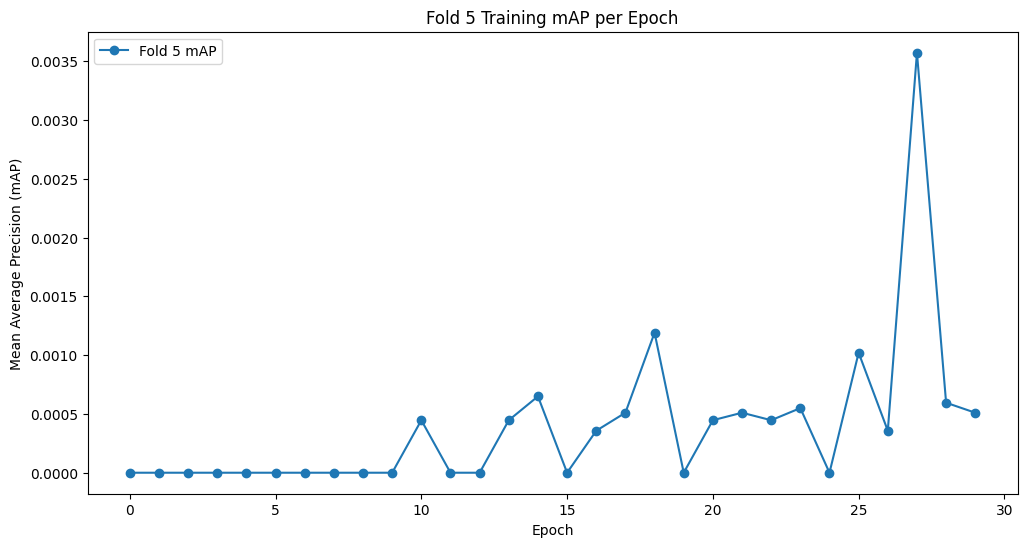

Average Validation mAP across all folds: 0.0004406149033457041


In [62]:
train_dataset = VOCDataset(
    "100examples.csv",
    transform=transform,
    img_dir=IMG_DIR,
    label_dir=LABEL_DIR,
)

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=seed)
fold_results = []

# Collect the fold performance for plotting
fold_performance_history = []

for fold, (train_ids, valid_ids) in enumerate(kf.split(np.arange(len(train_dataset)))):
    print(f'FOLD {fold}')
    print('--------------------------------')

    fold_epoch_mAPs = []  # Store mAP for each epoch within this fold

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = SubsetRandomSampler(train_ids)
    valid_subsampler = SubsetRandomSampler(valid_ids)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    valid_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    # Initialize the model and optimizer for this fold
    model_RMSP = Yolov1_WO_BN(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.RMSprop(model_RMSP.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)  # Updated to RMSprop
    loss_fn = YoloLoss().to(DEVICE)

    # Run the training loop for the defined number of epochs
    # Run the training loop for the defined number of epochs
    for epoch in range(EPOCHS):

        # Train for one epoch
        train_fn(train_loader, model_RMSP, optimizer, loss_fn)

        # Evaluate after the epoch
        valid_mAPs = []
        model_RMSP.eval()
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(valid_loader):
                x, y = x.to(DEVICE), y.to(DEVICE)
                predictions = model_RMSP(x)
                # Calculate mAP
                pred_boxes, target_boxes = get_bboxes(valid_loader, model_RMSP, iou_threshold=0.5, threshold=0.4)
                valid_mAP = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
                valid_mAPs.append(valid_mAP.item())

        # Calculate average mAP for the validation set
        avg_valid_mAP = sum(valid_mAPs) / len(valid_mAPs)
        print(f"Validation mAP for epoch {epoch}: {avg_valid_mAP}")

        fold_epoch_mAPs.append(avg_valid_mAP)  # Append the average mAP for the current epoch

        # Save the model's state if this is the best performing fold
        # if avg_valid_mAP > best_valid_mAP_so_far (you'll need to define this variable outside the loop)
        #     best_valid_mAP_so_far = avg_valid_mAP
        #     save_checkpoint(...)  # Save your model using the function you've defined

        model.train()

    fold_results.append(avg_valid_mAP)
    # After finishing all epochs for the fold, add the fold performance to the fold performance history
   # fold_performance_history.append(fold_epoch_mAPs)
    # Calculate and print the average performance over all folds

    # Plot the training mAP for each epoch of the current fold
    plt.figure(figsize=(12, 6))
    plt.plot(range(EPOCHS), fold_epoch_mAPs, marker='o', label=f'Fold {fold+1} mAP')
    plt.title(f'Fold {fold+1} Training mAP per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Average Precision (mAP)')
    plt.legend()
    plt.show()

    fold_results.append(fold_epoch_mAPs[-1])  # Append the last mAP of the fold


average_performance = sum(fold_results) / len(fold_results)
print(f'Average Validation mAP across all folds: {average_performance}')


##Yolov1 with AdamOptimizer - Without BatchNormalization

FOLD 0
--------------------------------


100%|██████████| 3/3 [00:01<00:00,  1.98it/s, loss=1.01e+3]

Mean loss was 2124.825398763021


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.00it/s, loss=975]

Mean loss was 2091.2630208333335


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=915]

Mean loss was 2060.773396809896


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=1.69e+3]

Mean loss was 2030.1658528645833


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.58it/s, loss=1.61e+3]


Mean loss was 1994.381103515625
Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=985]

Mean loss was 1935.2139078776042


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=1.24e+3]

Mean loss was 1842.5462239583333


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=888]

Mean loss was 1728.87841796875


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=963]

Mean loss was 1579.6861165364583


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=692]

Mean loss was 1392.6454671223958


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=904]

Mean loss was 1177.3805745442708


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=816]

Mean loss was 1028.8382364908855


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=900]

Mean loss was 1030.5460205078125


Validation mAP for epoch 12: 0.001923074945807457


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=704]

Mean loss was 942.8981323242188


Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=491]

Mean loss was 842.6397094726562


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.58it/s, loss=586]

Mean loss was 806.5115356445312


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.00it/s, loss=503]

Mean loss was 779.3796183268229


Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=643]

Mean loss was 735.3398030598959


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=594]


Mean loss was 700.822509765625
Validation mAP for epoch 18: 0.001923074945807457


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=538]

Mean loss was 677.4806315104166


Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=407]

Mean loss was 651.2466634114584


Validation mAP for epoch 20: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=280]

Mean loss was 624.0598653157552


Validation mAP for epoch 21: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.02it/s, loss=459]

Mean loss was 601.74072265625


Validation mAP for epoch 22: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=333]

Mean loss was 581.3310343424479


Validation mAP for epoch 23: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=350]

Mean loss was 560.8334350585938


Validation mAP for epoch 24: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=392]

Mean loss was 544.2133992513021


Validation mAP for epoch 25: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=311]

Mean loss was 525.878163655599


Validation mAP for epoch 26: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=259]

Mean loss was 510.2102355957031


Validation mAP for epoch 27: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=254]

Mean loss was 494.65894571940106


Validation mAP for epoch 28: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.63it/s, loss=468]

Mean loss was 479.10711669921875


Validation mAP for epoch 29: 0.0001282051089219749


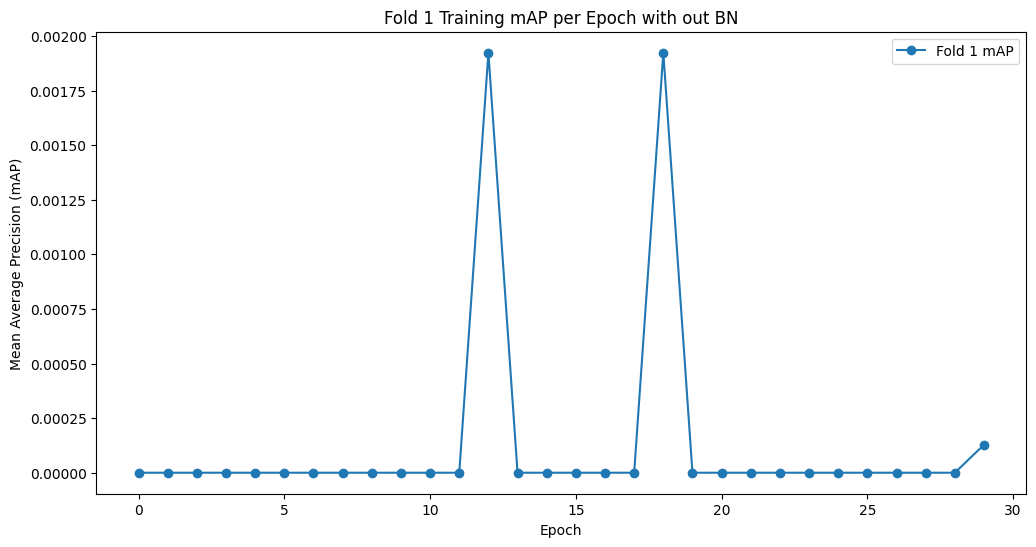

FOLD 1
--------------------------------


100%|██████████| 3/3 [00:03<00:00,  1.00s/it, loss=1.66e+3]

Mean loss was 2114.1341552734375


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.52it/s, loss=1.38e+3]


Mean loss was 2061.503173828125
Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.00s/it, loss=1.43e+3]

Mean loss was 2026.4532470703125


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=1.41e+3]

Mean loss was 1981.6549479166667


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.88it/s, loss=1.17e+3]

Mean loss was 1900.3579508463542


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.32e+3]

Mean loss was 1818.8963216145833


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=1.02e+3]


Mean loss was 1714.1024169921875
Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.27it/s, loss=991]

Mean loss was 1583.8532104492188


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=911]

Mean loss was 1421.4400838216145


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=642]

Mean loss was 1238.6319173177083


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=550]

Mean loss was 1069.1520385742188


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=570]

Mean loss was 1011.4588216145834


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=603]

Mean loss was 999.5923055013021


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=645]

Mean loss was 894.14892578125


Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=671]

Mean loss was 831.7432657877604


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=593]

Mean loss was 803.6238606770834


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=578]

Mean loss was 767.9138793945312


Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=340]

Mean loss was 734.2245279947916


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=454]

Mean loss was 706.9510396321615


Validation mAP for epoch 18: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=622]

Mean loss was 682.9395548502604


Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.01it/s, loss=432]

Mean loss was 653.7147216796875


Validation mAP for epoch 20: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=295]

Mean loss was 628.2872009277344


Validation mAP for epoch 21: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=466]

Mean loss was 607.2211100260416


Validation mAP for epoch 22: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=389]

Mean loss was 586.2633972167969


Validation mAP for epoch 23: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=402]

Mean loss was 564.44482421875


Validation mAP for epoch 24: 6.40040889265947e-05


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=316]

Mean loss was 545.1862182617188


Validation mAP for epoch 25: 7.906387327238917e-05


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=424]

Mean loss was 524.8324279785156


Validation mAP for epoch 26: 7.906387327238917e-05


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=321]

Mean loss was 506.10243733723956


Validation mAP for epoch 27: 0.0003360214177519083


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=301]

Mean loss was 487.2147725423177


Validation mAP for epoch 28: 7.906387327238917e-05


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=285]

Mean loss was 470.61301676432294


Validation mAP for epoch 29: 8.960572449723259e-05


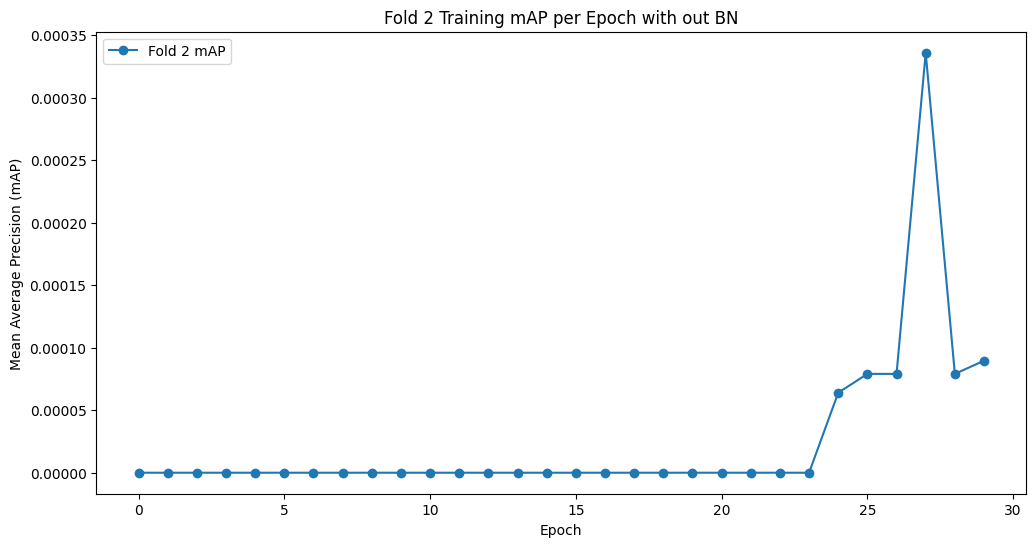

FOLD 2
--------------------------------


100%|██████████| 3/3 [00:01<00:00,  1.98it/s, loss=1.64e+3]


Mean loss was 2159.820271809896
Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.43e+3]

Mean loss was 2119.1944986979165


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.54it/s, loss=1.76e+3]

Mean loss was 2065.742472330729


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=1.52e+3]


Mean loss was 2019.8583984375
Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.28it/s, loss=1.46e+3]

Mean loss was 1965.1512451171875


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=1.07e+3]

Mean loss was 1893.7551676432292


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.44e+3]

Mean loss was 1810.108642578125


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.21s/it, loss=717]

Mean loss was 1699.5887247721355


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=919]

Mean loss was 1540.8292846679688


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=709]

Mean loss was 1342.0510660807292


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.55it/s, loss=800]

Mean loss was 1140.604248046875


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=641]

Mean loss was 1063.4820149739583


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.58it/s, loss=808]

Mean loss was 1061.866231282552


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.01it/s, loss=658]

Mean loss was 956.3226928710938


Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=486]

Mean loss was 902.066162109375


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=685]

Mean loss was 874.9353637695312


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=599]


Mean loss was 839.3721313476562
Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=386]

Mean loss was 794.5255737304688


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=342]

Mean loss was 761.7988789876302


Validation mAP for epoch 18: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.14s/it, loss=597]

Mean loss was 734.2972412109375


Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=556]

Mean loss was 695.2770182291666


Validation mAP for epoch 20: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.48it/s, loss=358]


Mean loss was 672.2977600097656
Validation mAP for epoch 21: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=485]

Mean loss was 648.5607706705729


Validation mAP for epoch 22: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=461]

Mean loss was 625.6180419921875


Validation mAP for epoch 23: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=268]

Mean loss was 603.1442667643229


Validation mAP for epoch 24: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=398]

Mean loss was 583.4274495442709


Validation mAP for epoch 25: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=507]

Mean loss was 563.7208658854166


Validation mAP for epoch 26: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=364]

Mean loss was 545.3378499348959


Validation mAP for epoch 27: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=467]

Mean loss was 529.2548217773438


Validation mAP for epoch 28: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=301]

Mean loss was 511.68613688151044


Validation mAP for epoch 29: 0.0


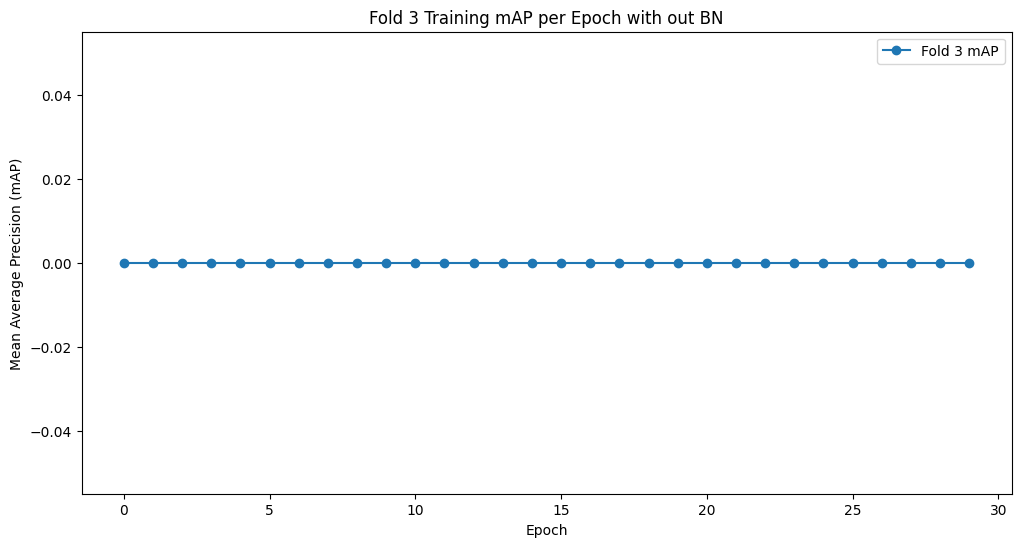

FOLD 3
--------------------------------


100%|██████████| 3/3 [00:01<00:00,  2.09it/s, loss=1.49e+3]

Mean loss was 2106.01123046875


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.34e+3]

Mean loss was 2037.5546061197917


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.37e+3]

Mean loss was 1969.2571614583333


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.33e+3]

Mean loss was 1918.8417561848958


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=1.22e+3]

Mean loss was 1847.0308837890625


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=1.44e+3]

Mean loss was 1775.6145426432292


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.27e+3]

Mean loss was 1683.2771809895833


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=926]

Mean loss was 1569.3416341145833


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=938]

Mean loss was 1420.4462076822917


Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=714]

Mean loss was 1244.8595377604167


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.04it/s, loss=712]

Mean loss was 1086.00244140625


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=665]

Mean loss was 1051.2958577473958


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=877]

Mean loss was 1006.5815022786459


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.01it/s, loss=568]

Mean loss was 907.7189127604166


Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=461]

Mean loss was 861.42236328125


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=540]

Mean loss was 836.9712320963541


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.16s/it, loss=487]

Mean loss was 797.4306437174479


Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.56it/s, loss=319]


Mean loss was 755.9852294921875
Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.00s/it, loss=401]

Mean loss was 723.0038452148438


Validation mAP for epoch 18: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=517]

Mean loss was 695.611328125


Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=361]

Mean loss was 663.1614176432291


Validation mAP for epoch 20: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=421]

Mean loss was 636.8686930338541


Validation mAP for epoch 21: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=463]

Mean loss was 615.2439270019531


Validation mAP for epoch 22: 0.0001157407314167358


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=381]

Mean loss was 591.1472473144531


Validation mAP for epoch 23: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=455]

Mean loss was 572.0805969238281


Validation mAP for epoch 24: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=384]

Mean loss was 550.3451538085938


Validation mAP for epoch 25: 0.0


100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=328]


Mean loss was 529.2824096679688
Validation mAP for epoch 26: 0.0018518510041758418


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=319]

Mean loss was 510.86163330078125


Validation mAP for epoch 27: 0.0003888283099513501


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=235]

Mean loss was 489.58497111002606


Validation mAP for epoch 28: 0.0020186537876725197


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=308]

Mean loss was 470.49668375651044


Validation mAP for epoch 29: 4.873293801210821e-05


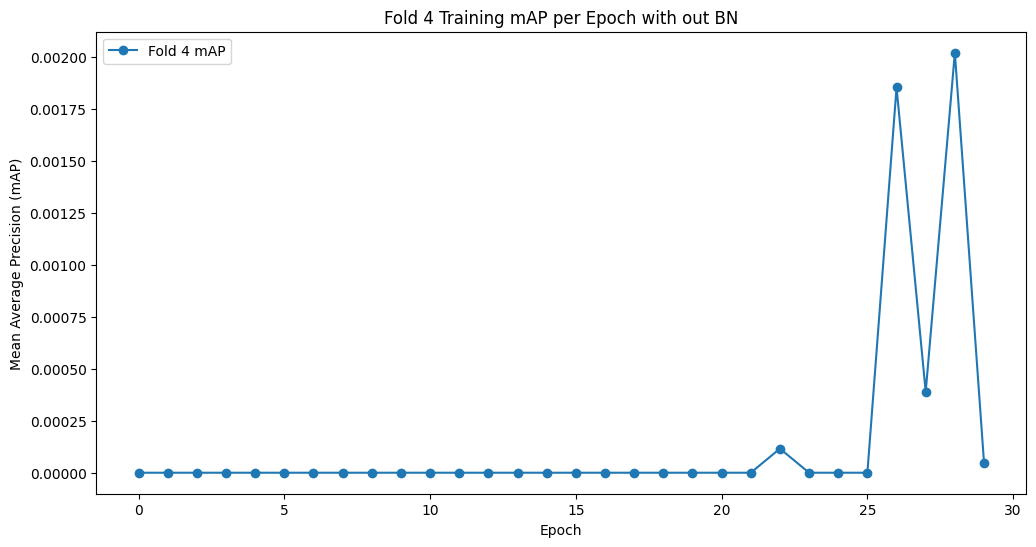

FOLD 4
--------------------------------


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=1.8e+3]

Mean loss was 2339.7921549479165


Validation mAP for epoch 0: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=1.52e+3]

Mean loss was 2290.817911783854


Validation mAP for epoch 1: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=1.6e+3]

Mean loss was 2249.3382161458335


Validation mAP for epoch 2: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=1.1e+3]

Mean loss was 2203.6773681640625


Validation mAP for epoch 3: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.2e+3]

Mean loss was 2141.0870768229165


Validation mAP for epoch 4: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.47e+3]

Mean loss was 2088.159912109375


Validation mAP for epoch 5: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.01it/s, loss=1.36e+3]

Mean loss was 2002.8607177734375


Validation mAP for epoch 6: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=1.24e+3]

Mean loss was 1904.5294189453125


Validation mAP for epoch 7: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.46it/s, loss=1.2e+3]


Mean loss was 1772.3373616536458
Validation mAP for epoch 8: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.01it/s, loss=863]

Mean loss was 1579.625264485677


Validation mAP for epoch 9: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=785]

Mean loss was 1374.079813639323


Validation mAP for epoch 10: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=787]

Mean loss was 1248.0569661458333


Validation mAP for epoch 11: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=951]

Mean loss was 1233.782206217448


Validation mAP for epoch 12: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=692]

Mean loss was 1118.775655110677


Validation mAP for epoch 13: 0.0


100%|██████████| 3/3 [00:02<00:00,  1.22it/s, loss=916]

Mean loss was 1044.6710205078125


Validation mAP for epoch 14: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=790]

Mean loss was 1015.3985392252604


Validation mAP for epoch 15: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=713]

Mean loss was 974.5270589192709


Validation mAP for epoch 16: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=655]

Mean loss was 921.0234375


Validation mAP for epoch 17: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.00s/it, loss=522]

Mean loss was 887.5753580729166


Validation mAP for epoch 18: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=609]

Mean loss was 857.1811116536459


Validation mAP for epoch 19: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.54it/s, loss=554]

Mean loss was 820.5760294596354


Validation mAP for epoch 20: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=588]

Mean loss was 791.9024047851562


Validation mAP for epoch 21: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=603]

Mean loss was 765.1552124023438


Validation mAP for epoch 22: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=590]

Mean loss was 737.3072916666666


Validation mAP for epoch 23: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.00s/it, loss=521]

Mean loss was 711.9377848307291


Validation mAP for epoch 24: 0.0


100%|██████████| 3/3 [00:01<00:00,  2.61it/s, loss=491]

Mean loss was 687.3901672363281


Validation mAP for epoch 25: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=425]

Mean loss was 662.9094543457031


Validation mAP for epoch 26: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=479]

Mean loss was 637.5073038736979


Validation mAP for epoch 27: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=513]

Mean loss was 613.9087320963541


Validation mAP for epoch 28: 0.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=388]

Mean loss was 592.5276082356771


Validation mAP for epoch 29: 0.0


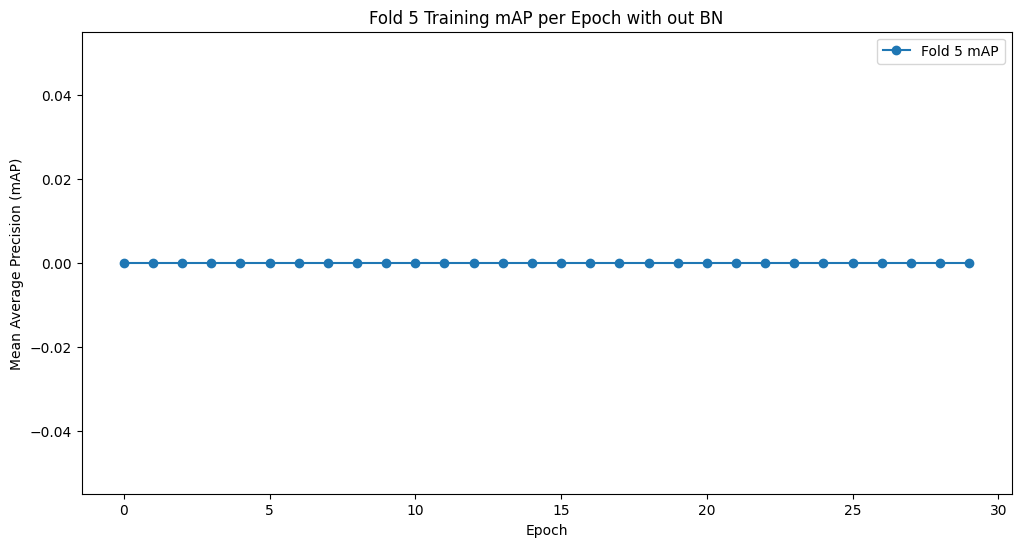

Average Validation mAP across all folds: 5.330875428626314e-05


In [63]:
train_dataset = VOCDataset(
    "100examples.csv",
    transform=transform,
    img_dir=IMG_DIR,
    label_dir=LABEL_DIR,
)

test_dataset = VOCDataset(
    "test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
)


k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=seed)
fold_results = []

# Collect the fold performance for plotting
fold_performance_history = []

for fold, (train_ids, valid_ids) in enumerate(kf.split(np.arange(len(train_dataset)))):
    print(f'FOLD {fold}')
    print('--------------------------------')

    fold_epoch_mAPs = []  # Store mAP for each epoch within this fold

    # Initialize lists to store losses
    train_losses = []
    valid_losses = []


    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    valid_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_subsampler,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
    )

    # Initialize the model and optimizer for this fold
    model = Yolov1_WO_BN(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    loss_fn = YoloLoss().to(DEVICE)

    # Run the training loop for the defined number of epochs
    for epoch in range(EPOCHS):

        # Train for one epoch
        train_fn(train_loader, model, optimizer, loss_fn)

        # Evaluate after the epoch
        valid_mAPs = []
        model.eval()
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(valid_loader):
                x, y = x.to(DEVICE), y.to(DEVICE)
                predictions = model(x)
                # Calculate mAP
                pred_boxes, target_boxes = get_bboxes(valid_loader, model, iou_threshold=0.5, threshold=0.4)
                valid_mAP = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
                valid_mAPs.append(valid_mAP.item())

        # Calculate average mAP for the validation set
        avg_valid_mAP = sum(valid_mAPs) / len(valid_mAPs)
        print(f"Validation mAP for epoch {epoch}: {avg_valid_mAP}")

        fold_epoch_mAPs.append(avg_valid_mAP)

        model.train()

    fold_results.append(avg_valid_mAP)


    # Plot the training mAP for each epoch of the current fold
    plt.figure(figsize=(12, 6))
    plt.plot(range(EPOCHS), fold_epoch_mAPs, marker='o', label=f'Fold {fold+1} mAP')
    plt.title(f'Fold {fold+1} Training mAP per Epoch with out BN')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Average Precision (mAP)')
    plt.legend()
    plt.show()

    fold_results.append(fold_epoch_mAPs[-1])  # Append the last mAP of the fold


average_performance = sum(fold_results) / len(fold_results)
print(f'Average Validation mAP across all folds: {average_performance}')


##Trying to show the underfiting

In [71]:
def validate_f(valid_loader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_correct = 0
    for images, targets in valid_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        with torch.no_grad():  # Disable gradient computation
            predictions = model(images)
            loss = loss_fn(predictions, targets)
            total_loss += loss.item()

    avg_loss = total_loss / len(valid_loader)
    return avg_loss

def train_f(train_loader, model, optimizer, loss_fn):
    model.train()  # Ensure the model is in training mode
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()  # Zero the gradients before the forward pass
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        loss.backward()  # Compute the gradients
        optimizer.step()  # Update the weights

        # Update the progress bar
        loop.set_postfix(loss=loss.item())

    avg_loss = sum(mean_loss) / len(mean_loss)
    print(f"Mean training loss for the epoch was {avg_loss}")
    return avg_loss  # Return the average loss for the epoch

100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.9e+3]

Mean training loss for the epoch was 2283.060343424479


Epoch 1, Train Loss: 2283.060343424479, Valid Loss: 1224.0833740234375


100%|██████████| 3/3 [00:01<00:00,  1.52it/s, loss=1.44e+3]


Mean training loss for the epoch was 2278.7687174479165
Epoch 2, Train Loss: 2278.7687174479165, Valid Loss: 1221.751953125


100%|██████████| 3/3 [00:03<00:00,  1.01s/it, loss=1.48e+3]

Mean training loss for the epoch was 2275.1295572916665


Epoch 3, Train Loss: 2275.1295572916665, Valid Loss: 1219.4578857421875


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=1.86e+3]

Mean training loss for the epoch was 2271.508992513021


Epoch 4, Train Loss: 2271.508992513021, Valid Loss: 1217.29248046875


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=1.69e+3]

Mean training loss for the epoch was 2267.8214111328125


Epoch 5, Train Loss: 2267.8214111328125, Valid Loss: 1215.1580810546875


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=1.73e+3]

Mean training loss for the epoch was 2264.063191731771


Epoch 6, Train Loss: 2264.063191731771, Valid Loss: 1213.05078125


100%|██████████| 3/3 [00:02<00:00,  1.41it/s, loss=1.51e+3]

Mean training loss for the epoch was 2260.6717529296875


Epoch 7, Train Loss: 2260.6717529296875, Valid Loss: 1210.79931640625


100%|██████████| 3/3 [00:03<00:00,  1.03s/it, loss=1.71e+3]

Mean training loss for the epoch was 2257.070556640625


Epoch 8, Train Loss: 2257.070556640625, Valid Loss: 1208.4508056640625


100%|██████████| 3/3 [00:03<00:00,  1.02s/it, loss=1.99e+3]

Mean training loss for the epoch was 2247.983439127604


Epoch 9, Train Loss: 2247.983439127604, Valid Loss: 1206.2613525390625


100%|██████████| 3/3 [00:03<00:00,  1.04s/it, loss=1.82e+3]

Mean training loss for the epoch was 2244.2808837890625


Epoch 10, Train Loss: 2244.2808837890625, Valid Loss: 1203.974365234375


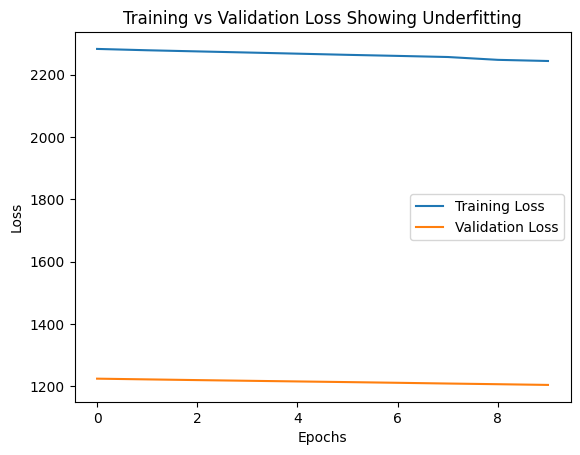

In [80]:
# Placeholder for the modified model that is supposed to underfit
model = Yolov1_WO_BN(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=0.1)
loss_fn = YoloLoss().to(DEVICE)

train_losses = []
valid_losses = []

for epoch in range(10):  # Fewer epochs to prevent the model from learning properly
    train_loss = train_f(train_loader, model, optimizer, loss_fn)
    valid_loss = validate_f(valid_loader, model, loss_fn)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Valid Loss: {valid_loss}")


# Plotting training vs validation loss to demonstrate underfitting
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss Showing Underfitting')
plt.show()

The graph shows the training loss and validation loss over 10 epochs. The training loss (blue line) steadily decreases over time, which suggests that the model is learning the training data well. However, the validation loss (orange line) fluctuates and does not show a clear downward trend. This is a sign of underfitting.

Underfitting occurs when a model is unable to learn the underlying patterns of the data and instead memorizes the specific examples it has seen in the training data. As a result, the model performs well on the training data but does not generalize well to unseen data.

**Learning Rate (lr=1e-6):**

 A very low learning rate can cause the training process to be slow and may prevent the model from learning the complex patterns in the data. With such a small learning rate, the updates to the model weights during training might be too insignificant to effectively capture the underlying relationships.

**Weight Decay (weight_decay=0.1): **While weight decay acts as a regularization technique to prevent overfitting, a high value (0.1 in this case) can also contribute to underfitting. Weight decay introduces a penalty term that discourages large weight values, potentially forcing the model towards simpler solutions and limiting its ability to learn complex features from the data.

**Epochs (#epochs=10):** Although not directly related to underfitting, limiting the number of epochs (training iterations) to 10 might restrict the model from fully exploring the data and converging to a good minimum.  Especially with a low learning rate, more epochs might be needed for the model to learn effectively.
